In [1]:
import sys
print(sys.version)

3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:14:23) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
"""
Created on Aug 15 2019
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

#Zernike_Module_lastOct15_beforeScatterChange
import Zernike_Module
from Zernike_Module import *
from Residual_1D_module import * 


In [6]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

## unit test 

In [7]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([24,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.21f
extraZernike: None
zmax: 11
31
None
-3291.8137877809145


In [8]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

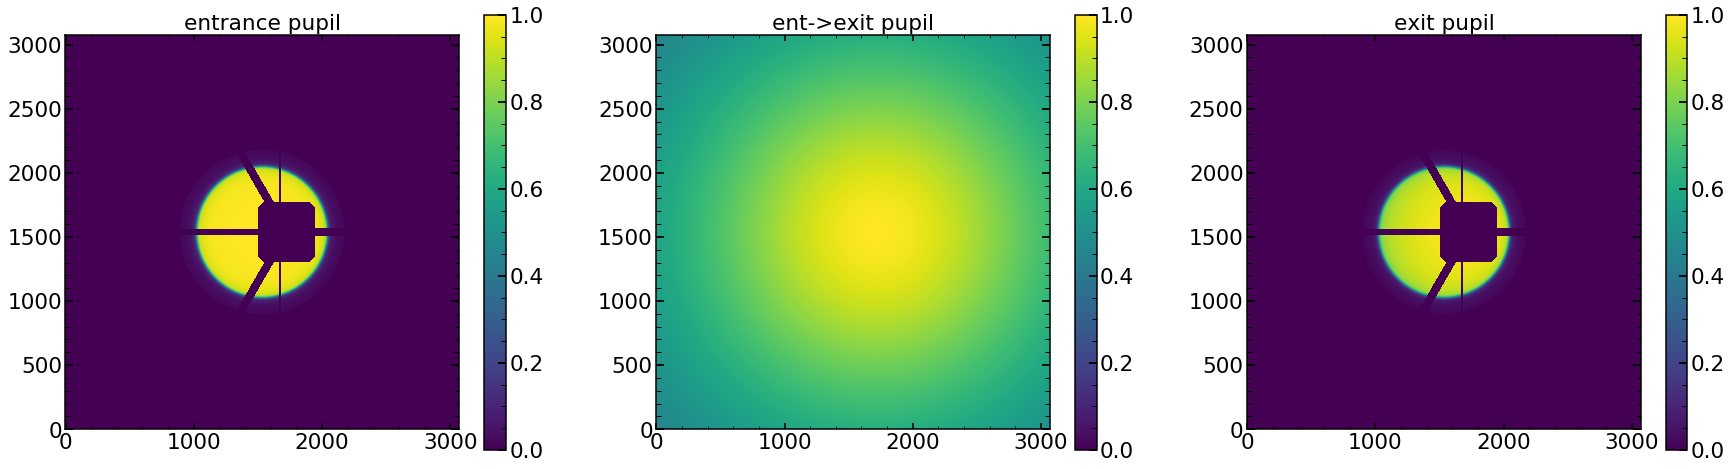

In [9]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

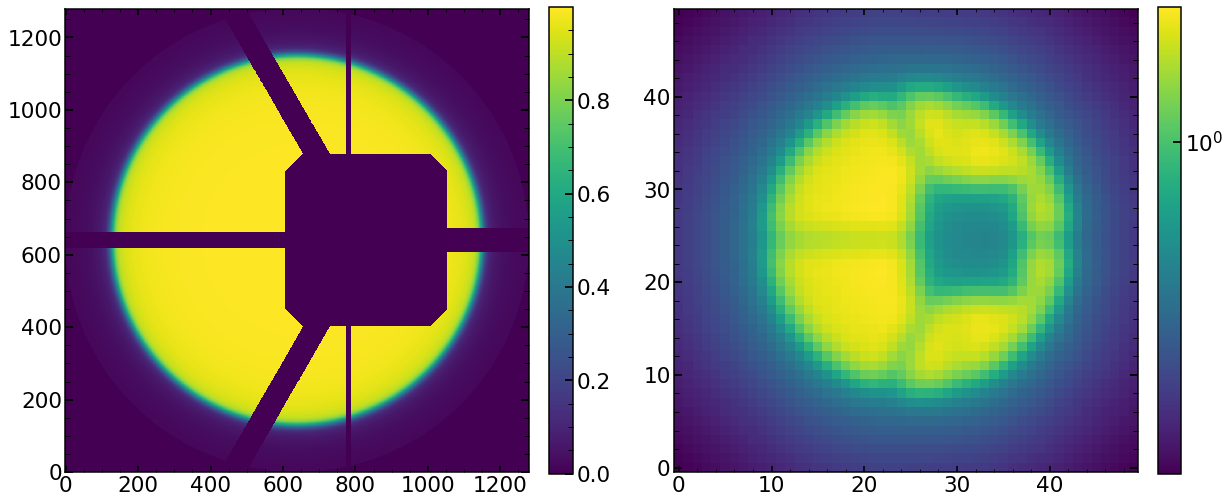

In [10]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([1,10**-2,10**-3,10**-4,10**-5,10,10**2,10**3,10**4,10**5])

## Codes 

In [11]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns11=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns11_analysis=columns+['chi2','chi2max']

columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
           'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

In [12]:
def create_minchain_err(chain0,likechain0,sci_image,var_image,old=0):
    minchain_err_test=[]
    if len(chain0[0][0])==42:
        columns=columns22
        
    else:
        columns=columns11
    
    
    
    for var_number in range(len(columns)):
        #ravel likelihood
        likechain0_Emcee3_ravel=np.ravel(likechain0)

        # connect chain and lnchain
        chain0_Emcee3_ravel=np.ravel(chain0[:,:,var_number])
        chain0_Emcee3_ravel_argsort=np.argsort(chain0_Emcee3_ravel)  
        chain0_Emcee3_ravel_sort=chain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
        likechain0_Emcee3_ravel_sort=likechain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]

        # move to chi2 space
        chi2_Emcee3_ravel_sort=-(np.array(likechain0_Emcee3_ravel_sort)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
        min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel_sort)

        # simplest standard deviation
        std_chain=np.std(chain0_Emcee3_ravel_sort)

        #best solution
        mean_chain=chain0_Emcee3_ravel_sort[chi2_Emcee3_ravel_sort==np.min(chi2_Emcee3_ravel_sort)][0]

        # step size
        step=std_chain/10

        # create result 3*std in each direction
        try:
            res=[]
            if step==0:
                step=10e-17
            for i in np.arange(mean_chain-30*step,mean_chain+30*step,step):
                selected_chi2_Emcee3_ravel_sort=chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))]
                if len(selected_chi2_Emcee3_ravel_sort>10):   
                    res.append([i+step/2,np.min(chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))])])

            res=np.array(res)

            #print(columns[var_number]+' min : '+str(mean_chain))
            #print(columns[var_number]+' std : '+str(std_chain))

            # find low limit and high limit
            res_within2_chi=res[res[:,1]<min_chi2_Emcee3_ravel_sort*2]
            minchain_err_element=[-np.abs(mean_chain-res_within2_chi[0,0]),np.abs(res_within2_chi[-1,0]-mean_chain)]
        except IndexError:
            if var_number!=25:
                print(columns[var_number]+': failed!')
                minchain_err_element=[-mean_chain,mean_chain]

        minchain_err_test.append(minchain_err_element)
        #print(columns[var_number]+' min_err : '+str(minchain_err_element[0]))
        #print(columns[var_number]+' max_err : '+str(minchain_err_element[1]))
    if old==1:
        minchain_err_test=np.mean(np.abs(np.array(minchain_err_test)),axis=1)
        #print(minchain_err_test)
        return minchain_err_test
    else:       
        return np.array(minchain_err_test)
    
    
import scipy.optimize as optimize
def curve_fit_custom_lin(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a,b=V
    yfit=lin_fit_1D(index_arr,a,b)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2

def curve_fit_custom_con(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a=V
    yfit=lin_fit_1DConstant(index_arr,a)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2 

In [387]:
def create_results_of_fit_single(date,single_number,arc=None,zMax=None,dataset=None):
    """create solution from a single image, create error and lower and upper erros

    @param[in] date             date when the analysis was conducted
    @param[in] single_number    number of the image
    @param[in] arc              which arc was analyzed
    @returns       results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper to be fed to solution_at_0_and_plots
    """
    print(zMax)
    if arc is None:
        arc='HgAr'
    if dataset is None:
        dataset=1  
        
    if dataset==0:
        if arc=='HgAr':
            obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
        elif arc=='Ne':
        #    print('Neon?????')
            obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])+90

    # F/3.2 data
    if dataset==1:
        if arc=='HgAr':
            obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
        elif arc=='Ne':
            # different sequence than for HgAr
            obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])    

    # F/2.8 data
    if dataset==2:
        if arc=='HgAr':
            obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                       17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
        elif arc=='Ne':
            # different sequence than for HgAr
            obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                       16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
        elif arc=='Kr':
             obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                        17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])
    
    # F/2.5 data  
    if dataset==3:
        if arc=='HgAr':
            obs_possibilites=np.array([19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+54,19238+54,\
                                       19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+102,19238+54])
        elif arc=='Ne':
        # different sequence than for HgAr
            obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                       19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54])    
    # F/2.8 data - July data
    if dataset==4:
        if arc=='HgAr':
            obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                       21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
        if arc=='Ne':
            obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                       21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
        if arc=='Kr':
             obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                        21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
            
    if zMax==22:
        columns_analysis=columns22_analysis
    else:
        columns_analysis=columns11_analysis
    
    results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),\
                                       index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],\
                                       columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),\
                                           index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],\
                                           columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),\
                                                 index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],\
                                                 columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),\
                                                 index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],\
                                                 columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=obs_possibilites

    #single_number=55
    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                print(str(single_number)+'obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
            else:       
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
                #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

 
            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2
            #print(" test0")

            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            #print(minchain_err_old)
            #print(" test1")
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            #print(" test2")
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            #print(" test3")
            #print(results_of_fit_single.iloc[single_defocus])
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            #print(" test4")
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            #print(" test5")
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            #print(" test6")
        
        except:
            ValueError
            print(str(single_number)+' '+str(obs)+' '+str(arc)+' is NOT found or failed!')
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper


def create_results_of_fit_single_focus(date,single_number,arc=None,zMax=None,dataset=None):
    """create solution from a single image, create error and lower and upper erros

    @param[in] date             date when the analysis was conducted
    @param[in] single_number    number of the image
    @param[in] arc              which arc was analyzed
    @param[in] zMax             biggest Zernike polynomial analysed
    @param[in] dataset          which dataset
    
    @returns       results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper to be fed to solution_at_0_and_plots
    """
    print(zMax)
    if arc is None:
        arc='HgAr'
        
    if arc=='HgAr':
        obs_possibilites=np.array([11748])
        labels=['11748']
    elif arc=='Ne':
        obs_possibilites=np.array([12355])
        labels=['12355']
        
    if dataset==2:
        if arc=='HgAr':
            obs_possibilites=np.array([17017+54])
            labels=['17071']
        elif arc=='Ne':
            obs_possibilites=np.array([16292])
            labels=['16292']
        elif arc=='Kr':
            obs_possibilites=np.array([17364])
            labels=['17364']
            
            
    if dataset==3:
        if arc=='HgAr':
            obs_possibilites=np.array([19238+54])
            labels=['19292']
        elif arc=='Ne':
            obs_possibilites=np.array([19472+54 ])
            labels=['19526']
            
        
    # dataset=4
    if dataset==4:   
        if str(arc)=="HgAr":
            obs_possibilites=np.array([21346+54 ])
            labels=['21400']
        elif str(arc)=="Ne":
            obs_possibilites=np.array([21550+54  ])
            labels=['21604']
        elif str(arc)=="Kr":
            obs_possibilites=np.array([21754+54 ])
            labels=['21808']
        else:
            print("Not recognized arc-line")                
            
    if zMax==22:
        columns_analysis=columns22_analysis
    else:
        columns_analysis=columns11_analysis        
        

    results_of_fit_single=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((len(labels),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=labels,columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=obs_possibilites

    #single_number=55
    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                print(str(single_number)+'obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
            else:       
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
                #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

 
            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2
            #print(" test0")

            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            #print(minchain_err_old)
            #print(" test1")
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            #print(" test2")
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            #print(" test3")
            #print(results_of_fit_single.iloc[single_defocus])
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            #print(" test4")
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            #print(" test5")
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            #print(" test6")
        
        except:
            ValueError
            print(str(single_number)+' '+str(obs)+' '+str(arc)+' is NOT found or failed!')
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper

In [524]:
def solution_at_0_and_plots(date,single_number,arc,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,\
                            plot=True,zMax=None,return_solution_at_05_0_05=None):
    """create solution at the focus and plot dependence with defocu

    @param[in] date             date when the analysis was conducted
    @param[in] single_number    number of the image
    @param[in] arc              which arc was analyzed
  
    """    
    
    if zMax==22:
        columns_analysis=columns22_analysis
        columns=columns22
        z_addition_factor=11
    else:
        columns_analysis=columns11_analysis
        columns=columns11
        z_addition_factor=0
    
    results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]    
    
    if len(results_of_fit_single)<=7:
        if zMax==22:
            solution_at_0=np.full(31+11,0)

        else:
            solution_at_0=np.full(31,0)       

        return solution_at_0
    else:
        IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

        solution_at_0=[]
        solution_at_05_0_05=[]


        for q in columns_analysis:

            z4_arr=np.array(results_of_fit_single[q])
            z4_arr_err=np.array(err_results_of_fit_single[q])
            z4_arr_err_up=np.array(err_results_of_fit_single_upper[q])
            z4_arr_err_low=np.array(err_results_of_fit_single_lower[q])
            index_arr=results_of_fit_single[q].index.values.astype(float)
            #print(q)
            #print(index_arr)
            #print(z4_arr)
            #print(z4_arr_err)
            #print(z4_arr_err_up)
            #print(z4_arr_err_low)
            
            z4_arr_no0=z4_arr[np.abs(index_arr)>0.5]
            z4_arr_no0_err=z4_arr_err[np.abs(index_arr)>0.5]
            z4_arr_no0_err_up=z4_arr_err_up[np.abs(index_arr)>0.5]
            z4_arr_no0_err_low=z4_arr_err_low[np.abs(index_arr)>0.5]
            index_arr_no0=index_arr[np.abs(index_arr)>0.5]
            #print(q)
            #print(index_arr_no0)
            #print(z4_arr_no0)
            #print(z4_arr_no0_err)
            #print(z4_arr_no0_err_up)
            #print(z4_arr_no0_err_low)
            
            
            z4_arr_only0=z4_arr[np.abs(index_arr)<=0.5]
            z4_arr_only0_err=z4_arr_err[np.abs(index_arr)<=0.5]
            z4_arr_only0_err_up=z4_arr_err_up[np.abs(index_arr)<=0.5] 
            z4_arr_only0_err_low=z4_arr_err_low[np.abs(index_arr)<=0.5]
            index_arr_only0=index_arr[np.abs(index_arr)<=0.5]

            fit_res=[]
            fit_res_focus=[]
            interim_zero_solutions=[]

            
            if q in columns[:8+z_addition_factor]:
                # these variables are fit via linear fit, without values at focus
                # it is z4-z11
                # for loop below removes 2 points from the fit that create largest deviations from median result in focus
                for l in range(len(index_arr_no0)):
                    #print('good_index'+str(np.delete(index_arr_no0,l)))
                    #print('index_arr_no0'+str(np.delete(z4_arr_no0,l)))
                    #print('z4_arr_no0_err_low'+str(np.delete(z4_arr_no0_err_low,l)))
                    #print('z4_arr_no0_err_up'+str(np.delete(z4_arr_no0_err_up,l)))
                    popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,lin_fit_1D(0,popt[0],popt[1])])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                second_max_dif=np.sort(interim_zero_solutions_arr_dif)[-2]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<second_max_dif]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                #print('good_index'+str(good_index))
                #print('index_arr_no0'+str(index_arr_no0))
                #print('z4_arr_no0_err_low'+str(z4_arr_no0_err_low))
                #print('z4_arr_no0_err_up'+str(z4_arr_no0_err_up))
                popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]

                for i in np.linspace(-4.5,4.5,19):
                    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
                for j in np.linspace(-0.5,0.5,11):
                    fit_res_focus.append(lin_fit_1D(j,popt[0],popt[1]))
                    
                solution_at_0.append(fit_res[9])
                solution_at_05_0_05.append(fit_res_focus)

            interim_zero_solutions=[]
            if q in columns[8+z_addition_factor:25+z_addition_factor]:
                # these variables are set at mean value (constant fit), without values at focus
                # these are variables that describe the pupil
                for l in range(len(index_arr_no0)):
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,popt[0]])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                third_max_dif=np.sort(interim_zero_solutions_arr_dif)[-3]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<=(third_max_dif*1.1)]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                
                fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                fit_res_focus=lin_fit_1DConstant(np.linspace(-0.5,0.5,11),popt[0])
                
                solution_at_0.append(fit_res[9])
                solution_at_05_0_05.append(fit_res_focus)

            if q in np.concatenate((np.array(columns[25+z_addition_factor:]),np.array(['chi2','chi2max'])),axis=0):
                # these variables are set at value as measured at 0 - (perhaps is should be close to 0)
                if z4_arr_only0.size==1:
                    for i in np.linspace(-4.5,4.5,19):
                        fit_res.append(z4_arr_only0) 
                    
                    for j in np.linspace(-0.5,0.5,11):
                        fit_res_focus.append(z4_arr_only0)
                    
                    solution_at_0.append(fit_res[9])
                    solution_at_05_0_05.append(fit_res_focus)
                else:
                    # these variables are set at mean value (constant fit), without values at focus
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(index_arr_only0, z4_arr_only0, z4_arr_only0_err_low,z4_arr_only0_err_up))[0]
                    fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                    fit_res_focus=lin_fit_1DConstant(np.linspace(-0.5,0.5,11),popt[0]) 
                    
                    solution_at_0.append(fit_res[9])
                    solution_at_05_0_05.append(fit_res_focus)

            #making plots here
            ######
            #print(q)
            #print(fit_res)
            plt.figure(figsize=(20,10))
            plt.errorbar(index_arr,z4_arr,yerr=[np.abs(z4_arr_err_low),z4_arr_err_up],color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
            plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
            if q in columns[:8]:
                plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),':',color='black')
            plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red",label='prediction for focus')
            #print('prediction for focus: '+str(q)+' '+str(fit_res[9]))
            plt.title(q,size=40)
            plt.legend(fontsize=25)
            plt.xlabel('defocus lab [mm]',size=30)
            plt.ylabel('defocus model',size=30)
            #print(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'+str(arc)+str(q))

            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(q)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(q)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q)+'/'+str(arc)+str(single_number))

            plt.close()   
            ######

        solution_at_0=np.array(solution_at_0)[:len(solution_at_0)-2]
        
        solution_at_05_0_05=np.transpose(np.array(solution_at_05_0_05[0:42]))
        print(solution_at_05_0_05.shape)
        if return_solution_at_05_0_05 is None:
            return solution_at_0
        else:
            return solution_at_0,solution_at_05_0_05

In [15]:
def residual_1D(sci_image,var_image,res_iapetus):
    
    """

    @param[in] sci_image        data (20x20 cutout)
    @param[in] var_image        Variance data (20x20 cutout)
    @param[in] res_iapetus      model (20x20 cutout)
    """

    #sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')    
    multiplicative_factor_to_renormalize_to_50000=np.max(sci_image)/50000
    sci_image_smaller=sci_image[:,8:14]/multiplicative_factor_to_renormalize_to_50000
    var_image_smaller=var_image[:,8:14]/multiplicative_factor_to_renormalize_to_50000

    residual_initial_smaller=sci_image_smaller-res_iapetus[:,8:14]/multiplicative_factor_to_renormalize_to_50000
    #residual_RF_smaller=chi_RF_corrected_image[:,8:14]*np.sqrt(var_image_smaller)

    #################################
    # step 5 from Horne, very simplified
    inputimage_smaller=sci_image_smaller
    Px=np.sum(inputimage_smaller,axis=0)/np.sum(inputimage_smaller)
    var_inputimage_smaller=var_image_smaller
    #################################
    # Equation 8 from Horne with modification from Robert abut variance for extraction of signal
    # note that this uses profile from full thing, and not "residual profile"

    # nominator
    weighted_inputimage_smaller=inputimage_smaller*Px/(1)
    # denominator
    weights_array=np.ones((inputimage_smaller.shape[0],inputimage_smaller.shape[1]))*Px**2

    init_lamda=np.array(list(map(np.sum, weighted_inputimage_smaller)))/(np.array(list(map(np.sum,weights_array))))
    init_lamda_boxcar=np.array(list(map(np.sum, inputimage_smaller)))
    # Equation 8.5 from Horne
    var_f_std_lamda=1/np.sum(np.array(Px**2/(var_inputimage_smaller)),axis=1)
    std_init_lamda=np.sqrt(var_f_std_lamda)
    std_init_lamda_boxcar=np.sqrt(np.array(list(map(np.sum, var_inputimage_smaller))))


    #################################
    # Equation 8 from Horne with modification from Robert abut variance for initial removal
    # note that this uses profile from full thing, and not "residual profile"

    # nominator
    weighted_inputimage_smaller=residual_initial_smaller*Px/(1)
    # denominator
    weights_array=np.ones((residual_initial_smaller.shape[0],residual_initial_smaller.shape[1]))*Px**2

    init_removal_lamda=np.array(list(map(np.sum, weighted_inputimage_smaller)))/(np.array(list(map(np.sum,weights_array))))
    init_removal_lamda_boxcar=np.array(list(map(np.sum, residual_initial_smaller)))
    # Equation 8.5 from Horne
    var_init_removal_lamda=1/np.sum(np.array(Px**2/(var_inputimage_smaller)),axis=1)
    std_init_removal_lamda=np.sqrt(var_init_removal_lamda)
    return init_lamda,std_init_lamda,init_removal_lamda,std_init_removal_lamda

def chi_50000(sci_image,var_image,res_iapetus):

    #sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')    
    multiplicative_factor_to_renormalize_to_50000=np.max(sci_image)/50000
    sci_image_renormalized=sci_image/multiplicative_factor_to_renormalize_to_50000
    var_image_renormalized=var_image/multiplicative_factor_to_renormalize_to_50000
    res_iapetus_renormalized=res_iapetus/multiplicative_factor_to_renormalize_to_50000
    

    return np.mean((sci_image_renormalized-res_iapetus_renormalized)**2/var_image_renormalized)

In [16]:
def add_artificial_noise(sci_image,var_image,res_iapetus):
    
    """
    add extra noise so that it has comparable noise as if the max flux in the image (in the single pixel) is 40000
    
    
    """

    
    multi_factor=np.max(sci_image)/40000
    Max_SN_now=np.max(sci_image)/np.max(np.sqrt(var_image))
    dif_in_SN=Max_SN_now/200
    artifical_noise=np.zeros_like(res_iapetus)
    artifical_noise=np.array(artifical_noise)
    for i in range(len(artifical_noise)):
        for j in range(len(artifical_noise)):
            artifical_noise[i,j]=np.random.randn()*np.sqrt((dif_in_SN**2-1)*var_image[i,j])   
            
    if dif_in_SN>1:        
        return (sci_image+artifical_noise),((dif_in_SN**2)*var_image),res_iapetus
    else:
        return (sci_image),((dif_in_SN**2)*var_image),res_iapetus 

# Aug16

In [17]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
finalNe=finalNe_May2019

## scripts 

In [22]:
list_of_HgAr_to_analyze=finalHgAr.index[(finalHgAr['fiber'].values.astype(int)<=650)&(finalHgAr['fiber'].values.astype(int)>=2)
                                        &(finalHgAr['close'].values.astype(int)==1)]
print(len(list_of_HgAr_to_analyze))

list_of_Ne_to_analyze=finalNe.index[(finalNe['fiber'].values.astype(int)<=650)&(finalNe['fiber'].values.astype(int)>=2)
                                        &(finalNe['close'].values.astype(int)==1)]
print(len(list_of_Ne_to_analyze))

list_of_Kr_to_analyze=finalKr.index[(finalKr['fiber'].values.astype(int)<=650)&(finalKr['fiber'].values.astype(int)>=2)
                                        &(finalKr['close'].values.astype(int)==1)]
print(len(list_of_Kr_to_analyze))


50
40
10


In [23]:
#MPI
for single_spot in list_of_HgAr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T04S'+str(single_spot)+'Aug.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21346+6,21346+102,21346+54,21346+12,21346+96,21346+48,21346+60,21346+18,21346+90,21346+36,21346+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Aug_MPI03.py "+str(obs)+" "+str(single_spot)+" 40 5 HgAr 4\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AugScriptToSubmitScriptsTiger04'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T04S'+str(single_spot)+'Aug.sh \n')

file.close()
##################
##################
##################

for single_spot in list_of_Ne_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T05S'+str(single_spot)+'Aug.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21550+6,21550+102,21550+54,21550+12,21550+96,21550+48,21550+60,21550+18,21550+90,21550+36,21550+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Aug_MPI03.py "+str(obs)+" "+str(single_spot)+" 40 5 Ne 4\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AugScriptToSubmitScriptsTiger05'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T05S'+str(single_spot)+'Aug.sh \n')

file.close()
##################
##################
##################
for single_spot in list_of_Kr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T06S'+str(single_spot)+'Aug.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21754+6,21754+102,21754+54,21754+12,21754+96,21754+48,21754+60,21754+18,21754+90,21754+36,21754+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Aug_MPI03.py "+str(obs)+" "+str(single_spot)+" 40 5 Kr 4\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AugScriptToSubmitScriptsTiger06'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T06S'+str(single_spot)+'Aug.sh \n')

file.close()

## which images are avaliable 

In [32]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
finalNe=finalNe_May2019

In [33]:
import glob
date='Aug16'
Emcee3_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5NeEmcee3.npy', recursive=True)
Emcee3_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5HgArEmcee3.npy', recursive=True)
Emcee3_Kr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5KrEmcee3.npy', recursive=True)

In [34]:
analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][90:len(Emcee3_Ne[0])-13]
    analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:])])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_HgAr_images=[]
for i in range(len(Emcee3_HgAr)):
    single_string=Emcee3_HgAr[i][90:len(Emcee3_HgAr[i])-15]
    analyzed_HgAr_images.append([int(single_string[:5]),int(single_string[5:])])
 

analyzed_HgAr_images=np.array(analyzed_HgAr_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][90:len(Emcee3_Kr[i])-13]
    analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:])])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [35]:
arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]

arranged_by_defocus_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,0].argsort()]
arranged_by_spot_number_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,1].argsort()]

arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]

In [48]:
arranged_by_spot_number_HgAr

array([[21418,     1],
       [21382,     1],
       [21448,     1],
       ...,
       [21442,   119],
       [21358,   119],
       [21364,   119]])

## single analysis 

In [310]:

date='Aug16'
obs=21418
single_number='1'
image_index=int(single_number)
eps=5
arc='HgAr'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
        
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]

p15


fiber                           2
xc                             69
yc                            875
wavelength               696.7261
close                           1
lamp                         HgAr
xc_effective                   69
old_index_approx                1
superold_index_approx        90.0
Name: 1, dtype: object

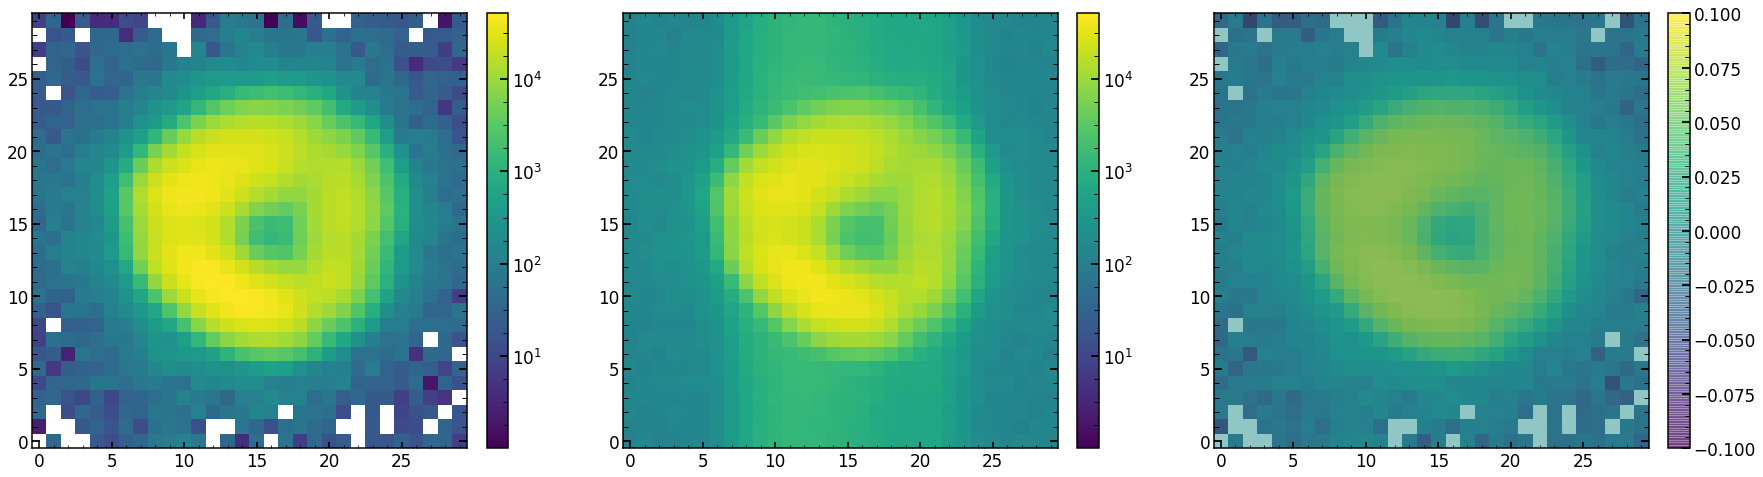

In [311]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [312]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 20, 42)
minimal likelihood is: 4996.324561707301
minimal chi2 reduced is: 11.083915769688097


In [313]:
print(minchain.shape)

if len(minchain)==42:
    columns=columns22
    
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

(42,)
          z4        z5        z6        z7        z8        z9       z10  \
0 -10.362579  0.560209 -0.077254  0.450622  0.826757  0.239657 -0.366527   

        z11  
0  0.101117  
        z12       z13       z14       z15       z16       z17       z18  \
0 -0.083894 -0.079991  0.023816  0.001552  0.059755  0.022614  0.010412   

        z19       z20       z21  
0  0.013712 -0.030825 -0.004914  
        z22   hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.071079  0.662605    0.10701 -0.281816 -0.028659  0.055285     0.064586   

   radiometricEffect  radiometricExponent    x_ilum    ...     frd_sigma  \
0           0.000041             0.000041  0.974929    ...       0.11509   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.494694  1.002234            0.470974   77712.239947   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0          2.501419              0.003212      0.439694  1.8170

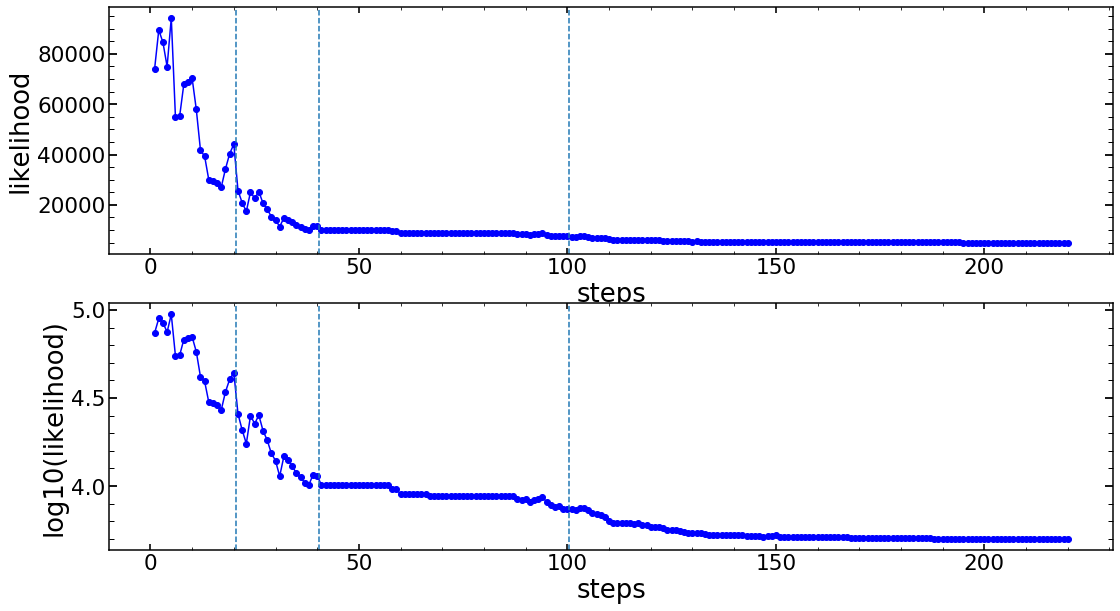

In [314]:
size=chain0_Emcee3.shape[1]
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(5*size+0.5,ls='--')

In [315]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22)   
       
model(minchain)

extraZernike: None
zmax: 22
None


-293092.1451781172

In [316]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')
res_init=np.load(TESTING_FINAL_IMAGES_FOLDER+'res_init.npy')
res=np.load(TESTING_FINAL_IMAGES_FOLDER+'res.npy')


optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

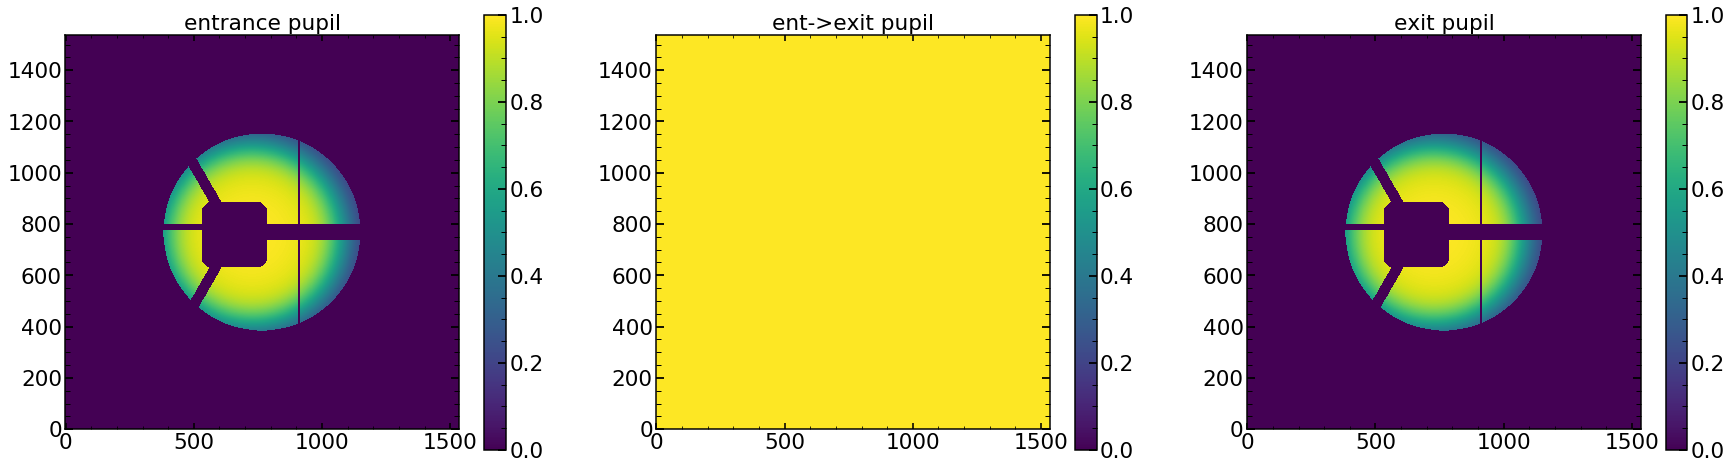

In [317]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

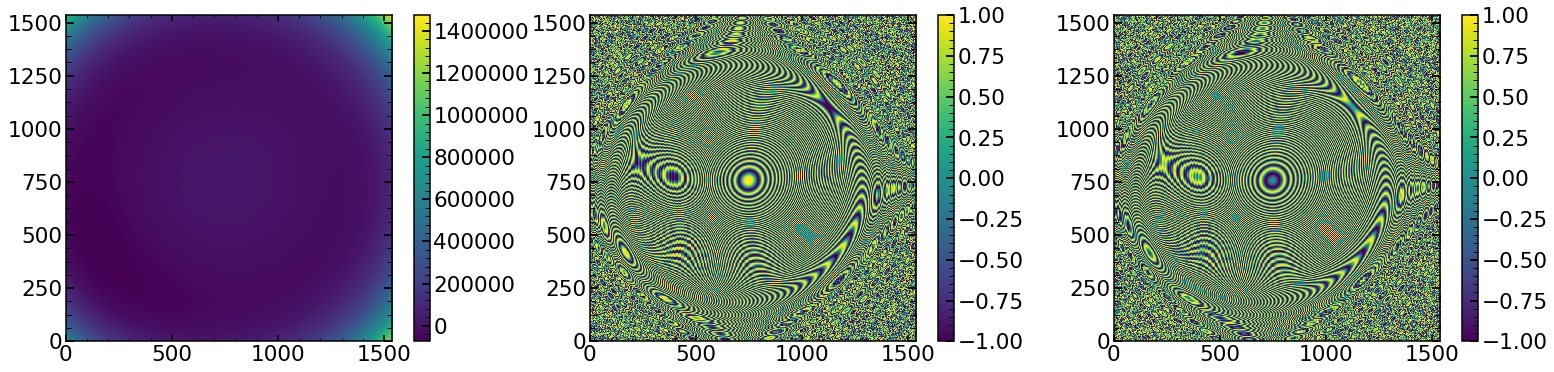

In [318]:
plt.figure(figsize=(36,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

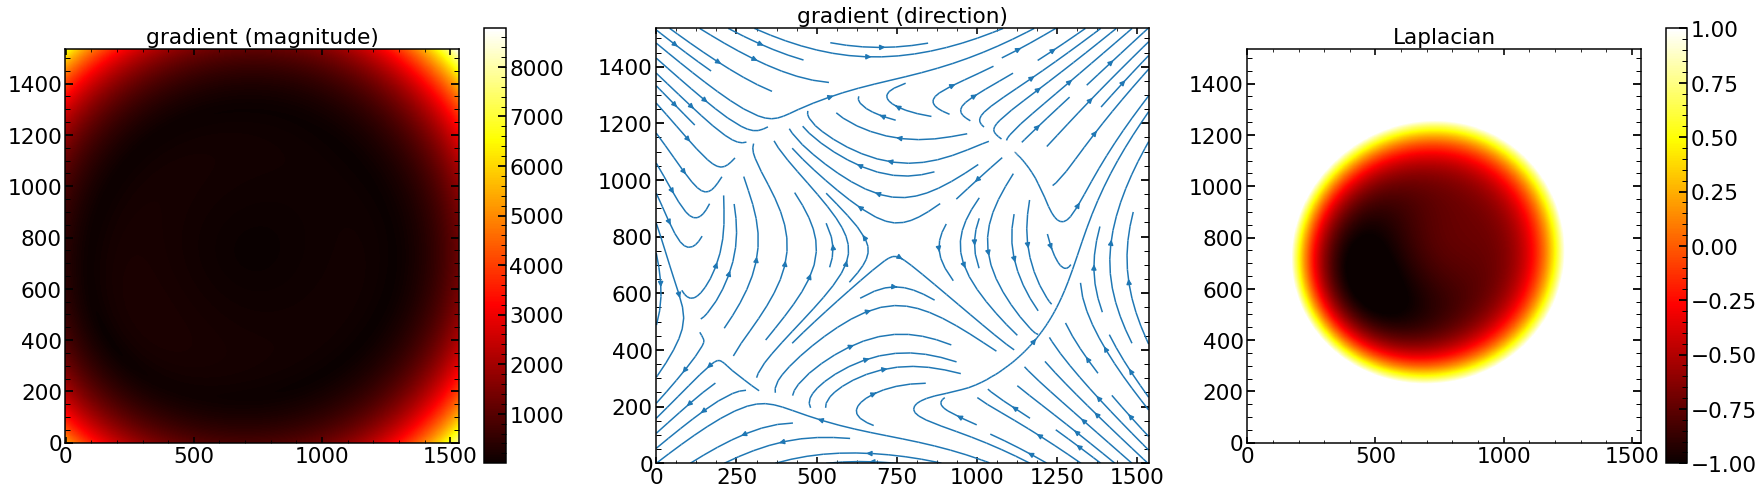

In [319]:
plt.figure(figsize=(30,8))
plt.subplot(131)
vgrad = np.gradient(wf_full)
fulgrad = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
plt.title('gradient (magnitude)')
plt.imshow(fulgrad,cmap=plt.get_cmap('hot'), vmin = np.amin(fulgrad),vmax = np.amax(fulgrad))  
plt.colorbar()
plt.subplot(132)
x, y = range(0, len(wf_full)), range(0,len(wf_full))
xi, yi = np.meshgrid(x, y)
plt.title('gradient (direction)')
plt.streamplot(xi, yi, vgrad[0], vgrad[1])
plt.subplot(133)
laplace_of_wf = scipy.ndimage.filters.laplace(wf_full)
plt.title('Laplacian')
plt.imshow(laplace_of_wf,cmap=plt.get_cmap('hot'), vmin = -1,vmax = 1) 
plt.colorbar()

Text(0.5,1,'Residual')

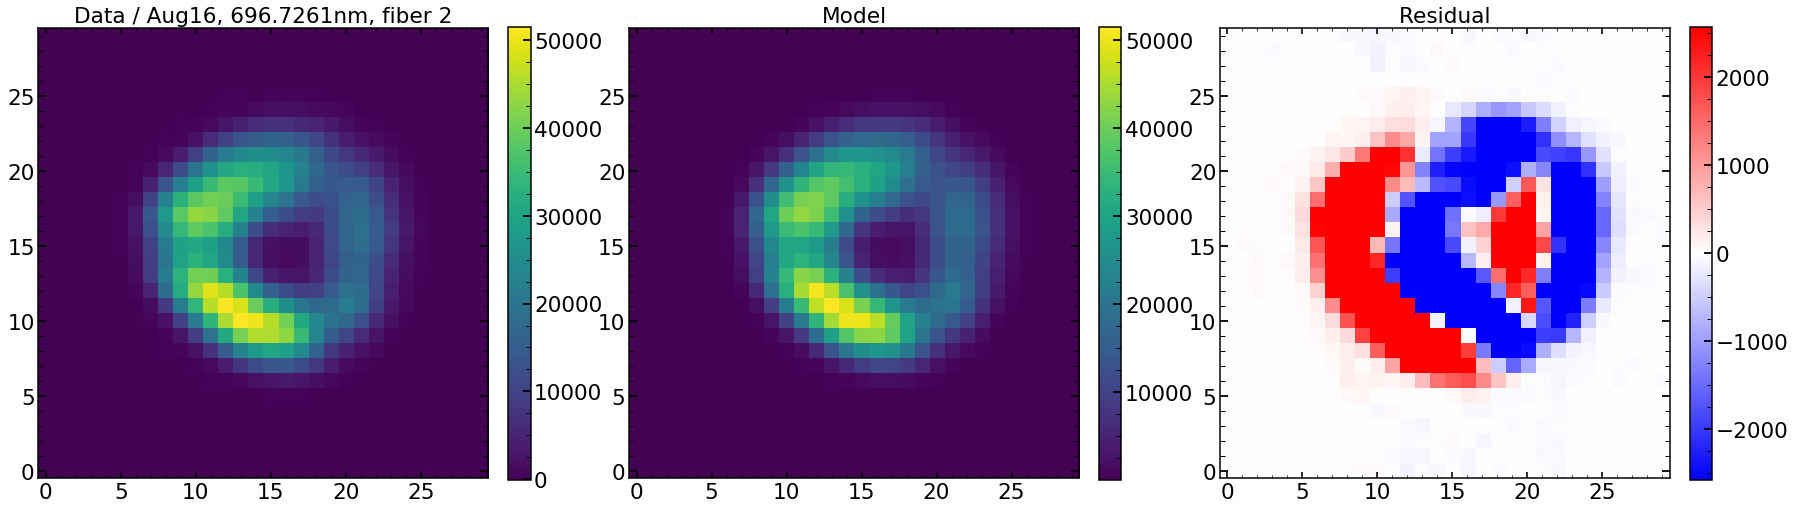

In [320]:
plt.figure(figsize=(30,12))
plt.subplot(1,3,1)
plt.imshow(sci_image,vmax=np.max(sci_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Data / '+str(date)+', '+str(finalArc.loc[int(single_number)]['wavelength'])+'nm, fiber '+str(finalArc.loc[int(single_number)]['fiber']))
plt.subplot(1,3,2)
plt.imshow(res_iapetus,vmax=np.max(sci_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Model')
plt.subplot(1,3,3)
plt.imshow(sci_image-res_iapetus,vmin=-np.max(sci_image)/20,vmax=np.max(sci_image)/20,cmap='bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Residual')

chi**2 reduced is: 11.09140472288701
Abs of residual divided by total flux is: 0.030421765369595562
Abs of residual divided by largest value of a flux in the image is: 0.04209654304543764


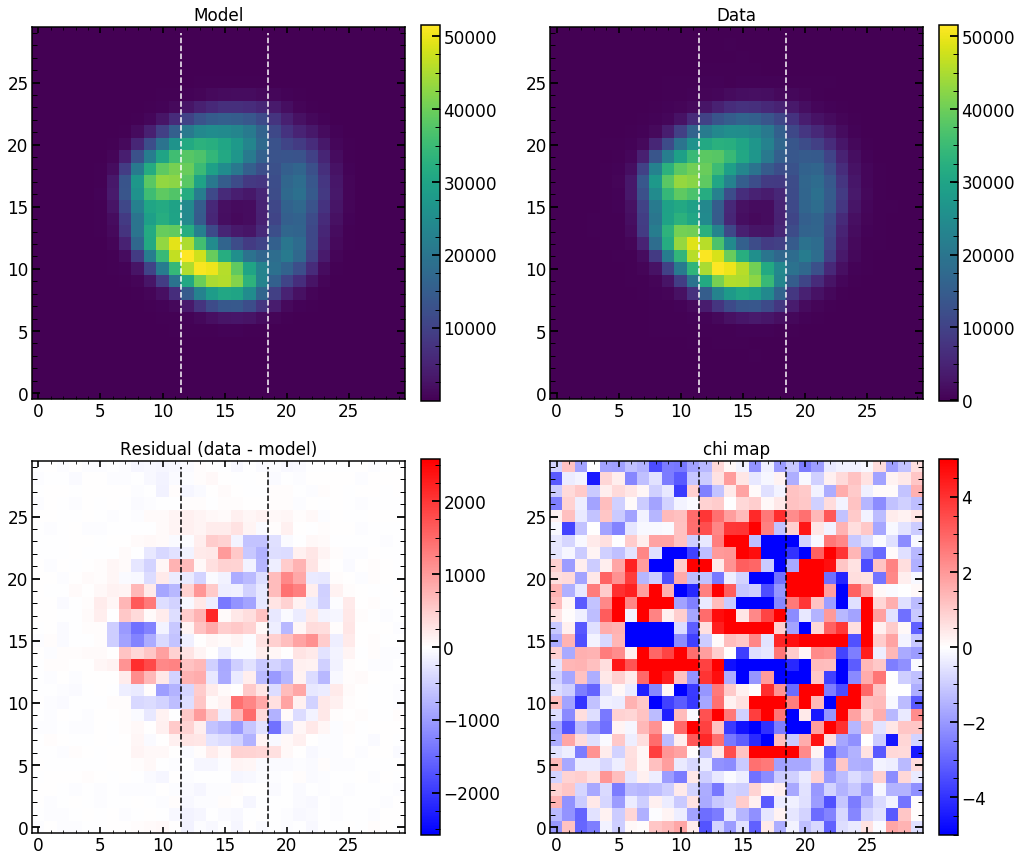

In [233]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

11.09140472288701
chi**2 reduced is: 11.09140472288701
Abs of residual divided by total flux is: 0.030421765369595562
Abs of residual divided by largest value of a flux in the image is: 0.04209654304543764


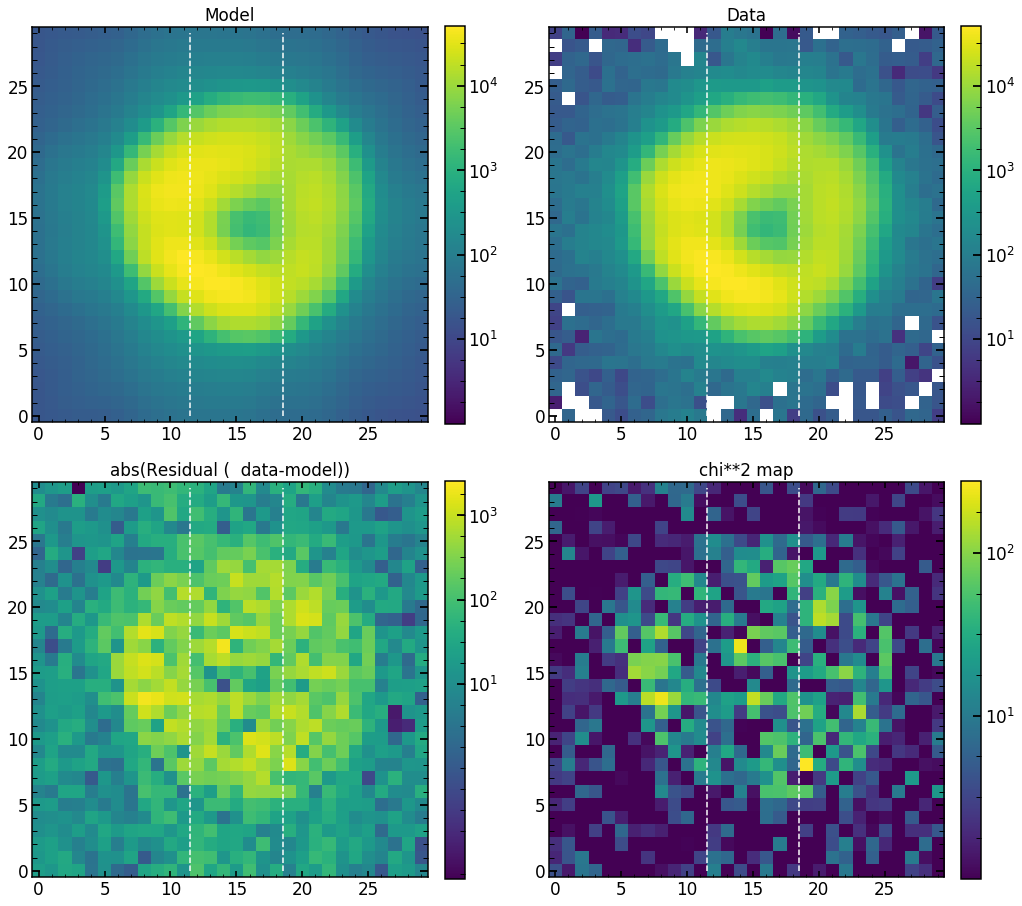

In [234]:
single_analysis.create_basic_comparison_plot_log()

11.09140472288701
chi**2 reduced is: 11.09140472288701
Abs of residual divided by total flux is: 0.030421765369595562
Abs of residual divided by largest value of a flux in the image is: 0.04209654304543764


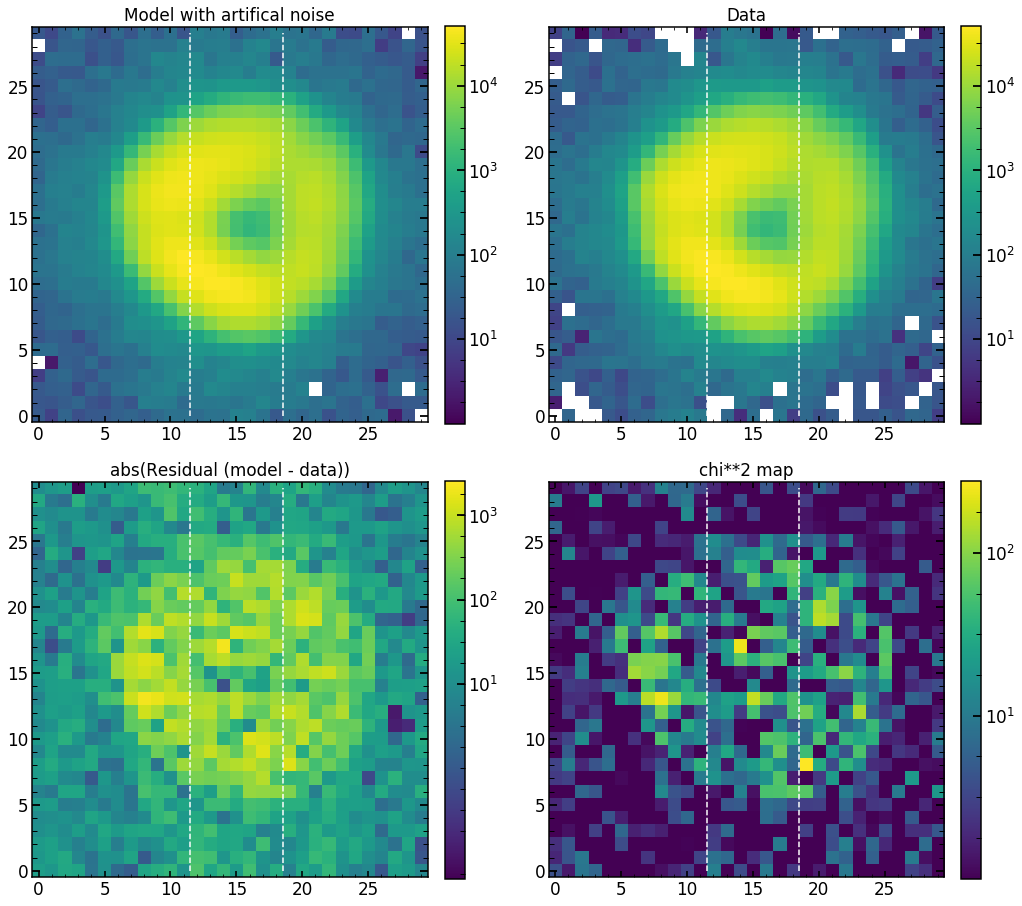

In [235]:
single_analysis.create_basic_comparison_plot_log_artifical()

In [81]:
plot_1D_residual(sci_image,var_image,res_iapetus)

AssertionError: 

## results everywhere 

In [85]:
#single_number_for_single_pos_full=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full.npy") 

finalHgAr=finalHgAr_May2019
finalNe=finalNe_May2019
finalKr=finalKr_May2019
date='Aug16'


results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                     index=finalHgAr.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                         index=finalHgAr.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_defocus_HgAr)
err_results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_HgAr)

results_of_fit_many_HgAr = {'m4': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_HgAr_pd.copy()}

label=['m4','m35','m3','m25','m2','m15','m1','m05','0','0d','p05','p1','p15','p2','p25','p3','p35','p4','0p']

for single_number in range(1,len(finalHgAr)):
    # which date, which nubmer, which arc, how many z, which dataset    
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    create_results_of_fit_single(date,single_number,'HgAr',22,4)
    solution_at_0=solution_at_0_and_plots(date,single_number,'HgAr',results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,22)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_HgAr[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_HgAr[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_HgAr[label[i]]=results_of_fit_many_HgAr[label[i]][np.abs(results_of_fit_many_HgAr[label[i]]['z4'])>0]


22
1 obs (Emcee3): 21352 is found!
1 obs (Emcee3): 21358 is found!
y_ilum: failed!
y_ilum: failed!
1 obs (Emcee3): 21364 is found!
1 21370 HgAr is NOT found or failed!
1 21376 HgAr is NOT found or failed!
1 obs (Emcee3): 21382 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
1 21388 HgAr is NOT found or failed!
1 obs (Emcee3): 21394 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
1 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
1 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
1 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_il

slitHolder_frac_dx: failed!
grating_lines: failed!
scattering_amplitude: failed!
fiber_r: failed!
9 obs (Emcee3): 21364 is found!
9 21370 HgAr is NOT found or failed!
9 21376 HgAr is NOT found or failed!
9 obs (Emcee3): 21382 is found!
y_ilum: failed!
y_ilum: failed!
9 21388 HgAr is NOT found or failed!
9 obs (Emcee3): 21394 is found!
radiometricExponent: failed!
radiometricExponent: failed!
9 obs (Emcee3): 21400 is found!
x_ilum: failed!
x_ilum: failed!
9 obs (Emcee3): 21400 is found!
x_ilum: failed!
x_ilum: failed!
9 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
9 21412 HgAr is NOT found or failed!
9 obs (Emcee3): 21418 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
9 21424 HgAr is NOT found or failed!
9 21430 HgAr is NOT found or failed!
9 obs (Emcee3): 21436 is found!
radiometricExponent: failed!
radiometricExponent: failed!
9 obs (Emcee3): 21442 is found!


radiometricExponent: failed!
y_ilum: failed!
15 obs (Emcee3): 21448 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
15 obs (Emcee3): 21394 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
15 21394 HgAr is NOT found or failed!
22
16 21352 HgAr is NOT found or failed!
16 21358 HgAr is NOT found or failed!
16 21364 HgAr is NOT found or failed!
16 21370 HgAr is NOT found or failed!
16 21376 HgAr is NOT found or failed!
16 21382 HgAr is NOT found or failed!
16 21388 HgAr is NOT found or failed!
16 21394 HgAr is NOT found or failed!
16 21400 HgAr is NOT found or failed!
16 21400 HgAr is NOT found or failed!
16 21406 HgAr is NOT found or failed!
16 21412 HgAr is NOT found or failed!
16 21418 HgAr is NOT found or failed!
16 21424 HgAr is NOT found or failed!
16 21430 HgAr is NOT found or failed!
16 21436 HgAr is NOT found or failed!
16 21442 HgAr is NOT found or failed!
16 21448 HgAr is NOT found or failed!
16 21394 H

23 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
23 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
23 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
23 21412 HgAr is NOT found or failed!
23 obs (Emcee3): 21418 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
23 21424 HgAr is NOT found or failed!
23 21430 HgAr is NOT found or failed!
23 obs (Emcee3): 21436 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
23 obs (Emcee3): 21442 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
23 obs (Emcee3): 214

radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
30 21412 HgAr is NOT found or failed!
30 obs (Emcee3): 21418 is found!
x_ilum: failed!
x_ilum: failed!
30 21424 HgAr is NOT found or failed!
30 21430 HgAr is NOT found or failed!
30 obs (Emcee3): 21436 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
30 obs (Emcee3): 21442 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
30 obs (Emcee3): 21448 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
30 obs (Emcee3): 21394 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
30 21394 HgAr is NOT found or failed!
22
31 21352 HgAr is NOT found or failed!
31 21358 HgAr is NOT found or failed!
31 21364 HgAr is NOT found or failed!
31 21370 HgAr is NOT found or failed!
31 21376 Hg

radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
37 obs (Emcee3): 21406 is found!
y_ilum: failed!
y_ilum: failed!
37 21412 HgAr is NOT found or failed!
37 obs (Emcee3): 21418 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
37 21424 HgAr is NOT found or failed!
37 21430 HgAr is NOT found or failed!
37 obs (Emcee3): 21436 is found!
37 obs (Emcee3): 21442 is found!
radiometricExponent: failed!
radiometricExponent: failed!
37 obs (Emcee3): 21448 is found!
radiometricExponent: failed!
radiometricExponent: failed!
37 obs (Emcee3): 21394 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
37 21394 HgAr is NOT found or failed!
22
38 21352 HgAr is NOT found or failed!
38 21358 HgAr is NOT found or failed!
38 21364 HgAr is NOT found or failed!
38 21370 HgAr is NOT found or failed!
38 21376 HgAr is NOT found or failed!
38 21382 HgAr is NOT found or failed

45 obs (Emcee3): 21358 is found!
45 obs (Emcee3): 21364 is found!
45 21370 HgAr is NOT found or failed!
45 21376 HgAr is NOT found or failed!
45 obs (Emcee3): 21382 is found!
radiometricExponent: failed!
radiometricExponent: failed!
45 21388 HgAr is NOT found or failed!
45 obs (Emcee3): 21394 is found!
45 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
radiometricExponent: failed!
45 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
radiometricExponent: failed!
45 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
45 21412 HgAr is NOT found or failed!
45 obs (Emcee3): 21418 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
45 21424 HgAr is NOT found or failed!
45 21430 HgAr is NOT found or failed!
45 obs (Emcee3): 21436 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
45 obs (Emcee3): 21442 is found

51 obs (Emcee3): 21406 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
51 21412 HgAr is NOT found or failed!
51 obs (Emcee3): 21418 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
51 21424 HgAr is NOT found or failed!
51 21430 HgAr is NOT found or failed!
51 obs (Emcee3): 21436 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
51 obs (Emcee3): 21442 is found!
radiometricExponent: failed!
radiometricExponent: failed!
51 obs (Emcee3): 21448 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
51 obs (Emcee3): 21394 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
51 21394 HgAr is NOT found or failed!
22
52 21352 HgAr is NOT found or failed!
52 21358 HgAr is NOT found or failed!
52 21364 HgAr is NOT found or failed!
52 21370 HgAr is NOT found or failed!
52 2137

y_ilum: failed!
59 obs (Emcee3): 21358 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
59 obs (Emcee3): 21364 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
59 21370 HgAr is NOT found or failed!
59 21376 HgAr is NOT found or failed!
59 obs (Emcee3): 21382 is found!
y_ilum: failed!
y_ilum: failed!
59 21388 HgAr is NOT found or failed!
59 obs (Emcee3): 21394 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
59 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
59 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
59 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: fa

radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
66 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
66 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
66 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
66 21412 HgAr is NOT found or failed!
66 obs (Emcee3): 21418 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
66 21424 HgAr is NOT found or failed!
66 21430 HgAr is NOT found or failed!
66 obs (Emcee3): 21436 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
66 obs (Emcee3): 21442 is found!
radiometricExponent: failed!
y_ilum: failed!
radi

radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
73 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
73 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
73 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
73 21412 HgAr is NOT found or failed!
73 obs (Emcee3): 21418 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
73 21424 HgAr is NOT found or failed!
73 21430 HgAr is NOT found or failed!
73 obs (Emcee3): 21436 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
73 obs (Emcee3): 21442 is found!
radiometricExpone

y_ilum: failed!
81 obs (Emcee3): 21358 is found!
81 obs (Emcee3): 21364 is found!
81 21370 HgAr is NOT found or failed!
81 21376 HgAr is NOT found or failed!
81 obs (Emcee3): 21382 is found!
radiometricExponent: failed!
radiometricExponent: failed!
81 21388 HgAr is NOT found or failed!
81 obs (Emcee3): 21394 is found!
y_ilum: failed!
y_ilum: failed!
81 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
81 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
81 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
81 21412 HgAr is NOT found or failed!
81 obs (Emcee3): 21418 is found!
x_ilum: failed!
x_ilum: failed!
81 21424 HgAr is NOT found or failed!
81 21430 HgAr is NOT found or failed!
81 o

radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
87 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
87 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
87 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
87 21412 HgAr is NOT found or failed!
87 obs (Emcee3): 21418 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
87 21424 HgAr is NOT found or failed!
87 21430 HgAr is NOT found or failed!
87 obs (Emcee3): 21436 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
87 obs (Emcee3): 21442 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
87 obs (Emc

95 obs (Emcee3): 21358 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
95 obs (Emcee3): 21364 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
95 21370 HgAr is NOT found or failed!
95 21376 HgAr is NOT found or failed!
95 obs (Emcee3): 21382 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
95 21388 HgAr is NOT found or failed!
95 obs (Emcee3): 21394 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
95 obs (Emcee3): 21400 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
95 obs (Emcee3): 21400 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
95 obs (Emcee3): 21406 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
95 21412 HgAr is NOT found or fai

x_ilum: failed!
y_ilum: failed!
102 obs (Emcee3): 21358 is found!
y_ilum: failed!
y_ilum: failed!
102 obs (Emcee3): 21364 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
102 21370 HgAr is NOT found or failed!
102 21376 HgAr is NOT found or failed!
102 obs (Emcee3): 21382 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
102 21388 HgAr is NOT found or failed!
102 obs (Emcee3): 21394 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
102 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
102 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
102 obs (Emcee3): 21406 is found!
rad

109 obs (Emcee3): 21358 is found!
109 obs (Emcee3): 21364 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
109 21370 HgAr is NOT found or failed!
109 21376 HgAr is NOT found or failed!
109 obs (Emcee3): 21382 is found!
radiometricExponent: failed!
radiometricExponent: failed!
109 21388 HgAr is NOT found or failed!
109 obs (Emcee3): 21394 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
109 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
109 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
109 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
109 21412 HgAr is NOT found or failed!
109 obs (Emcee3): 21418 is found!


117 obs (Emcee3): 21358 is found!
radiometricExponent: failed!
radiometricExponent: failed!
117 obs (Emcee3): 21364 is found!
117 21370 HgAr is NOT found or failed!
117 21376 HgAr is NOT found or failed!
117 obs (Emcee3): 21382 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
117 21388 HgAr is NOT found or failed!
117 obs (Emcee3): 21394 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
117 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
radiometricExponent: failed!
117 obs (Emcee3): 21400 is found!
radiometricExponent: failed!
radiometricExponent: failed!
117 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
117 21412 HgAr is NOT found or failed!
117 obs (Emcee3): 21418 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!


In [ ]:
results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ne)
err_results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Ne)


results_of_fit_many_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

for single_number in range(len(finalNe)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    create_results_of_fit_single(date,single_number,'Ne',22,4)
    solution_at_0=solution_at_0_and_plots(date,single_number,'Ne',results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,True,22)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_Ne[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_Ne[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_Ne[label[i]]=results_of_fit_many_Ne[label[i]][np.abs(results_of_fit_many_Ne[label[i]]['z4'])>0]

22
0 21556 Ne is NOT found or failed!
0 21562 Ne is NOT found or failed!
0 21568 Ne is NOT found or failed!
0 21574 Ne is NOT found or failed!
0 21580 Ne is NOT found or failed!
0 21586 Ne is NOT found or failed!
0 21592 Ne is NOT found or failed!
0 21598 Ne is NOT found or failed!
0 21604 Ne is NOT found or failed!
0 21604 Ne is NOT found or failed!
0 21610 Ne is NOT found or failed!
0 21616 Ne is NOT found or failed!
0 21622 Ne is NOT found or failed!
0 21628 Ne is NOT found or failed!
0 21634 Ne is NOT found or failed!
0 21640 Ne is NOT found or failed!
0 21646 Ne is NOT found or failed!
0 21652 Ne is NOT found or failed!
0 21604 Ne is NOT found or failed!
22
1 21556 Ne is NOT found or failed!
1 21562 Ne is NOT found or failed!
1 21568 Ne is NOT found or failed!
1 21574 Ne is NOT found or failed!
1 21580 Ne is NOT found or failed!
1 21586 Ne is NOT found or failed!
1 21592 Ne is NOT found or failed!
1 21598 Ne is NOT found or failed!
1 21604 Ne is NOT found or failed!
1 21604 Ne is 

11 obs (Emcee3): 21562 is found!
11 obs (Emcee3): 21568 is found!
x_ilum: failed!
y_ilum: failed!
slitHolder_frac_dx: failed!
x_ilum: failed!
y_ilum: failed!
slitHolder_frac_dx: failed!
11 21574 Ne is NOT found or failed!
11 21580 Ne is NOT found or failed!
11 obs (Emcee3): 21586 is found!
x_ilum: failed!
scattering_amplitude: failed!
x_ilum: failed!
scattering_amplitude: failed!
11 21592 Ne is NOT found or failed!
11 obs (Emcee3): 21598 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
11 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
11 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
11 obs (Emcee3): 21610 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: f

20 obs (Emcee3): 21562 is found!
20obs (Emcee2): 21568 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
20 21574 Ne is NOT found or failed!
20 21580 Ne is NOT found or failed!
20 obs (Emcee3): 21586 is found!
radiometricExponent: failed!
radiometricExponent: failed!
20 21592 Ne is NOT found or failed!
20 obs (Emcee3): 21598 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
20 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
20 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
20 obs (Emcee3): 21610 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
20 21616 Ne is NOT found or failed!
20obs (Emcee2): 

29 obs (Emcee3): 21562 is found!
29 obs (Emcee3): 21568 is found!
z7: failed!
radiometricExponent: failed!
x_ilum: failed!
fiber_r: failed!
z7: failed!
radiometricExponent: failed!
x_ilum: failed!
fiber_r: failed!
29 21574 Ne is NOT found or failed!
29 21580 Ne is NOT found or failed!
29 obs (Emcee3): 21586 is found!
hscFrac: failed!
x_ilum: failed!
y_ilum: failed!
slitHolder_frac_dx: failed!
hscFrac: failed!
x_ilum: failed!
y_ilum: failed!
slitHolder_frac_dx: failed!
29 21592 Ne is NOT found or failed!
29 obs (Emcee3): 21598 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
29 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
29 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
29 obs (Emcee3): 21610 is found!
radiometricExponent: failed!
radiometricExponent: f

38 obs (Emcee3): 21562 is found!
38 obs (Emcee3): 21568 is found!
radiometricExponent: failed!
radiometricExponent: failed!
38 21574 Ne is NOT found or failed!
38 21580 Ne is NOT found or failed!
38 obs (Emcee3): 21586 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
38 21592 Ne is NOT found or failed!
38 obs (Emcee3): 21598 is found!
y_ilum: failed!
y_ilum: failed!
38 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
38 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
38 obs (Emcee3): 21610 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
38 21616 Ne is NOT found or failed!
38 obs (Emcee3): 21622 is found!
radiometricExponent: failed!
x_ilum: failed!
r

radiometricExponent: failed!
47 obs (Emcee3): 21562 is found!
47 obs (Emcee3): 21568 is found!
47 21574 Ne is NOT found or failed!
47 21580 Ne is NOT found or failed!
47 obs (Emcee3): 21586 is found!
radiometricExponent: failed!
y_ilum: failed!
y_ilum: failed!
y_ilum: failed!
47 21628 Ne is NOT found or failed!
47 21634 Ne is NOT found or failed!
47 obs (Emcee3): 21640 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
47 obs (Emcee3): 21646 is found!
47 obs (Emcee3): 21652 is found!
slitFrac: failed!
radiometricExponent: failed!
y_ilum: failed!
slitHolder_frac_dx: failed!
slitFrac: failed!
radiometricExponent: failed!
y_ilum: failed!
slitHolder_frac_dx: failed!
47 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
radiometricExponent: failed!
47 21604 Ne is NOT found or failed!
22
48 21556 Ne is NOT found or failed!
48 21562 Ne is NOT found or failed!
48 21568 Ne is NOT found or failed!
48 21574 Ne is NOT found or failed!
48 215

56 obs (Emcee3): 21556 is found!
56 obs (Emcee3): 21562 is found!
56 obs (Emcee3): 21568 is found!
x_ilum: failed!
x_ilum: failed!
56 21574 Ne is NOT found or failed!
56 21580 Ne is NOT found or failed!
56 obs (Emcee3): 21586 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
56 21592 Ne is NOT found or failed!
56 obs (Emcee3): 21598 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
56 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
56 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
56 obs (Emcee3): 21610 is found!
x_ilum: failed!
x_ilum: failed!
56 21616 Ne is NOT found or failed!
56 obs (Emcee3): 21622 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometri

65 obs (Emcee3): 21562 is found!
x_ilum: failed!
x_ilum: failed!
65 obs (Emcee3): 21568 is found!
65 21574 Ne is NOT found or failed!
65 21580 Ne is NOT found or failed!
65 obs (Emcee3): 21586 is found!
65 21592 Ne is NOT found or failed!
65 obs (Emcee3): 21598 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
65 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
65 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
65 obs (Emcee3): 21610 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
65 21616 Ne is NOT found or failed!
65 obs (Emcee3): 21622 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
65 21628 Ne is

x_ilum: failed!
x_ilum: failed!
74 obs (Emcee3): 21562 is found!
radiometricExponent: failed!
radiometricExponent: failed!
74 obs (Emcee3): 21568 is found!
z7: failed!
z7: failed!
74 21574 Ne is NOT found or failed!
74 21580 Ne is NOT found or failed!
74 obs (Emcee3): 21586 is found!
x_ilum: failed!
x_ilum: failed!
74 21592 Ne is NOT found or failed!
74 obs (Emcee3): 21598 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
74 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
74 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
74 obs (Emcee3): 21610 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
74 21616 Ne is NOT found or

83 obs (Emcee3): 21562 is found!
83 obs (Emcee3): 21568 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
83 21574 Ne is NOT found or failed!
83 21580 Ne is NOT found or failed!
83 obs (Emcee3): 21586 is found!
radiometricExponent: failed!
radiometricExponent: failed!
83 21592 Ne is NOT found or failed!
83 obs (Emcee3): 21598 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
83 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
83 obs (Emcee3): 21604 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
83 obs (Emcee3): 21610 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
83 21616 Ne is NOT found or failed!
83 obs (Emcee3): 2162

In [ ]:
results_of_fit_many_single_defocus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalKr.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalKr.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_Kr_pd=pd.DataFrame(results_of_fit_many_single_defocus_Kr)
err_results_of_fit_many_single_defocus_Kr_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Kr)


results_of_fit_many_Kr = {'m4': results_of_fit_many_single_defocus_Kr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Kr_pd.copy()}

for single_number in range(len(finalKr)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    create_results_of_fit_single(date,single_number,'Kr',22,4)
    solution_at_0=solution_at_0_and_plots(date,single_number,'Kr',results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,True,22)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_Kr[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_Kr[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_Kr[label[i]]=results_of_fit_many_Kr[label[i]][np.abs(results_of_fit_many_Kr[label[i]]['z4'])>0]

22
0 21760 Kr is NOT found or failed!
0 21766 Kr is NOT found or failed!
0 21772 Kr is NOT found or failed!
0 21778 Kr is NOT found or failed!
0 21784 Kr is NOT found or failed!
0 21790 Kr is NOT found or failed!
0 21796 Kr is NOT found or failed!
0 21802 Kr is NOT found or failed!
0 21808 Kr is NOT found or failed!
0 21808 Kr is NOT found or failed!
0 21814 Kr is NOT found or failed!
0 21820 Kr is NOT found or failed!
0 21826 Kr is NOT found or failed!
0 21832 Kr is NOT found or failed!
0 21838 Kr is NOT found or failed!
0 21844 Kr is NOT found or failed!
0 21850 Kr is NOT found or failed!
0 21856 Kr is NOT found or failed!
0 21808 Kr is NOT found or failed!
22
1 21760 Kr is NOT found or failed!
1 21766 Kr is NOT found or failed!
1 21772 Kr is NOT found or failed!
1 21778 Kr is NOT found or failed!
1 21784 Kr is NOT found or failed!
1 21790 Kr is NOT found or failed!
1 21796 Kr is NOT found or failed!
1 21802 Kr is NOT found or failed!
1 21808 Kr is NOT found or failed!
1 21808 Kr is 

frd_sigma: failed!
grating_lines: failed!
fiber_r: failed!
frd_sigma: failed!
grating_lines: failed!
fiber_r: failed!
11 21766 Kr is NOT found or failed!
11 21772 Kr is NOT found or failed!
11 21778 Kr is NOT found or failed!
11 21784 Kr is NOT found or failed!
11 21790 Kr is NOT found or failed!
11 21796 Kr is NOT found or failed!
11 21802 Kr is NOT found or failed!
11 21808 Kr is NOT found or failed!
11 21808 Kr is NOT found or failed!
11 21814 Kr is NOT found or failed!
11 21820 Kr is NOT found or failed!
11 21826 Kr is NOT found or failed!
11 21832 Kr is NOT found or failed!
11 21838 Kr is NOT found or failed!
11 21844 Kr is NOT found or failed!
11 21850 Kr is NOT found or failed!
11obs (Emcee2): 21856 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
11 21808 Kr is NOT found or failed!
22
12 21760 Kr is NOT found or failed!
12 21766 Kr is NOT found or failed!
12 21772 Kr is NOT found or failed!
12 21

23 obs (Emcee3): 21766 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
23 obs (Emcee3): 21772 is found!
x_ilum: failed!
x_ilum: failed!
23 21778 Kr is NOT found or failed!
23 21784 Kr is NOT found or failed!
23 obs (Emcee3): 21790 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
23 21796 Kr is NOT found or failed!
23 obs (Emcee3): 21802 is found!
y_ilum: failed!
y_ilum: failed!
23 obs (Emcee3): 21808 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
23 obs (Emcee3): 21808 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
23 obs (Emcee3): 21814 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
23 21820 Kr is NOT found or failed!
23 obs (Emcee3): 21826 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed

radiometricExponent: failed!
31 obs (Emcee3): 21850 is found!
radiometricExponent: failed!
radiometricExponent: failed!
31 obs (Emcee3): 21856 is found!
31 obs (Emcee3): 21808 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
31 21808 Kr is NOT found or failed!
22
32 21760 Kr is NOT found or failed!
32 21766 Kr is NOT found or failed!
32 21772 Kr is NOT found or failed!
32 21778 Kr is NOT found or failed!
32 21784 Kr is NOT found or failed!
32 21790 Kr is NOT found or failed!
32 21796 Kr is NOT found or failed!
32 21802 Kr is NOT found or failed!
32 21808 Kr is NOT found or failed!
32 21808 Kr is NOT found or failed!
32 21814 Kr is NOT found or failed!
32 21820 Kr is NOT found or failed!
32 21826 Kr is NOT found or failed!
32 21832 Kr is NOT found or failed!
32 21838 Kr is NOT found or failed!
32 21844 Kr is NOT found or failed!
32 21850 Kr is NOT found or failed!
32 21856 Kr is NOT found or failed!
32 21

In [ ]:
labels_with_data_HgAr=[]
for i in range(len(label[:-1])):
    if len(results_of_fit_many_HgAr[label[i]])>5:
        labels_with_data_HgAr.append(i)
        
labels_with_data_Ne=[]
for i in range(len(label[:-1])):
    if len(results_of_fit_many_Ne[label[i]])>5:
        labels_with_data_Ne.append(i)
   
labels_with_data_Kr=[]
for i in range(len(label[:-1])):
    if len(results_of_fit_many_Kr[label[i]])>5:
        labels_with_data_Kr.append(i)

labels_with_data=np.unique(labels_with_data_HgAr+labels_with_data_Ne+labels_with_data_Kr)



In [ ]:
pd.reset_option("display.max_rows")
import pickle
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Aug160119/'
if not os.path.exists(DATAFRAMES_FOLDER):
    os.makedirs(DATAFRAMES_FOLDER )

with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_HgAr_from_Aug16.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Aug16.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Aug16.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Kr,f, protocol=pickle.HIGHEST_PROTOCOL)

In [90]:
# plot the results of the interpolation
zMax=22
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Aug16'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed

for j in tqdm(labels_with_data):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_Ne[label[j]][descriptions[i]])
        
        # take values for Krypton        
        x_Kr=finalKr.loc[results_of_fit_many_Kr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Kr=finalKr.loc[results_of_fit_many_Kr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Kr=np.array(results_of_fit_many_Kr[label[j]][descriptions[i]])        
        #x=x_HgAr
        #y=y_HgAr  
        #colors=values_HgAr
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne,x_Kr))
        y=np.concatenate((y_HgAr,y_Ne,y_Kr))    
        colors= np.concatenate((values_HgAr,values_Ne,values_Kr))
        

        
        if zMax==11:

            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[31,32])[0] == True:   
                max_colors=10
                min_colors=1

        else:
            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[41,42])[0] == True:   
                max_colors=10
                min_colors=1  

        plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='o')
        plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='s')
        plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='p')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(date)+' / '+': '+str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

  0%|          | 0/12 [00:00<?, ?it/s]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/m4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/z4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/z5/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/z6/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/z7/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/z8/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/z9/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/z10/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/z11/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/z12/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/z13/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/z14/
Images are in folder: /Users/nevencaplar/Documents/PFS/Imag

  8%|▊         | 1/12 [00:36<06:46, 36.99s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/m35/


 17%|█▋        | 2/12 [01:01<05:09, 30.90s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/m3/


 25%|██▌       | 3/12 [01:27<04:22, 29.14s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/m15/


 33%|███▎      | 4/12 [01:52<03:44, 28.03s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/m05/


 42%|████▏     | 5/12 [02:16<03:11, 27.36s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/0/


 50%|█████     | 6/12 [02:42<02:42, 27.01s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/0d/


 58%|█████▊    | 7/12 [03:08<02:14, 26.95s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/p05/


 67%|██████▋   | 8/12 [03:33<01:46, 26.65s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/p15/


 75%|███████▌  | 9/12 [03:58<01:19, 26.54s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/p3/


 83%|████████▎ | 10/12 [04:23<00:52, 26.38s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/p35/


 92%|█████████▏| 11/12 [04:50<00:26, 26.38s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/Plane/p4/


100%|██████████| 12/12 [05:17<00:00, 26.44s/it]


<Figure size 864x720 with 0 Axes>

## Creation of prediction for the fit and verification

In [91]:
from scipy.optimize import curve_fit

def lin_fit_2D(x_y, a, b,c):
    x=x_y[:,0]
    y=x_y[:,1]
    return a * x + b*y+c

def lin_fit_3D(dz_dx_dy, a, b,c,d):
    z=dz_dx_dy[:,0]
    x=dz_dx_dy[:,1]
    y=dz_dx_dy[:,2]
    return a * z + b*x+c*y+d


def func(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1):
    ''' 
    a1, a2 - connected with x
    b1, b2 - connected with y
    c1 - connected with z (defocus)
    d - overal factor
    a1b1-xy
    a1c1 -xz
    b1c1 -yz
    
    '''
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]


def funcz4(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1,c2):
    ''' 
    a1, a2 - connected with x
    b1, b2 - connected with y
    c1 - connected with z (defocus)
    d - overal factor
    a1b1-xy
    a1c1 -xz
    b1c1 -yz
    
    '''
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+c2*x[2]**2+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]

#def func(x, a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c):
#    return np.polynomial.chebyshev.chebval(x[0],[a1,a2,a3,a4,a5])+np.polynomial.chebyshev.chebval(x[1],[b1,b2,b3,b4,b5])+c

#popt1, pcov = curve_fit(func, np.transpose(res_convolving_array1[:,[0,1]]), 10/4*res_convolving_array1[:,2])



label_short=['m4','m35','m3','m15','m05','0d','0','p05','p15','p3','p35','p4']
label_defocus=['m4','m35','m3','m15','p15','p3','p35','p4']
label_focus=['m05','0d','0','p05']
label_focus_focus=['0']
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
mm=np.array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5, -0. , -0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4.,0 ])

In [92]:
results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalHgAr.index,columns=columns22_analysis)
results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_defocus_HgAr)

results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)
results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ne)

results_of_fit_many_single_defocus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalKr.index,columns=columns22_analysis)
results_of_fit_many_single_defocus_Kr_pd=pd.DataFrame(results_of_fit_many_single_defocus_Kr)

In [93]:
results_of_fit_many_interpolation_HgAr = {'m4': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_HgAr_pd.copy()}

results_of_fit_many_interpolation_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

results_of_fit_many_interpolation_Kr = {'m4': results_of_fit_many_single_defocus_Kr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Kr_pd.copy()}


# find coordinates of all spots on the detector
all_x_HgAr=finalHgAr['xc_effective']
all_y_HgAr=finalHgAr['yc']

all_x_Ne=finalNe['xc_effective']
all_y_Ne=finalNe['yc']

all_x_Kr=finalKr['xc_effective']
all_y_Kr=finalKr['yc']

# detector is 4096 pixels in x direction and 4176 in y direction
all_x_HgAr_in_respect_to_center=all_x_HgAr-int((4096+69)/2)
all_y_HgAr_in_respect_to_center=all_y_HgAr-int(4176/2)

all_x_Ne_in_respect_to_center=all_x_Ne-int((4096+69)/2)
all_y_Ne_in_respect_to_center=all_y_Ne-int(4176/2)

all_x_Kr_in_respect_to_center=all_x_Kr-int((4096+69)/2)
all_y_Kr_in_respect_to_center=all_y_Kr-int(4176/2)

In [94]:
zMax=22

if zMax==11:
    labels_cont=['z5','z6','z7','z8','z9','z10','z11','hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','slitHolder_frac_dx',\
                 'radiometricEffect','radiometricExponent','x_ilum','y_ilum']
else:
    labels_cont=['z5','z6','z7','z8','z9','z10','z11','z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22','hscFrac','effective_radius_illumination',\
                 'strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','slitHolder_frac_dx','radiometricEffect','radiometricExponent','x_ilum','y_ilum']


single_parameter=[]
for j in labels_cont:
    for i in label_defocus:

        single_selection_HgAr_index=results_of_fit_many_HgAr[i][j].index.values
        # fibers 2 and 3 are too close and remove them from analysis - this is only the case for Feb data
        #single_selection_HgAr_index_avaliable_without_2_3=finalHgAr_Feb2019[(finalHgAr_Feb2019['fiber']!='2')&(finalHgAr_Feb2019['fiber']!='3')].index.values
        #single_selection_HgAr_index=np.intersect1d(single_selection_HgAr_index_avaliable_without_2_3,single_selection_HgAr_index)  
        
        single_selection_Ne_index=results_of_fit_many_Ne[i][j].index.values
        #single_selection_Ne_index_avaliable_without_2_3=finalNe_Feb2019[(finalNe_Feb2019['fiber']!='2')&(finalNe_Feb2019['fiber']!='3')].index.values
        #single_selection_Ne_index=np.intersect1d(single_selection_Ne_index_avaliable_without_2_3,single_selection_Ne_index)          
        
        # no Kr data avaliable
        #single_selection_Kr_index=results_of_fit_many_Kr[i][j].index.values
        
        #########
        single_selection_HgAr=results_of_fit_many_HgAr[i][j][single_selection_HgAr_index]      
        single_selection_Ne=results_of_fit_many_Ne[i][j][single_selection_Ne_index]    
        #single_selection_Kr=results_of_fit_many_Kr[i][j][single_selection_Kr_index]   
        #########
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values

        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values

        #single_selection_x_Kr=all_x_Kr_in_respect_to_center[single_selection_Kr.index.astype(int)]
        #single_selection_y_Kr=all_y_Kr_in_respect_to_center[single_selection_Kr.index.astype(int)]    
        #single_selection_z_Kr=np.full(len(single_selection_Kr),mm[label.index(i)])
        #single_selection_values_Kr=single_selection_Kr.values
        #########
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr.values,single_selection_y_HgAr.values,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne.values,single_selection_y_Ne.values,single_selection_z_Ne,single_selection_values_Ne]))         
        #single_selection_array_Kr=np.transpose(np.array([single_selection_Kr.index,single_selection_x_Kr.values,single_selection_y_Kr.values,single_selection_z_Kr,single_selection_values_Kr]))         
        #########     
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        #single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne,single_selection_array_Kr))
        single_selection_array=single_selection_array_HgAr
        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    if j in ['hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert']:
        # I force to have no z-dependance
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))
        
        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-5*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]
        #res_selected=res[np.logical_or((res<np.median(res)+2*np.std(res)),(res<np.median(res)-2*np.std(res))).astype(int)]
        
        popt, pcov = curve_fit(func, xdata_selected, ydata_selected,p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))        
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))      
    elif j in ['slitHolder_frac_dx','x_ilum']:
        # I force to have no z-dependance and positive x dependence
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[-0.0003,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-10e-12,-10e-12,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[-0.000001,0,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))
        
        ##############
        # I am manually overiding the fit!!!!
        ##############
        #popt=[-3*10e-5,0,0,0,0,0,0,0,0]
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(func([2082,2088,1],*popt))) 
    elif j in ['y_ilum']:
        # I force to have no z-dependance and no x-dependence, only y dependence
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0.0,0,0,0,0,0,0,0,0],
                                   bounds=([-10e-12,-10e-12,0,0,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,np.inf,np.inf,10e-12,np.inf,10e-12,10e-12,10e-12]))
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(func([2082,2088,1],*popt))) 
    elif j in ['effective_radius_illumination']:
        # I force to have no z-dependance,no x and no y dependence
        # killing it at the moment
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0.000,0,0,0,0,0,0,0,0],
                                   bounds=([-10e-12,-10e-12,-10e-12,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(func([2082,2088,1],*popt)))     
        
    elif j in ['radiometricEffect','radiometricExponent']:
        # I force to have no z-dependance,no x and no y dependence
        # killing it at the moment
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0.000,0,0,0,0,0,0,0,0],
                                   bounds=([-10e-12,-10e-12,-10e-12,-10e-12,-10e-12,-10e-12,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,10e-12,10e-12,10e-12,10e-12]))
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(func([2082,2088,1],*popt))) 
    else:     
        # 'z5','z6','z7','z8','z9','z10','z11'
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0])
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]        

        popt, pcov = curve_fit(func, xdata_selected, ydata_selected,p0=[0,0,0,0,0,0,0,0,0])        
    #########      
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=func([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
  
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Ne[i].at[:,j]=func([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Kr[i].at[:,j]=func([all_x_Kr_in_respect_to_center,all_y_Kr_in_respect_to_center,np.full(len(all_x_Kr_in_respect_to_center),mm[label.index(i)])],*popt)     
print('Done')

z5: [ 0.00000126 -0.00000002 -0.00004062  0.         -0.00282085 -0.15343361
  0.00000024 -0.00017322 -0.00000739]
Value in center for z5: -0.8001167104033767
First fit for z5: [ 0.00000126 -0.00000002 -0.00004062  0.         -0.00282085 -0.15343361
  0.00000024 -0.00017322 -0.00000739]
z6: [-0.00000208  0.0000001  -0.00002588 -0.00000016  0.16303788 -0.32689009
  0.          0.00001275  0.00009049]
Value in center for z6: 0.877377301871187
First fit for z6: [-0.00000208  0.0000001  -0.00002588 -0.00000016  0.16303788 -0.32689009
  0.          0.00001275  0.00009049]
z7: [ 0.00000074 -0.00000003 -0.00026588  0.         -0.01746622  0.2685428
  0.         -0.00000028 -0.00001142]
Value in center for z7: -0.5554413360029478
First fit for z7: [ 0.00000074 -0.00000003 -0.00026588  0.         -0.01746622  0.2685428
  0.         -0.00000028 -0.00001142]
z8: [-0.00037689 -0.00000001 -0.00000529  0.00000002  0.00711869 -0.24860796
  0.00000004  0.0000094  -0.00000319]
Value in center for z8: -

y_ilum: [-0.          0.          0.          0.          0.          0.94833748
 -0.         -0.          0.        ]
Value in center for y_ilum: 0.9483531496513266
Value in center for y_ilum: 0.9483531712579388
Done


In [95]:
single_parameter=[]
for j in ['z4']:
    for i in label_defocus:
        # fibers 2 and 3 are too close and remove them from analysis
        single_selection_HgAr_index=results_of_fit_many_HgAr[i][j].index.values
        #single_selection_HgAr_index_avaliable_without_2_3=finalHgAr_Feb2019[(finalHgAr_Feb2019['fiber']!='2')&(finalHgAr_Feb2019['fiber']!='3')].index.values
        #single_selection_HgAr_index=np.intersect1d(single_selection_HgAr_index_avaliable_without_2_3,single_selection_HgAr_index)  

        single_selection_Ne_index=results_of_fit_many_Ne[i][j].index.values
        #single_selection_Ne_index_avaliable_without_2_3=finalNe_Feb2019[(finalNe_Feb2019['fiber']!='2')&(finalNe_Feb2019['fiber']!='3')].index.values
        #single_selection_Ne_index=np.intersect1d(single_selection_Ne_index_avaliable_without_2_3,single_selection_Ne_index)       
        
        single_selection_HgAr=results_of_fit_many_HgAr[i][j][single_selection_HgAr_index]  
        single_selection_Ne=results_of_fit_many_Ne[i][j][single_selection_Ne_index]  
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr.values,single_selection_y_HgAr.values,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne.values,single_selection_y_Ne.values,single_selection_z_Ne,single_selection_values_Ne]))         
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        single_selection_array=single_selection_array_HgAr

        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    if j in ['z4']:
        # I force to have no z-dependance
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))
        
        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]
        #res_selected=res[np.logical_or((res<np.median(res)+2*np.std(res)),(res<np.median(res)-2*np.std(res))).astype(int)]
        
        popt, pcov = curve_fit(funcz4, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[-0.0003,0,0,0,0,0,0,0,0,0])
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(funcz4([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(funcz4([2082,2088,0],*popt)))            
   
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=funcz4([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Ne[i].at[:,j]=funcz4([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Kr[i].at[:,j]=funcz4([all_x_Kr_in_respect_to_center,all_y_Kr_in_respect_to_center,np.full(len(all_x_Kr_in_respect_to_center),mm[label.index(i)])],*popt)    

First fit for z4: [-0.00017908  0.00000026 -0.00023519  0.00000005 -0.         -0.15055853
  0.00000005  0.         -0.        ]
z4: [ 0.00000479  0.00000014 -0.00016658  0.00000008 -7.69376302 -0.34902372
 -0.00000004 -0.00004442 -0.00009172  0.02019146]
Value in center for z4: -31.488031703931405
Value in center for z4: 0.09994105618313714


In [96]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all defocused measurments?

inerpolation_mean_par_dx=[]
for j in ['x_fiber','y_fiber','frd_sigma','frd_lorentz_factor']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    dspot_Kr=[]
    values_Kr=[]
    # dspot = number of fiber
    # fill the values
    for i in label_defocus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j])) 
            
            
            
    values=np.concatenate((values_HgAr,values_Ne))      
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)    

    # when I had only HgAr
    #values=values_HgAr      
    #dspot=dspot_HgAr.astype(float).astype(int)    

    
    # taking median
    parameter_res=[]
    # number of fibers
    number_of_fibers=int(np.max(dspot_HgAr.astype(float)))+1
    for i in range(number_of_fibers):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(np.median(values))

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['fiber']
        dspot_Ne=finalNe['fiber']
        dspot_Kr=finalKr['fiber']
        values_HgAr=[]
        values_Ne=[]
        values_Kr=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])
        for l in range(len(dspot_Kr)):
            values_Kr.append(parameter_res[int(float(dspot_Kr[l]))])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne
    for i in label:
        results_of_fit_many_interpolation_Kr[i].at[:,j]=values_Kr
        

In [97]:
# parameters that vary slowly across the pupil, sensitive in focus

single_parameter=[]
for j in ['scattering_slope','scattering_amplitude','pixel_effect','flux']:
    for i in label_focus:
        # fibers 2 and 3 are too close and remove them from analysis
        single_selection_HgAr_index=results_of_fit_many_HgAr[i][j].index.values
        #single_selection_HgAr_index_avaliable_without_2_3=finalHgAr_Feb2019[(finalHgAr_Feb2019['fiber']!='2')&(finalHgAr_Feb2019['fiber']!='3')].index.values
        #single_selection_HgAr_index=np.intersect1d(single_selection_HgAr_index_avaliable_without_2_3,single_selection_HgAr_index)  
        
        single_selection_Ne_index=results_of_fit_many_Ne[i][j].index.values
        #single_selection_Ne_index_avaliable_without_2_3=finalNe_Feb2019[(finalNe_Feb2019['fiber']!='2')&(finalNe_Feb2019['fiber']!='3')].index.values
        #single_selection_Ne_index=np.intersect1d(single_selection_Ne_index_avaliable_without_2_3,single_selection_Ne_index)       
        
        single_selection_HgAr=results_of_fit_many_HgAr[i][j][single_selection_HgAr_index]  
        single_selection_Ne=results_of_fit_many_Ne[i][j][single_selection_Ne_index]  
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr,single_selection_y_HgAr,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne,single_selection_y_Ne,single_selection_z_Ne,single_selection_values_Ne]))         
        
        # when we had only HgAr
        #single_selection_array=single_selection_array_HgAr
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
       
        if i==label_focus[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))
    if j in ['pixel_effect']:
        # no z dependence, no dependence has to become stronger towards lower wavelengths
        popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]).astype(float), single_parameter[:,4].astype(float),
                               bounds=([-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata

        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]      

        popt, pcov = curve_fit(func,  xdata_selected, ydata_selected,
                               bounds=([-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))

        print(str(j)+' '+str(popt))
        print('Value in center for '+str(j)+' :'+str(func([2082,2088,mm[label.index(i)]],*popt)))
        
    else:
        # no z dependence
        popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]).astype(float), single_parameter[:,4].astype(float),
                               bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata

        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]      

        popt, pcov = curve_fit(func,  xdata_selected, ydata_selected,
                               bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-10,-np.inf,-np.inf,-10e-10,-10e-10],[np.inf,np.inf,np.inf,np.inf,10e-10,np.inf,np.inf,10e-10,10e-10]))

        print(str(j)+' '+str(popt))
        print('Value in center for '+str(j)+' :'+str(func([2082,2088,mm[label.index(i)]],*popt)))

    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=func([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=func([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        results_of_fit_many_interpolation_Kr[i].at[:,j]=func([all_x_Kr_in_respect_to_center,all_y_Kr_in_respect_to_center,np.full(len(all_x_Kr_in_respect_to_center),mm[label.index(i)])],*popt)

First fit for scattering_slope: [ 0.00000764 -0.00000001  0.00005935 -0.00000001  0.          2.48400275
  0.00000001 -0.          0.        ]
scattering_slope [ 0.00000764 -0.00000001  0.00005935 -0.00000001  0.          2.48400273
  0.00000001 -0.          0.        ]
Value in center for scattering_slope :2.5524501474885333
First fit for scattering_amplitude: [ 0.00000001 -0.          0.00000071  0.          0.          0.00263737
 -0.         -0.          0.        ]
scattering_amplitude [-0.00000002 -0.          0.00000053  0.          0.          0.00256331
 -0.          0.          0.        ]
Value in center for scattering_amplitude :0.004723867698664073
First fit for pixel_effect: [ 0.         -0.          0.          0.          0.          0.37383898
 -0.          0.          0.        ]
pixel_effect [-0.         -0.          0.          0.          0.          0.36774593
 -0.         -0.         -0.        ]
Value in center for pixel_effect :0.36770268977923687
First fit for

In [99]:
# factors depending on dy as a non-smooth function
# fits grating lines as a median value of grating value for a given wavelength for focus
inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    dspot_Kr=[]
    values_Kr=[]
    
    
    # dspot = number of fiber
    # fill the values
    for i in label_focus_focus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['wavelength'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['wavelength'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['wavelength'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['wavelength'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            

    values=np.concatenate((values_HgAr,values_Ne))       
    dspot=np.concatenate((dspot_HgAr,dspot_Ne))    
    
    #values=values_HgAr       
    #dspot=dspot_HgAr 
    
    
    parameter_res=[]
    for i in range(len(np.unique(dspot))):
        if len(values[dspot==np.unique(dspot)[i]])>1:
            print(np.unique(dspot)[i])
            print(values[dspot==np.unique(dspot)[i]])
            print(np.median(values[dspot==np.unique(dspot)[i]]))
            parameter_res.append(np.median(values[dspot==np.unique(dspot)[i]]))
        else:
            parameter_res.append(100000)
    parameter_res=np.array(parameter_res)                                   
    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['wavelength']
        dspot_Ne=finalNe['wavelength']
        dspot_Kr=finalKr['wavelength']     
        
        values_HgAr=[]
        values_Ne=[]
        values_Kr=[]
        
        for l in range(len(dspot_HgAr)):
            if np.sum((np.unique(dspot)==dspot_HgAr[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_HgAr.append(100000)
            else:
                values_HgAr.append(parameter_res[(np.unique(dspot)==dspot_HgAr[l])][0])
        for l in range(len(dspot_Ne)):
            if np.sum((np.unique(dspot)==dspot_Ne[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_Ne.append(100000)
            else:
                values_Ne.append(parameter_res[(np.unique(dspot)==dspot_Ne[l])][0])
        for l in range(len(dspot_Kr)):
            if np.sum((np.unique(dspot)==dspot_Kr[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_Kr.append(100000)
            else:
                values_Kr.append(parameter_res[(np.unique(dspot)==dspot_Kr[l])][0])
            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne
    for i in label:
        results_of_fit_many_interpolation_Kr[i].at[:,j]=values_Kr

660.0668
[61411.80574651 52198.97407684 61073.46206958 58194.34856841
 58088.51745456 56123.41933749 61352.65397549 54837.48465313
 62748.38512621 67183.8903699 ]
59633.905318997095
693.13116
[58163.63367766 49983.09167193 57915.88909678 63269.34811094
 60370.99430579 59469.47538415 55884.6671045  58189.99964489
 57822.88597071 53353.7844718 ]
58039.76138721901
696.7261
[103622.19033645  98703.90820195 113078.65665611  79956.7071651
  89287.67658693  93946.82367144 109328.64853745  74229.16718596
 101046.44566001  66150.96184201]
96325.36593669085
717.59015
[54631.92215327 55940.62239628 52152.03787402 55597.45534283
 52334.78389741 53745.74648159 56364.89906705 54301.27203317
 45619.00431927 62607.4853566 ]
54466.59709322332
727.47876
[63823.09282885 48858.5284314  86898.1428645  46904.34501963
 75959.30191022 66785.17885452 44158.69031748 37720.71061527
 51752.54251543]
51752.542515426794
795.0522
[ 74019.12223423 100164.46557163 105195.23009138 100773.54545669
  92634.58945053 10165

In [100]:
# parameters that vary as a function of fiber, sensitive in focus

inerpolation_mean_par_dx=[]
for j in ['fiber_r']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    dspot_Kr=[]
    values_Kr=[]    
    # dspot = number of fiber
    # fill the values
    for i in label_focus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            
    values=np.concatenate((values_HgAr,values_Ne))       
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)
    
    #values=values_HgAr      
    #dspot=dspot_HgAr.astype(float).astype(int)
    
    
    # taking median
    parameter_res=[]
    # atm range 10
    number_of_fibers=int(np.max(dspot_HgAr.astype(float)))+1

    for i in range(number_of_fibers):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(np.median(values))

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['fiber']
        dspot_Ne=finalNe['fiber']
        dspot_Kr=finalKr['fiber']
        
        values_HgAr=[]
        values_Ne=[]
        values_Kr=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])
        for l in range(len(dspot_Kr)):
            values_Kr.append(parameter_res[int(float(dspot_Kr[l]))])
            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne
    for i in label:
        results_of_fit_many_interpolation_Kr[i].at[:,j]=values_Kr

In [101]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Aug160119/' + 'results_of_fit_many_interpolation_HgAr_from_Aug16.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Aug160119/' + 'results_of_fit_many_interpolation_Ne_from_Aug16.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Aug160119/' + 'results_of_fit_many_interpolation_Kr_from_Aug16.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_Kr,f, protocol=pickle.HIGHEST_PROTOCOL)

### verification - not complete (rest in Zernike_Work_March)

In [102]:
labels_with_data_HgAr=[]
for i in range(len(label[:-1])):
    if len(results_of_fit_many_HgAr[label[i]])>5:
        labels_with_data_HgAr.append(i)
        
labels_with_data_Ne=[]
for i in range(len(label[:-1])):
    if len(results_of_fit_many_Ne[label[i]])>5:
        labels_with_data_Ne.append(i)
        
labels_with_data=np.unique(labels_with_data_HgAr+labels_with_data_Ne)

In [105]:
# plot the results of the interpolation

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Aug16'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed

for j in tqdm(labels_with_data):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr.loc[results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr.loc[results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe.loc[results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe.loc[results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]])
        
        # take values for Krypton        
        x_Kr=finalKr.loc[results_of_fit_many_interpolation_Kr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Kr=finalKr.loc[results_of_fit_many_interpolation_Kr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Kr=np.array(results_of_fit_many_interpolation_Kr[label[j]][descriptions[i]])        
        #x=x_HgAr
        #y=y_HgAr  
        #colors=values_HgAr
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne,x_Kr))
        y=np.concatenate((y_HgAr,y_Ne,y_Kr))    
        colors= np.concatenate((values_HgAr,values_Ne,values_Kr))
        

        
        if zMax==11:

            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[31,32])[0] == True:   
                max_colors=10
                min_colors=1

        else:
            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[41,42])[0] == True:   
                max_colors=10
                min_colors=1  

        plt.scatter(x_HgAr, y_HgAr, s=np.pi * (12 * 1)**2, c=values_HgAr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='o')
        plt.scatter(x_Ne, y_Ne, s=np.pi * (8 * 1)**2, c=values_Ne, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='s')
        plt.scatter(x_Kr, y_Kr, s=np.pi * (12 * 1)**2, c=values_Kr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='p')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(date)+' / '+'Interpolation: '+str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()


  0%|          | 0/12 [00:00<?, ?it/s]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/m4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z5/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z6/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z7/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z8/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z9/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z10/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z11/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z12/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z20/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z21/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/z22/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/hscFrac/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/strutFrac/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/dxFocal/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/dyFocal/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/slitFrac/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/slitFrac_dy/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/radiometricEffect/
Images are in folder: /Users/nevenc

  8%|▊         | 1/12 [00:25<04:41, 25.61s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/m35/


 17%|█▋        | 2/12 [00:51<04:19, 25.90s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/m3/


 25%|██▌       | 3/12 [01:18<03:55, 26.13s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/m15/


 33%|███▎      | 4/12 [01:47<03:34, 26.85s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/m05/


 42%|████▏     | 5/12 [02:13<03:07, 26.77s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/0d/


 50%|█████     | 6/12 [02:39<02:39, 26.65s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/0/


 58%|█████▊    | 7/12 [03:05<02:12, 26.55s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/p05/


 67%|██████▋   | 8/12 [03:31<01:45, 26.50s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/p15/


 75%|███████▌  | 9/12 [03:59<01:19, 26.62s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/p3/


 83%|████████▎ | 10/12 [04:27<00:53, 26.71s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/p35/


 92%|█████████▏| 11/12 [04:54<00:26, 26.76s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Aug16/PlaneInterpolation/p4/


100%|██████████| 12/12 [05:23<00:00, 26.95s/it]


<Figure size 864x720 with 0 Axes>

In [ ]:
        plt.scatter(x_HgAr, y_HgAr, s=np.pi * (12 * 1)**2, c=values_HgAr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='o')
        plt.scatter(x_Ne, y_Ne, s=np.pi * (8 * 1)**2, c=values_Ne, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='s')
        plt.scatter(x_Kr, y_Kr, s=np.pi * (12 * 1)**2, c=values_Kr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='p')

# Sep 11 (focus, from direct)

## scripts 

In [169]:
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Aug160119/'

# where are the dataframe which we use to guess the initial solution
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_HgAr_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_direct_preDecemberrun_HgAr=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_direct_preDecemberrun_Ne=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_direct_preDecemberrun_Kr=pickle.load(f)
    

# where are the dataframe which we use to guess the initial solution
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_HgAr_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_interpolation_preDecemberrun_HgAr=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_Ne_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_interpolation_preDecemberrun_Ne=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_Kr_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_interpolation_preDecemberrun_Kr=pickle.load(f)

In [170]:
list_of_HgAr_to_analyze_10=np.array_split(results_of_fit_many_direct_preDecemberrun_HgAr['0p'].index.astype(int).values,8)

list_of_Ne_to_analyze_10=np.array_split(results_of_fit_many_direct_preDecemberrun_Ne['0p'].index.astype(int).values,6)

list_of_Kr_to_analyze_10=np.array_split(results_of_fit_many_direct_preDecemberrun_Kr['0p'].index.astype(int).values,2)

In [171]:



#MPI
for i in range(len(list_of_HgAr_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T01'+str(i)+'Sep_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_HgAr_to_analyze_10[i]:
        for obs in [str(21346+54)]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI01_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 HgAr 4\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SepScriptToSubmitScriptsTiger01_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(len(list_of_HgAr_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T01'+str(i)+'Sep_focus.sh \n')

file.close()

#MPI
for i in range(len(list_of_Ne_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T02'+str(i)+'Sep_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_Ne_to_analyze_10[i]:
        for obs in [str(21550 +54)]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI01_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 Ne 4\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SepScriptToSubmitScriptsTiger02_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(len(list_of_Ne_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T02'+str(i)+'Sep_focus.sh \n')

file.close()

#MPI
for i in range(len(list_of_Kr_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T03'+str(i)+'Sep_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_Kr_to_analyze_10[i]:
        for obs in [str(21754  +54)]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI01_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 Kr 4\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SepScriptToSubmitScriptsTiger03_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(len(list_of_Kr_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T03'+str(i)+'Sep_focus.sh \n')

file.close()

## which images are avaliable 

In [343]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
finalNe=finalNe_May2019

In [344]:
import glob
date='Sep11'
Emcee3_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5NeEmcee3.npy', recursive=True)
Emcee3_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5HgArEmcee3.npy', recursive=True)
Emcee3_Kr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5KrEmcee3.npy', recursive=True)

In [345]:
analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][90:len(Emcee3_Ne[0])-13]
    analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:])])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_HgAr_images=[]
for i in range(len(Emcee3_HgAr)):
    single_string=Emcee3_HgAr[i][90:len(Emcee3_HgAr[i])-15]
    analyzed_HgAr_images.append([int(single_string[:5]),int(single_string[5:])])
 

analyzed_HgAr_images=np.array(analyzed_HgAr_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][90:len(Emcee3_Kr[i])-13]
    analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:])])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [346]:
arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]

arranged_by_defocus_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,0].argsort()]
arranged_by_spot_number_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,1].argsort()]

arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]

In [347]:
print(len(arranged_by_defocus_HgAr))
print(len(arranged_by_defocus_Ne))
print(len(arranged_by_defocus_Kr))

46
29
9


In [348]:
arranged_by_spot_number_HgAr

array([[21400,     1],
       [21400,     3],
       [21400,     9],
       [21400,    11],
       [21400,    15],
       [21400,    18],
       [21400,    21],
       [21400,    23],
       [21400,    27],
       [21400,    30],
       [21400,    33],
       [21400,    35],
       [21400,    37],
       [21400,    39],
       [21400,    42],
       [21400,    45],
       [21400,    47],
       [21400,    49],
       [21400,    51],
       [21400,    54],
       [21400,    57],
       [21400,    59],
       [21400,    61],
       [21400,    66],
       [21400,    69],
       [21400,    71],
       [21400,    73],
       [21400,    75],
       [21400,    78],
       [21400,    81],
       [21400,    83],
       [21400,    85],
       [21400,    87],
       [21400,    90],
       [21400,    93],
       [21400,    95],
       [21400,    97],
       [21400,    99],
       [21400,   102],
       [21400,   105],
       [21400,   107],
       [21400,   109],
       [21400,   111],
       [214

## single analysis 

In [443]:

date='Sep11'
obs=21400
single_number='3'
image_index=int(single_number)
eps=5
arc='HgAr'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
        
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]

0d


fiber                            2
xc                              71
yc                            1229
wavelength               727.47876
close                            1
lamp                          HgAr
xc_effective                    71
old_index_approx                 3
superold_index_approx          nan
Name: 3, dtype: object

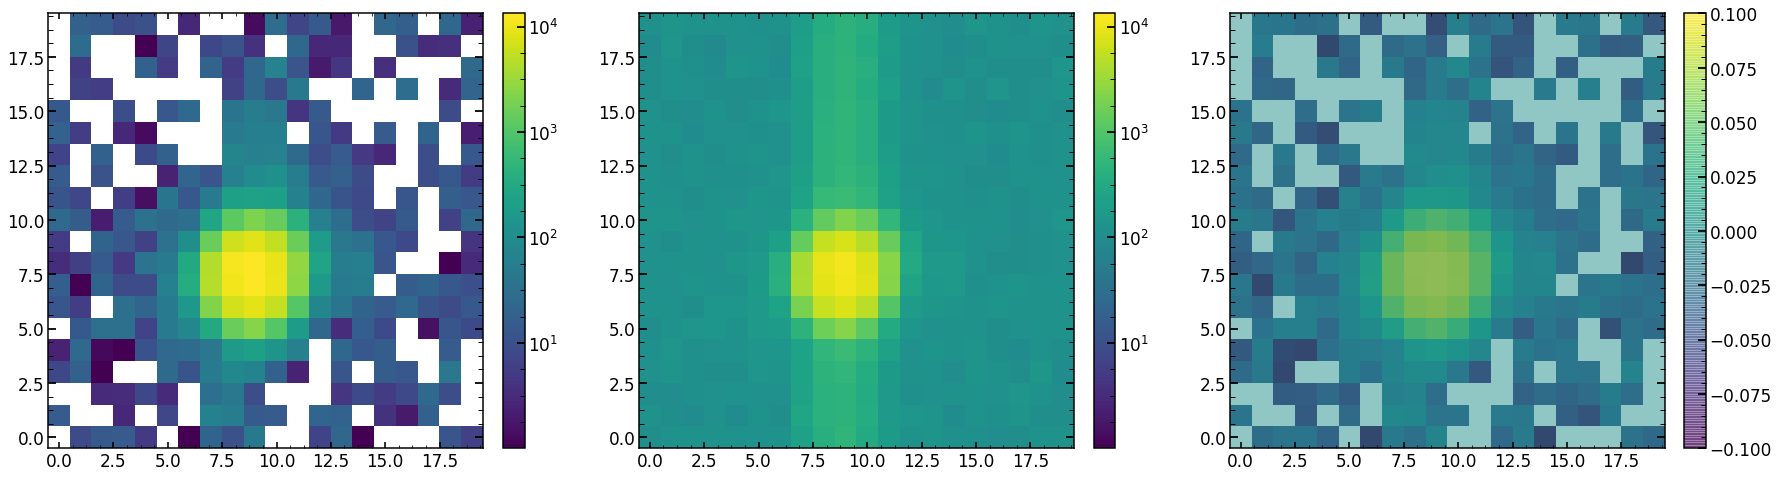

In [444]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [445]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 453.0102496289479
minimal chi2 reduced is: 2.2300801690597445


In [446]:
print(minchain.shape)

if len(minchain)==42:
    columns=columns22
    
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

(42,)
        z4        z5        z6        z7        z8        z9       z10  \
0  0.81692  0.146809 -0.086923  0.409847  0.619815  0.131161 -0.258513   

       z11  
0 -0.06977  
        z12       z13       z14       z15       z16       z17       z18  \
0 -0.109089 -0.105319  0.012515  0.029774 -0.026189  0.023258  0.013827   

        z19      z20       z21  
0  0.018464 -0.03268  0.018536  
        z22   hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.038804  0.693846   0.098155 -0.193379 -0.008705  0.051716     0.056398   

   radiometricEffect  radiometricExponent    x_ilum    ...     frd_sigma  \
0           0.000034             0.000034  0.974913    ...      0.059429   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.608484  0.993059            0.296431   27117.465872   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0          1.869023              0.000299          0.35  1.786824  0.99

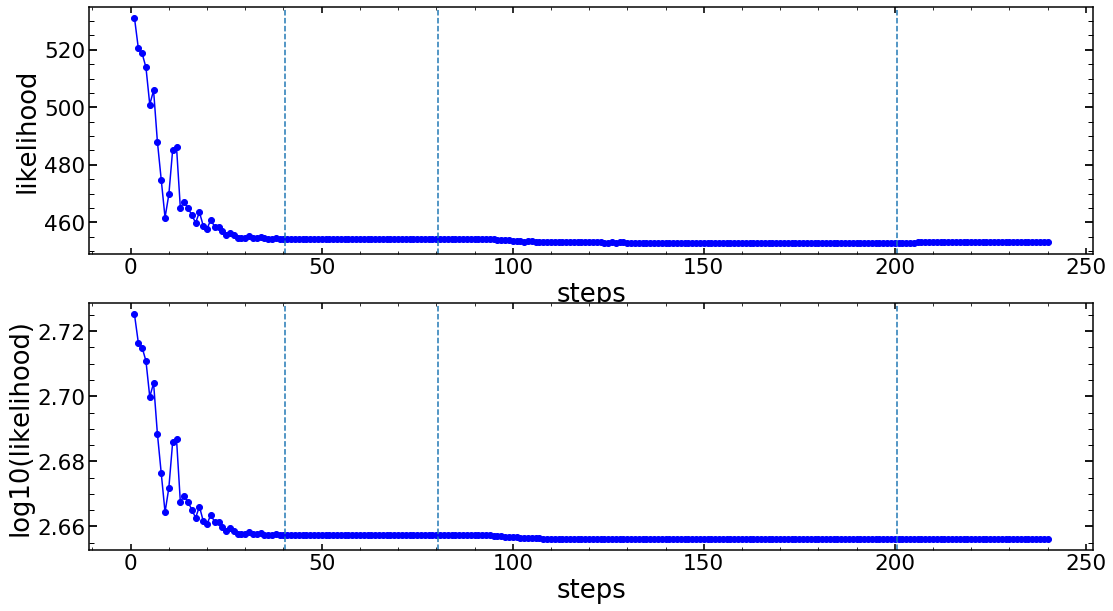

In [447]:
size=chain0_Emcee3.shape[1]
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(5*size+0.5,ls='--')

In [448]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22)   
       
model(minchain)

extraZernike: None
zmax: 22
None


-453.0102496289488

In [449]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')
res_init=np.load(TESTING_FINAL_IMAGES_FOLDER+'res_init.npy')
res=np.load(TESTING_FINAL_IMAGES_FOLDER+'res.npy')


optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

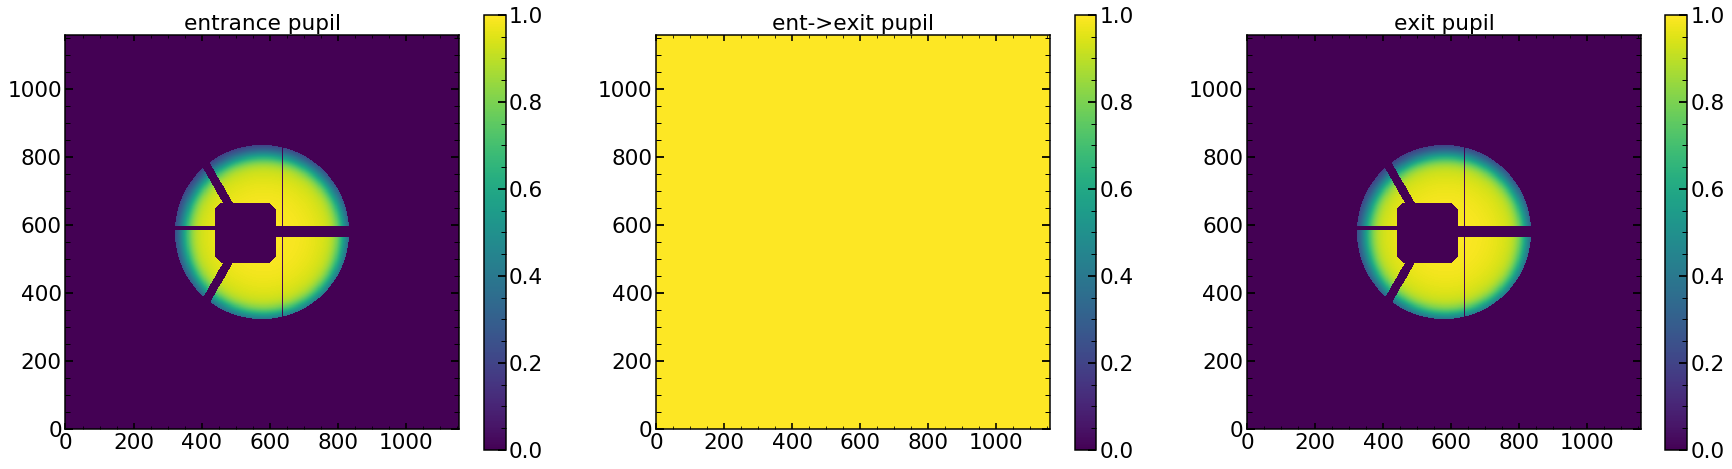

In [450]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

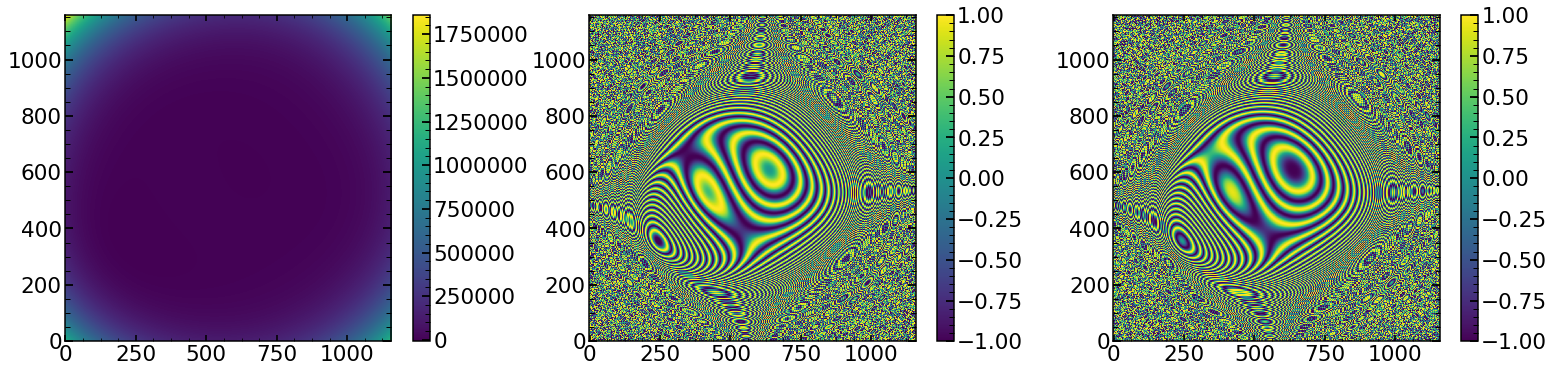

In [451]:
plt.figure(figsize=(36,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

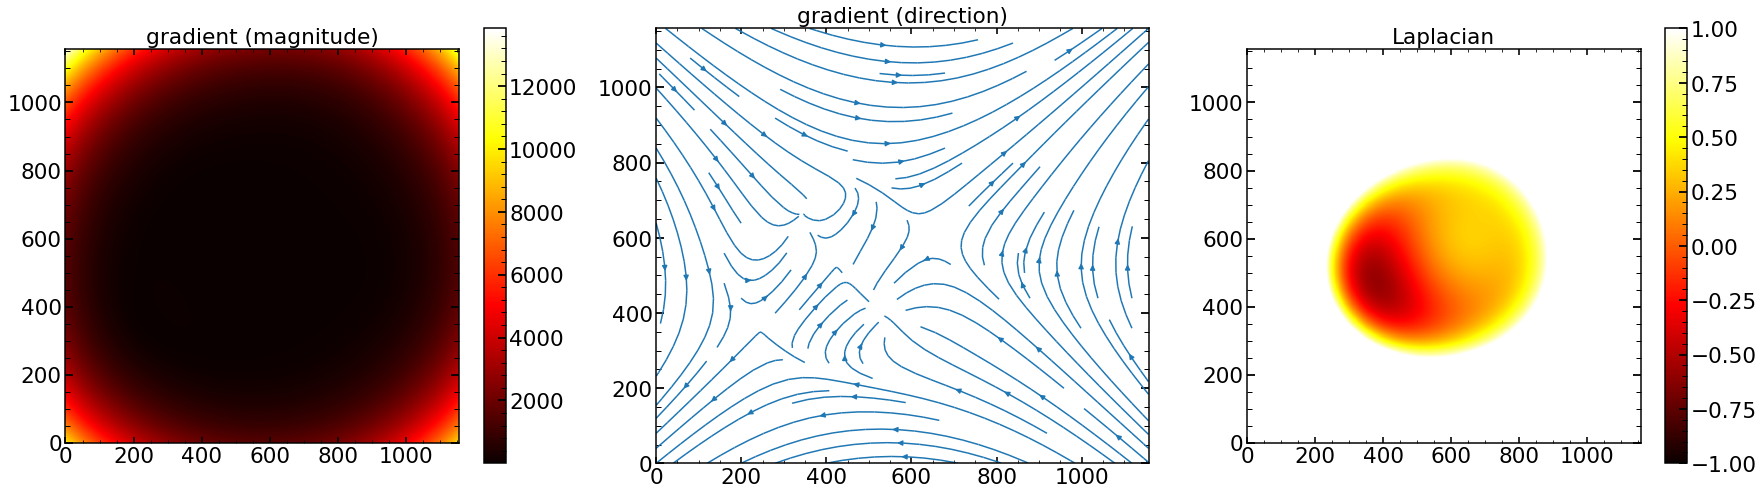

In [452]:
plt.figure(figsize=(30,8))
plt.subplot(131)
vgrad = np.gradient(wf_full)
fulgrad = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
plt.title('gradient (magnitude)')
plt.imshow(fulgrad,cmap=plt.get_cmap('hot'), vmin = np.amin(fulgrad),vmax = np.amax(fulgrad))  
plt.colorbar()
plt.subplot(132)
x, y = range(0, len(wf_full)), range(0,len(wf_full))
xi, yi = np.meshgrid(x, y)
plt.title('gradient (direction)')
plt.streamplot(xi, yi, vgrad[0], vgrad[1])
plt.subplot(133)
laplace_of_wf = scipy.ndimage.filters.laplace(wf_full)
plt.title('Laplacian')
plt.imshow(laplace_of_wf,cmap=plt.get_cmap('hot'), vmin = -1,vmax = 1) 
plt.colorbar()

Text(0.5,1,'Residual')

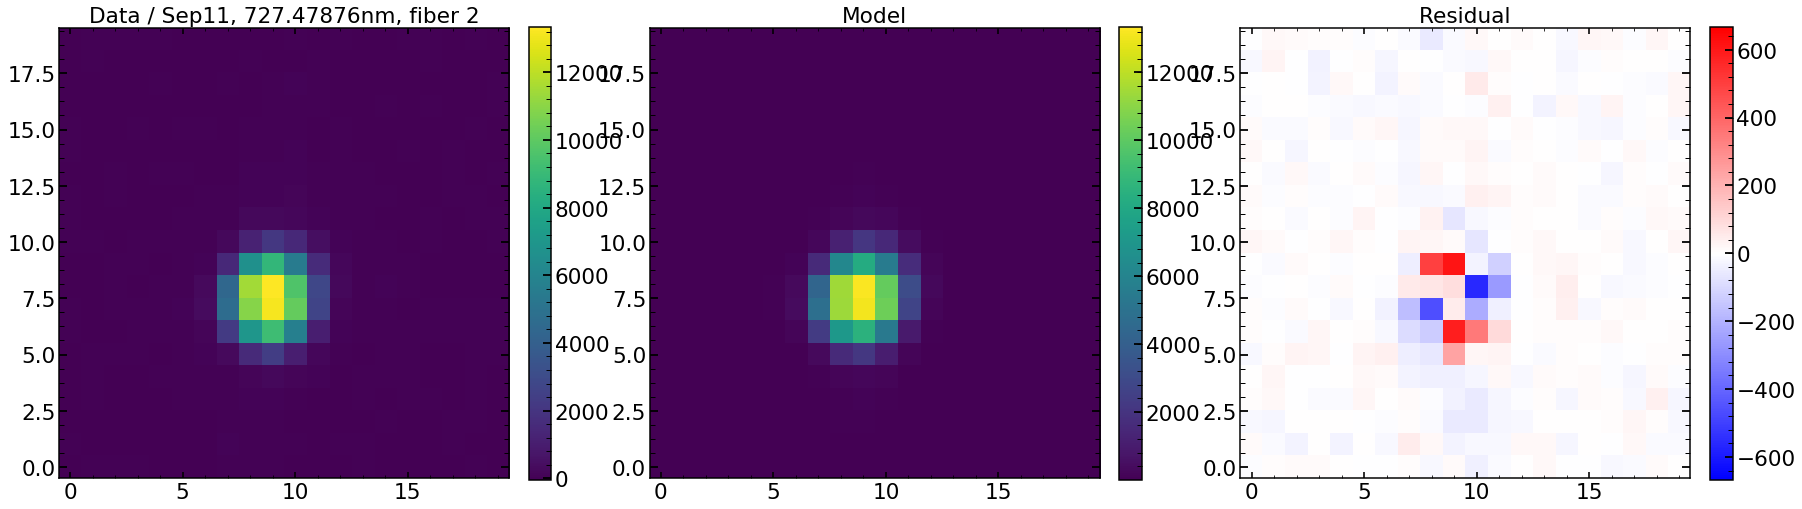

In [453]:
plt.figure(figsize=(30,12))
plt.subplot(1,3,1)
plt.imshow(sci_image,vmax=np.max(sci_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Data / '+str(date)+', '+str(finalArc.loc[int(single_number)]['wavelength'])+'nm, fiber '+str(finalArc.loc[int(single_number)]['fiber']))
plt.subplot(1,3,2)
plt.imshow(res_iapetus,vmax=np.max(sci_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Model')
plt.subplot(1,3,3)
plt.imshow(sci_image-res_iapetus,vmin=-np.max(sci_image)/20,vmax=np.max(sci_image)/20,cmap='bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Residual')

chi**2 reduced is: 2.230080187346028
Abs of residual divided by total flux is: 0.06481440441797746
Abs of residual divided by largest value of a flux in the image is: 0.046342556079398745


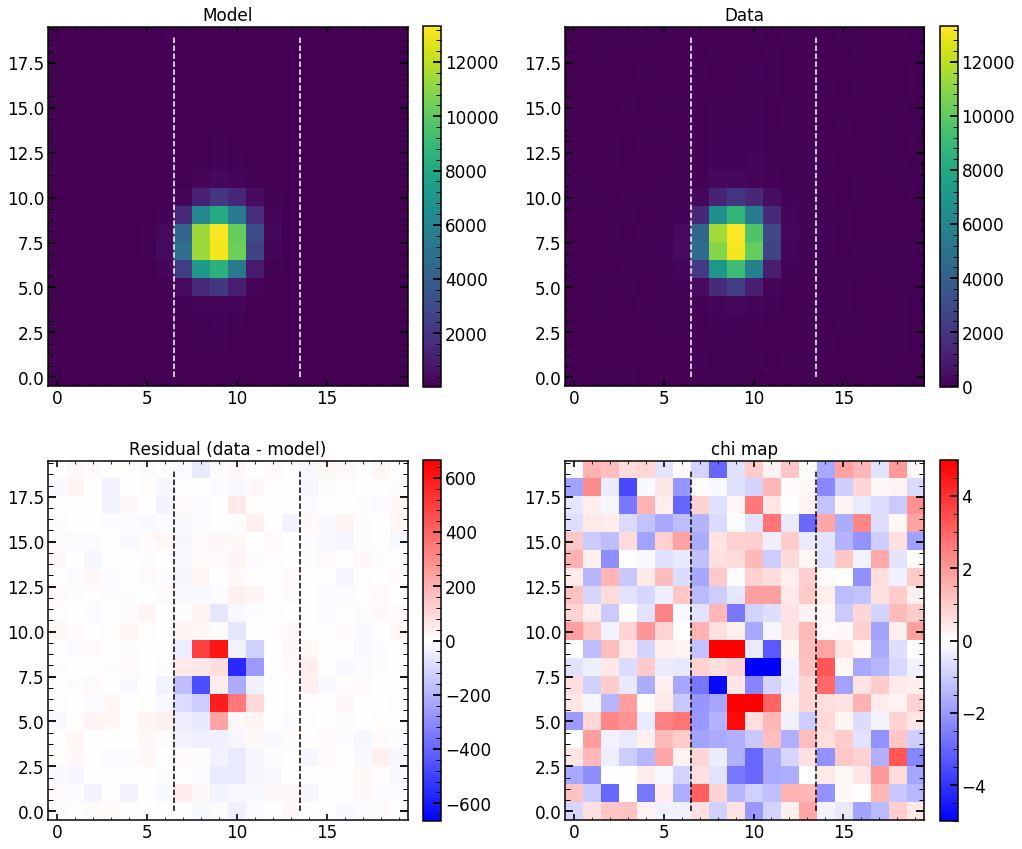

In [454]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

2.230080187346028
chi**2 reduced is: 2.230080187346028
Abs of residual divided by total flux is: 0.06481440441797746
Abs of residual divided by largest value of a flux in the image is: 0.046342556079398745


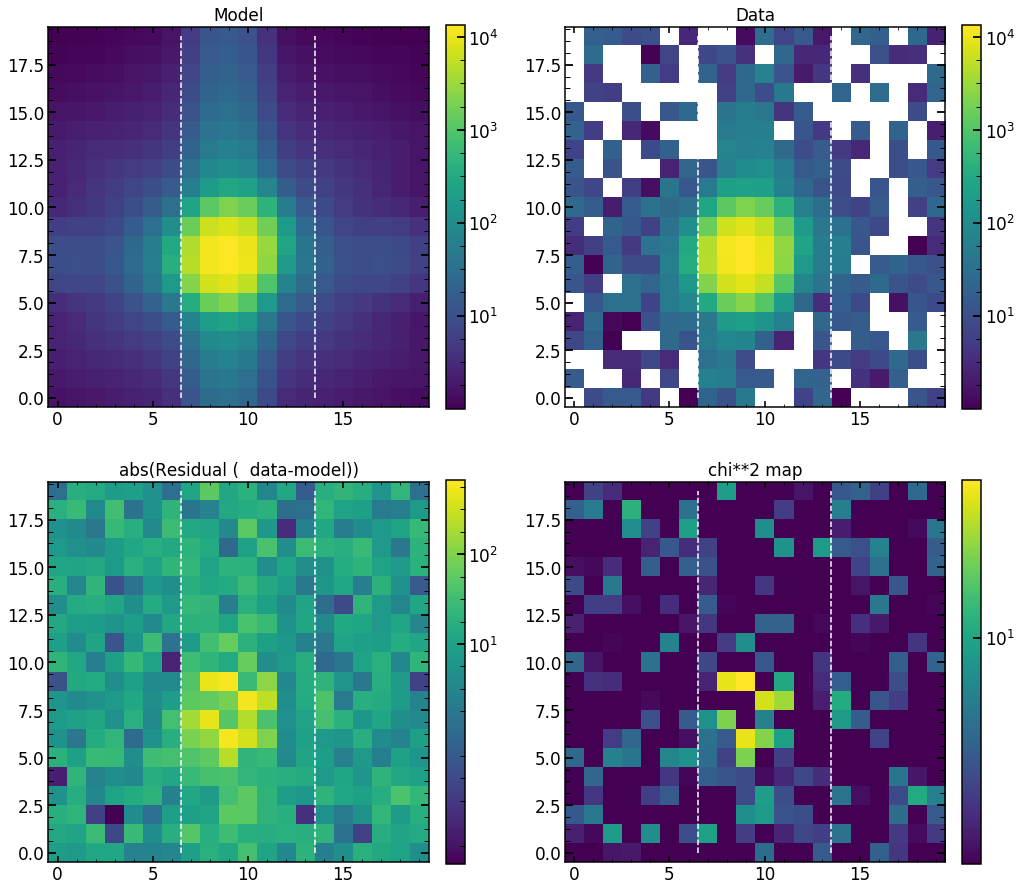

In [455]:
single_analysis.create_basic_comparison_plot_log()

2.230080187346028
chi**2 reduced is: 2.230080187346028
Abs of residual divided by total flux is: 0.06481440441797746
Abs of residual divided by largest value of a flux in the image is: 0.046342556079398745


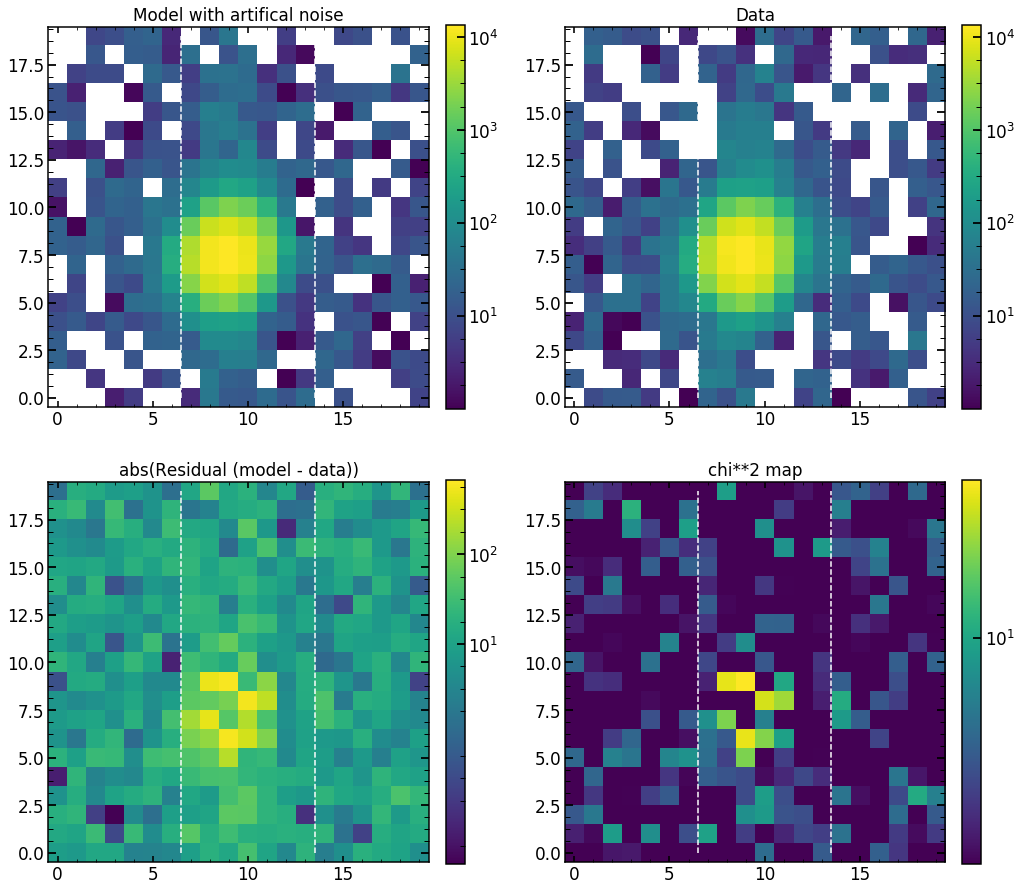

In [456]:
single_analysis.create_basic_comparison_plot_log_artifical()

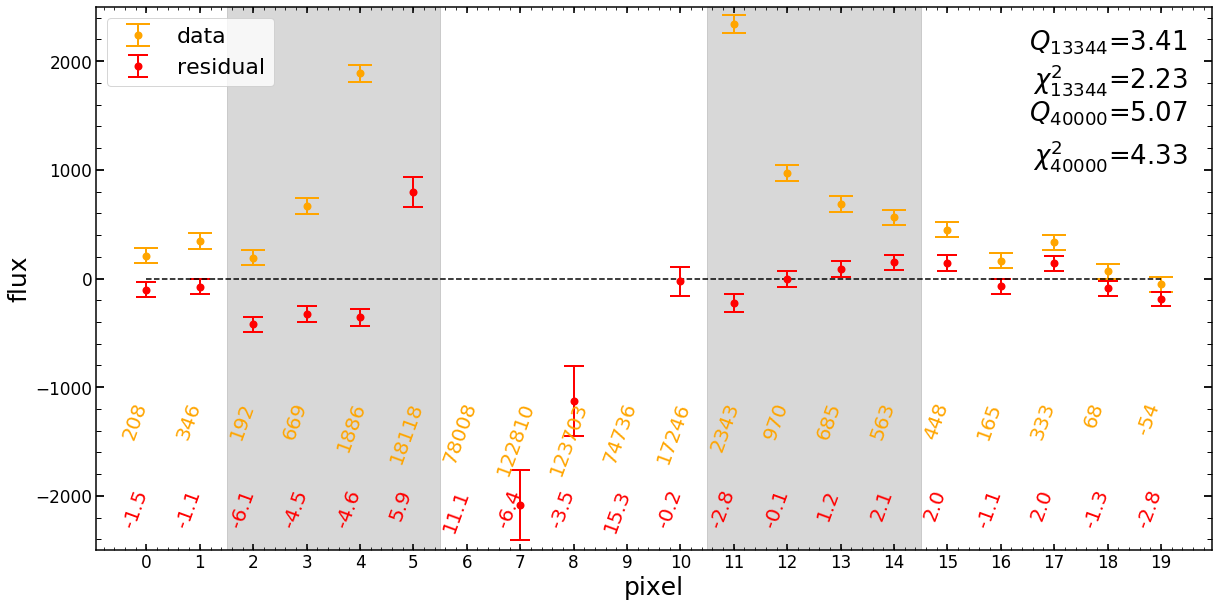

In [457]:
plot_1D_residual(sci_image,var_image,res_iapetus)

## results everywhere 

In [458]:
assert date=='Sep11'

results_of_fit_many_single_focus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                   index=finalHgAr_May2019.index,columns=columns22_analysis)
err_results_of_fit_many_single_focus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                       index=finalHgAr_May2019.index,columns=columns22_analysis)

results_of_fit_many_single_focus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_focus_HgAr)
err_results_of_fit_many_single_focus_HgAr_pd=pd.DataFrame(err_results_of_fit_many_single_focus_HgAr)

#####

results_of_fit_many_single_focus_Ne=pd.DataFrame(np.zeros((len(finalNe_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                 index=finalNe_May2019.index,columns=columns22_analysis)
err_results_of_fit_many_single_focus_Ne=pd.DataFrame(np.zeros((len(finalNe_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                     index=finalNe_May2019.index,columns=columns22_analysis)

results_of_fit_many_single_focus_Ne_pd=pd.DataFrame(results_of_fit_many_single_focus_Ne)
err_results_of_fit_many_single_focus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_focus_Ne)

#####

results_of_fit_many_single_focus_Kr=pd.DataFrame(np.zeros((len(finalKr_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                 index=finalKr_May2019.index,columns=columns22_analysis)
err_results_of_fit_many_single_focus_Kr=pd.DataFrame(np.zeros((len(finalKr_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                     index=finalKr_May2019.index,columns=columns22_analysis)

results_of_fit_many_single_focus_Kr_pd=pd.DataFrame(results_of_fit_many_single_focus_Kr)
err_results_of_fit_many_single_focus_Kr_pd=pd.DataFrame(err_results_of_fit_many_single_focus_Kr)



In [459]:
columns_analysis=columns22_analysis

for single_number in range(len(finalHgAr_May2019)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    create_results_of_fit_single_focus('Sep11',single_number,'HgAr',22,4)
    results_of_fit_many_single_focus_HgAr_pd.loc[single_number]=results_of_fit_single.values  

results_of_fit_many_single_focus_HgAr_pd=results_of_fit_many_single_focus_HgAr_pd[np.abs(results_of_fit_many_single_focus_HgAr_pd['z4'])>0]



for single_number in range(len(finalNe_May2019)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    create_results_of_fit_single_focus('Sep11',single_number,'Ne',22,4)
    results_of_fit_many_single_focus_Ne_pd.loc[single_number]=results_of_fit_single.values  

results_of_fit_many_single_focus_Ne_pd=results_of_fit_many_single_focus_Ne_pd[np.abs(results_of_fit_many_single_focus_Ne_pd['z4'])>0]



for single_number in range(len(finalKr_May2019)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    create_results_of_fit_single_focus('Sep11',single_number,'Kr',22,4)
    results_of_fit_many_single_focus_Kr_pd.loc[single_number]=results_of_fit_single.values  

results_of_fit_many_single_focus_Kr_pd=results_of_fit_many_single_focus_Kr_pd[np.abs(results_of_fit_many_single_focus_Kr_pd['z4'])>0]


22
0 21400 HgAr is NOT found or failed!
22
1 obs (Emcee3): 21400 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z13: failed!
z14: failed!
z16: failed!
z17: failed!
z18: failed!
z19: failed!
z20: failed!
z22: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z13: failed!
z14: failed!
z16: failed!
z17: failed!
z18: failed!
z19: failed!
z20: failed!
z22: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
y_fiber: failed!
effective_radius_illumination: failed!


22
34 21400 HgAr is NOT found or failed!
22
35 obs (Emcee3): 21400 is found!
z5: failed!
z7: failed!
z9: failed!
z10: failed!
z11: failed!
z16: failed!
z21: failed!
z22: failed!
dxFocal: failed!
slitFrac_dy: failed!
effective_radius_illumination: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z7: failed!
z9: failed!
z10: failed!
z11: failed!
z16: failed!
z21: failed!
z22: failed!
dxFocal: failed!
slitFrac_dy: failed!
effective_radius_illumination: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
36 21400 HgAr is NOT found or failed!
22
37 obs (Emcee3): 21400 is found!
z5: failed!
z6: failed!
z7: failed!
z9: failed!
z10: failed!
z11: failed!
z13: failed!
z14: failed!
z15: failed!
z16: failed!
z17: failed!
z18: failed!
z19: failed!
z21: failed!
z22: failed!
hscFrac: failed!
strutFrac: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_ill

z16: failed!
z19: failed!
slitFrac: failed!
slitFrac_dy: failed!
x_ilum: failed!
y_ilum: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
z5: failed!
z6: failed!
z7: failed!
z10: failed!
z16: failed!
z19: failed!
slitFrac: failed!
slitFrac_dy: failed!
x_ilum: failed!
y_ilum: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
22
72 21400 HgAr is NOT found or failed!
22
73 obs (Emcee3): 21400 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z11: failed!
z19: failed!
z20: failed!
z21: failed!
z22: failed!
dxFocal: failed!
radiometricExponent: failed!
x_fiber: failed!
y_fiber: failed!
frd_sigma: failed!
det_vert: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z11: failed!
z19: failed!
z20: failed!
z21: failed!
z22: failed!
dxFocal: failed!
radiometricExponent: failed!
x_fiber: failed!
y_fiber: failed!
frd_sigma: failed!
det_vert: failed!
22
74 21400 HgAr is NOT found or failed!
22
75 obs (Emcee3): 21400 is found!
z5: failed!
z6: failed!
z

z10: failed!
z11: failed!
z12: failed!
z13: failed!
z15: failed!
z17: failed!
z18: failed!
z19: failed!
z20: failed!
z21: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z12: failed!
z13: failed!
z15: failed!
z17: failed!
z18: failed!
z19: failed!
z20: failed!
z21: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
110 21400 HgAr is NOT found or failed!
22
111 obs (Emcee3): 21400 is found!
z7: failed!
z10: failed!
z11:

radiometricExponent: failed!
x_ilum: failed!
x_fiber: failed!
y_fiber: failed!
frd_lorentz_factor: failed!
z5: failed!
z6: failed!
z7: failed!
z10: failed!
z11: failed!
z12: failed!
z14: failed!
z16: failed!
z17: failed!
z18: failed!
z19: failed!
z20: failed!
z21: failed!
z22: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum: failed!
x_fiber: failed!
y_fiber: failed!
frd_lorentz_factor: failed!
22
16 21604 Ne is NOT found or failed!
22
17 21604 Ne is NOT found or failed!
22
18 21604 Ne is NOT found or failed!
22
19 21604 Ne is NOT found or failed!
22
20 obs (Emcee3): 21604 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z10: failed!
z11: failed!
z12: failed!
z14: failed!
z16: failed!
z18: failed!
z19: failed!
z20: failed!
z21: failed!
z22: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum:

slitHolder_frac_dx: failed!
22
42 obs (Emcee3): 21604 is found!
z6: failed!
z8: failed!
z10: failed!
z11: failed!
z13: failed!
z15: failed!
z17: failed!
z18: failed!
z20: failed!
z21: failed!
z22: failed!
hscFrac: failed!
dxFocal: failed!
dyFocal: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z6: failed!
z8: failed!
z10: failed!
z11: failed!
z13: failed!
z15: failed!
z17: failed!
z18: failed!
z20: failed!
z21: failed!
z22: failed!
hscFrac: failed!
dxFocal: failed!
dyFocal: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
43 21604 Ne is NOT found or failed!
22
44 21604 Ne is NOT found or failed!
22
45 21604 Ne is NOT found or failed!
22
46 21604 Ne is NOT found or failed!
22
47 obs (Emcee3): 21604 is found!
z5: failed!
z7: failed!
z8: failed!
z10: failed!
z11: failed!
z12: failed!
z13: 

x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
69 obs (Emcee3): 21604 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z10: failed!
z12: failed!
z13: failed!
z14: failed!
z15: failed!
z17: failed!
z19: failed!
z20: failed!
z21: failed!
z22: failed!
hscFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z10: failed!
z12: failed!
z13: failed!
z14: failed!
z15: failed!
z17: failed!
z19: failed!
z20: failed!
z21: failed!
z22: failed!
hscFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_rad

z14: failed!
z17: failed!
z20: failed!
z21: failed!
hscFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
4 21808 Kr is NOT found or failed!
22
5 21808 Kr is NOT found or failed!
22
6 21808 Kr is NOT found or failed!
22
7 obs (Emcee3): 21808 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z12: failed!
z13: failed!
z15: failed!
z18: failed!
z19: failed!
z20: failed!
z22: failed!
dxFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z12: failed!
z13

In [460]:
pd.set_option("display.max_rows",10)
results_of_fit_many_single_focus_HgAr_pd

z4        z5        z6        z7        z8        z9       z10  \
1    0.981073  0.229186 -0.124379  0.518521  0.703294  0.208391 -0.289421   
3    0.816920  0.146809 -0.086923  0.409847  0.619815  0.131161 -0.258513   
9    0.755941 -0.890157 -0.351210 -0.239151  0.467041 -0.263636 -0.306762   
11   0.710105 -1.031412 -0.534415 -0.438688  0.354771 -0.415755 -0.481468   
15   0.533049  0.199601 -0.130683  0.426529  0.427009  0.031598 -0.269928   
..        ...       ...       ...       ...       ...       ...       ...   
109  0.628077 -0.537002 -0.191967  0.529125 -1.171903  0.207171 -0.253985   
111  0.332238 -0.493293 -0.030075  0.410090 -1.119162  0.121038 -0.323196   
114 -0.453194 -0.096895 -0.013681  0.141132 -1.083800 -0.060733 -0.450093   
117  0.650819  0.319002 -0.382798 -0.252933 -1.002193 -0.366609 -0.437730   
119  0.698322  0.252816 -0.594102 -0.290760 -0.760332 -0.504496 -0.166708   

          z11       z12       z13     ...       det_vert  slitHolder_frac_dx  \
1    0.003539 -0.093482 -0.128677     ...       0.996251            0.409946   
3   -0.069770 -0.109089 -0.105319     ...       0.993059            0.296431   
9    0.193244 -0.068371  0.163968     ...       1.025168            0.459537   
11   0.527698  0.016194  0.264570     ...       1.055453            0.563795   
15  -0.221096 -0.114427 -0.076418     ...       1.014031            0.499166   
..        ...       ...       ...     ...            ...                 ...   
109  0.047261 -0.103645  0.120608     ...       0.999765           -0.220758   
111 -0.023725 -0.143747  0.089539     ...       0.993435           -0.218552   
114 -0.107186 -0.191983 -0.015307     ...       0.988772           -0.237174   
117  0.256140 -0.111129 -0.188530     ...       1.004879           -0.250646   
119  0.515410  0.008977 -0.272750     ...       1.047563           -0.363982   

     grating_lines  scattering_slope  scattering_amplitude  pixel_effect  \
1     39594.667047          1.670609              0.000270      0.350000   
3     27117.465872          1.869023              0.000299      0.350000   
9     56001.701687          2.621149              0.004281      0.393098   
11    24747.016291          2.363598              0.004672      0.510098   
15    38158.839561          2.362207              0.001577      0.350000   
..             ...               ...                   ...           ...   
109   37402.993907          2.069095              0.000839      0.350000   
111   31800.055868          2.795194              0.003608      0.350000   
114   41315.517553          2.264882              0.001167      0.353675   
117   44944.916868          1.998068              0.000866      0.350000   
119   22015.630328          2.146572              0.002119      0.436674   

      fiber_r      flux       chi2      chi2max  
1    1.780269  0.999708   4.954112  1497.676758  
3    1.786824  0.997576   2.265051   421.042938  
9    1.802812  0.996440  29.355285  7256.720215  
11   1.815556  0.996404   2.680404   380.818909  
15   1.800892  0.998448   1.658576   404.064453  
..        ...       ...        ...          ...  
109  1.819995  0.998506   3.812683   950.557983  
111  1.836696  0.996232   1.699416   259.595886  
114  1.835023  0.996768   4.280580   802.067261  
117  1.785838  0.991448  37.259842  3958.158203  
119  1.899350  0.989482   2.788700   189.604843  

[37 rows x 44 columns]

In [461]:
pd.set_option("display.max_rows",10)
results_of_fit_many_single_focus_Ne_pd

z4        z5        z6        z7        z8        z9       z10  \
2   1.269528  0.389996 -0.336865  0.664242  0.770035  0.293300 -0.475283   
5   0.947503  0.354422 -0.200863  0.491898  0.634117  0.199075 -0.361970   
6   0.853453  0.093824  0.026214  0.478738  0.690395  0.196119 -0.300303   
11  0.908534  0.407513 -0.343117  0.785316  0.584157  0.105368 -0.404717   
14  0.626571  0.318237 -0.276660  0.609653  0.423398  0.071286 -0.367846   
..       ...       ...       ...       ...       ...       ...       ...   
77  0.198463 -0.675486 -0.200469  0.605215 -0.955313  0.041176 -0.184298   
78  0.068712 -0.615753 -0.138160  0.498903 -0.932844 -0.004947 -0.248882   
83  0.914895 -0.598108 -0.335059  0.659256 -1.196059  0.290786 -0.071396   
86  0.730876 -0.514866 -0.241263  0.611516 -1.184972  0.211638 -0.230739   
87  0.313625 -0.511409 -0.111675  0.456509 -1.177333  0.132473 -0.300512   

         z11       z12       z13     ...       det_vert  slitHolder_frac_dx  \
2   0.165949 -0.047170 -0.151870     ...       1.014495            0.499898   
5  -0.003010 -0.084836 -0.162665     ...       1.004852            0.419944   
6  -0.128991 -0.140287 -0.138572     ...       0.995888            0.537360   
11  0.017343 -0.071407 -0.125270     ...       1.026683            0.501985   
14 -0.133617 -0.082591 -0.093824     ...       1.011140            0.529297   
..       ...       ...       ...     ...            ...                 ...   
77 -0.104348 -0.072819  0.111456     ...       1.014902           -0.250299   
78 -0.184689 -0.097723  0.085806     ...       0.999952           -0.249730   
83  0.207337 -0.082770  0.154004     ...       1.009586           -0.226352   
86  0.038950 -0.135436  0.122138     ...       1.000181           -0.214226   
87  0.019577 -0.126572  0.089440     ...       0.990365           -0.243261   

    grating_lines  scattering_slope  scattering_amplitude  pixel_effect  \
2    41683.719501          2.040225              0.000892      0.350000   
5    44361.289056          2.206416              0.001363      0.350000   
6    32049.262626          1.728851              0.000417      0.350000   
11   54034.275281          1.974807              0.000808      0.350000   
14   58938.478334          2.238389              0.001652      0.365448   
..            ...               ...                   ...           ...   
77   54381.168298          2.155498              0.001545      0.368005   
78   50392.597142          1.942270              0.000983      0.371236   
83   39827.238387          2.070544              0.001197      0.356649   
86   44060.577482          2.222730              0.001752      0.350000   
87   35892.494262          1.927761              0.000800      0.350000   

     fiber_r      flux       chi2      chi2max  
2   1.803128  0.998589   9.588973  5628.119141  
5   1.809354  0.998110  20.906091  9602.761719  
6   1.781783  0.997011   7.167878  2000.132202  
11  1.805246  0.999175   6.957248  5287.791016  
14  1.818909  0.999214   9.597874  9150.757812  
..       ...       ...        ...          ...  
77  1.814209  0.998960   9.041637  6583.294922  
78  1.814335  0.998494   3.017366  1382.410034  
83  1.805759  0.997752   9.450899  3651.568115  
86  1.811620  0.997435  17.314184  6080.844238  
87  1.833723  0.997364   3.965456  1245.952393  

[29 rows x 44 columns]

In [462]:
pd.set_option("display.max_rows",10)
results_of_fit_many_single_focus_Kr_pd

z4        z5        z6        z7        z8        z9       z10  \
3   0.520368 -0.878538 -0.301369 -0.163431  0.460205 -0.263289 -0.258688   
7   0.433898 -0.869982 -0.293721 -0.102733  0.291767 -0.173738 -0.272514   
15 -0.025423 -0.628821 -0.484548  0.016698 -0.056908 -0.129735 -0.340153   
19 -0.280359 -0.452825 -0.581586  0.070680 -0.128927 -0.118827 -0.338270   
23 -0.224233 -0.236273 -0.660350  0.100718 -0.173712 -0.120246 -0.335989   
27 -0.071846  0.076659 -0.589404  0.065956 -0.328860 -0.136188 -0.337249   
31  0.261142  0.305265 -0.552981 -0.060255 -0.491298 -0.145110 -0.350430   
35  0.120917  0.331870 -0.194221 -0.006329 -0.842145 -0.386111 -0.384990   
39  0.670156  0.314647 -0.382951 -0.225861 -0.942421 -0.315274 -0.405048   

         z11       z12       z13     ...       det_vert  slitHolder_frac_dx  \
3   0.190696 -0.090048  0.149391     ...       1.022906            0.421434   
7  -0.082958 -0.074963  0.135010     ...       1.032533            0.494379   
15 -0.183061 -0.025390  0.057570     ...       1.038668            0.247275   
19 -0.231443  0.010920  0.031633     ...       1.046391            0.153316   
23 -0.288793  0.002240 -0.004188     ...       1.043711            0.043076   
27 -0.295236 -0.020235 -0.039667     ...       1.047158           -0.136742   
31 -0.257810 -0.022500 -0.062281     ...       1.038790           -0.267470   
35  0.030434 -0.051427 -0.100886     ...       1.023057           -0.314248   
39  0.097468 -0.133748 -0.185792     ...       1.007849           -0.221763   

    grating_lines  scattering_slope  scattering_amplitude  pixel_effect  \
3    67453.405099          2.343201              0.001782      0.363422   
7    68360.005788          2.401512              0.002154      0.374221   
15   67909.232919          2.397595              0.002104      0.420716   
19   63087.687677          2.497154              0.002710      0.409831   
23   58402.236542          2.330164              0.001829      0.420302   
27   62158.973578          2.222094              0.001421      0.419486   
31   57295.227955          2.233608              0.001436      0.381801   
35   53404.172468          1.500000              0.000122      0.350000   
39   92941.601657          2.054436              0.001278      0.350000   

     fiber_r      flux       chi2      chi2max  
3   1.810707  0.995789  11.700004  2451.220947  
7   1.827453  0.995492  13.084295  2560.378662  
15  1.827749  0.994524  17.706492  3034.321777  
19  1.837644  0.995080  14.499042  2684.949463  
23  1.797384  0.995340  10.989205  2169.526367  
27  1.819408  0.995675  10.840685  2273.532715  
31  1.825285  0.995906   9.302036  2207.657471  
35  1.811592  0.990052  15.042260  1767.964111  
39  1.794155  0.991400  13.550723  1364.189697  

[9 rows x 44 columns]

In [463]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_HgAr_from_Sep11.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_single_focus_HgAr_pd,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_Ne_from_Sep11.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_single_focus_Ne_pd,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_Kr_from_Sep11.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_single_focus_Kr_pd,f, protocol=pickle.HIGHEST_PROTOCOL)

# Sep 12 (focus, from interpolation)

## Scripts

In [408]:
list_of_HgAr_to_analyze=finalHgAr_May2019.index[(finalHgAr_May2019['fiber'].values.astype(int)<=650)&(finalHgAr_May2019['fiber'].values.astype(int)>=2)
                                        &(finalHgAr_May2019['close'].values.astype(int)==1)]
print(len(list_of_HgAr_to_analyze))

list_of_Ne_to_analyze=finalNe_May2019.index[(finalNe_May2019['fiber'].values.astype(int)<=650)&(finalNe_May2019['fiber'].values.astype(int)>=2)
                                        &(finalNe_May2019['close'].values.astype(int)==1)]
print(len(list_of_Ne_to_analyze))

list_of_Kr_to_analyze=finalKr_May2019.index[(finalKr_May2019['fiber'].values.astype(int)<=650)&(finalKr_May2019['fiber'].values.astype(int)>=2)
                                        &(finalKr_May2019['close'].values.astype(int)==1)]
print(len(list_of_Kr_to_analyze))


50
40
10


In [409]:
list_of_HgAr_to_analyze_10=np.array_split(np.array(list_of_HgAr_to_analyze),10)
print(len(list_of_HgAr_to_analyze_10[0]))
list_of_Ne_to_analyze_10=np.array_split(np.array(list_of_Ne_to_analyze),8)
print(len(list_of_Ne_to_analyze_10[0]))
list_of_Kr_to_analyze_10=np.array_split(np.array(list_of_Kr_to_analyze),2)
print(len(list_of_Kr_to_analyze_10[0]))

5
5
5


In [119]:
#MPI
for i in range(len(list_of_HgAr_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T04'+str(i)+'Sep_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_HgAr_to_analyze_10[i]:
        for obs in [str(21346+54)]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI02_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 HgAr 4\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SepScriptToSubmitScriptsTiger04_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(len(list_of_HgAr_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T04'+str(i)+'Sep_focus.sh \n')

file.close()

#MPI
for i in range(len(list_of_Ne_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T05'+str(i)+'Sep_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_Ne_to_analyze_10[i]:
        for obs in [str(21550 +54)]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI02_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 Ne 4\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SepScriptToSubmitScriptsTiger05_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(len(list_of_Ne_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T05'+str(i)+'Sep_focus.sh \n')

file.close()

#MPI
for i in range(len(list_of_Kr_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T06'+str(i)+'Sep_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_Kr_to_analyze_10[i]:
        for obs in [str(21754  +54)]:
            file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Sep_MPI02_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 Kr 4\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/SepScriptToSubmitScriptsTiger06_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(len(list_of_Kr_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T06'+str(i)+'Sep_focus.sh \n')

file.close()

## which images are avaliable 

In [410]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
finalNe=finalNe_May2019

In [411]:
import glob
date='Sep12'
Emcee3_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5NeEmcee3.npy', recursive=True)
Emcee3_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5HgArEmcee3.npy', recursive=True)
Emcee3_Kr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5KrEmcee3.npy', recursive=True)

In [412]:
analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][90:len(Emcee3_Ne[0])-13]
    analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:])])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_HgAr_images=[]
for i in range(len(Emcee3_HgAr)):
    single_string=Emcee3_HgAr[i][90:len(Emcee3_HgAr[i])-15]
    analyzed_HgAr_images.append([int(single_string[:5]),int(single_string[5:])])
 

analyzed_HgAr_images=np.array(analyzed_HgAr_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][90:len(Emcee3_Kr[i])-13]
    analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:])])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [413]:
arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]

arranged_by_defocus_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,0].argsort()]
arranged_by_spot_number_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,1].argsort()]

arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]

In [414]:
print(len(arranged_by_defocus_HgAr))
print(len(arranged_by_defocus_Ne))
print(len(arranged_by_defocus_Kr))

46
31
9


In [415]:
arranged_by_spot_number_HgAr

array([[21400,     1],
       [21400,     3],
       [21400,     6],
       [21400,     9],
       [21400,    11],
       [21400,    13],
       [21400,    15],
       [21400,    18],
       [21400,    21],
       [21400,    23],
       [21400,    25],
       [21400,    27],
       [21400,    30],
       [21400,    33],
       [21400,    35],
       [21400,    37],
       [21400,    39],
       [21400,    42],
       [21400,    45],
       [21400,    47],
       [21400,    49],
       [21400,    51],
       [21400,    54],
       [21400,    57],
       [21400,    59],
       [21400,    61],
       [21400,    73],
       [21400,    75],
       [21400,    78],
       [21400,    81],
       [21400,    83],
       [21400,    85],
       [21400,    87],
       [21400,    90],
       [21400,    93],
       [21400,    95],
       [21400,    97],
       [21400,    99],
       [21400,   102],
       [21400,   105],
       [21400,   107],
       [21400,   109],
       [21400,   111],
       [214

## single analysis 

In [464]:

date='Sep12'
obs=21400
single_number='3'
image_index=int(single_number)
eps=5
arc='HgAr'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
        
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]

0d


fiber                            2
xc                              71
yc                            1229
wavelength               727.47876
close                            1
lamp                          HgAr
xc_effective                    71
old_index_approx                 3
superold_index_approx          nan
Name: 3, dtype: object

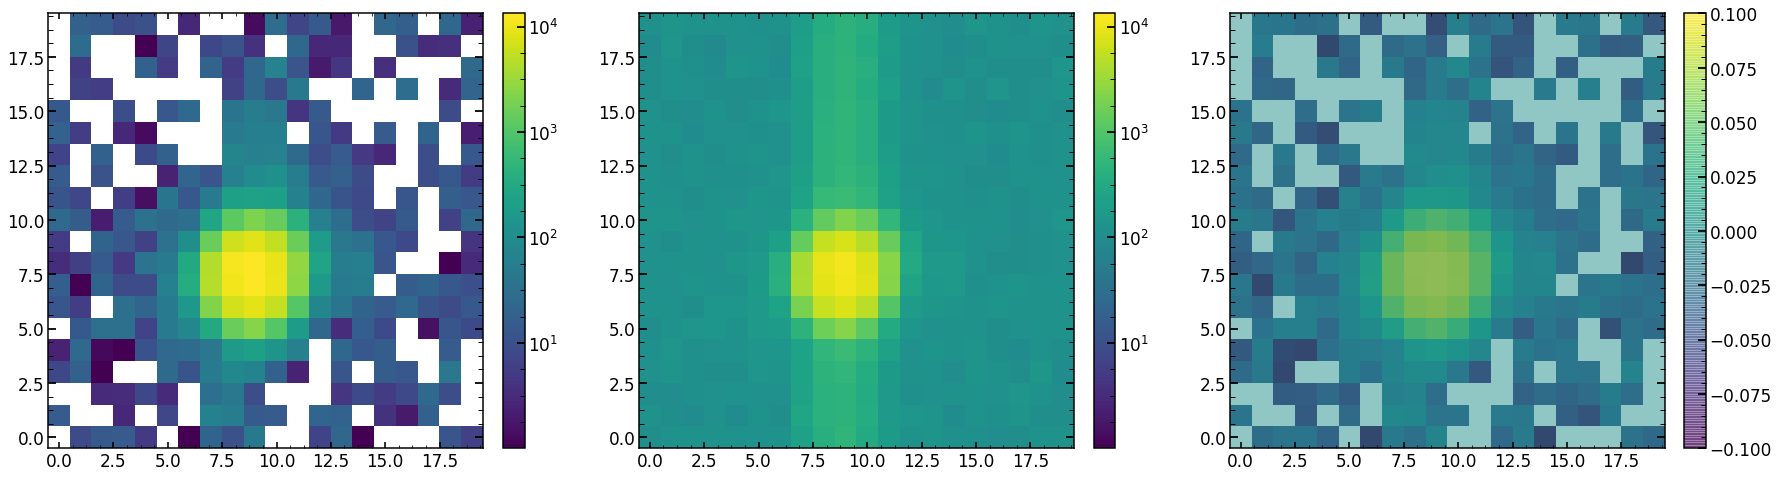

In [465]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [466]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 434.4314171458544
minimal chi2 reduced is: 2.137186006644277


In [467]:
print(minchain.shape)

if len(minchain)==42:
    columns=columns22
    
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

(42,)
         z4        z5        z6        z7        z8        z9       z10  \
0  0.876482  0.245801  0.007635  0.388224  0.547178 -0.012802 -0.265273   

        z11  
0 -0.061185  
        z12       z13       z14      z15       z16       z17       z18  \
0 -0.140575 -0.108887  0.005784  0.01848 -0.027861  0.015762  0.000078   

        z19       z20       z21  
0 -0.002654 -0.028059  0.020809  
       z22  hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.02821  0.69129     0.0958 -0.190082 -0.013319  0.052388     0.059814   

   radiometricEffect  radiometricExponent    x_ilum    ...     frd_sigma  \
0           0.000031             0.000031  0.974918    ...      0.058437   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.633215  0.989778            0.460338   27099.976724   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0           2.18786                0.0007          0.35  1.795669  0.99

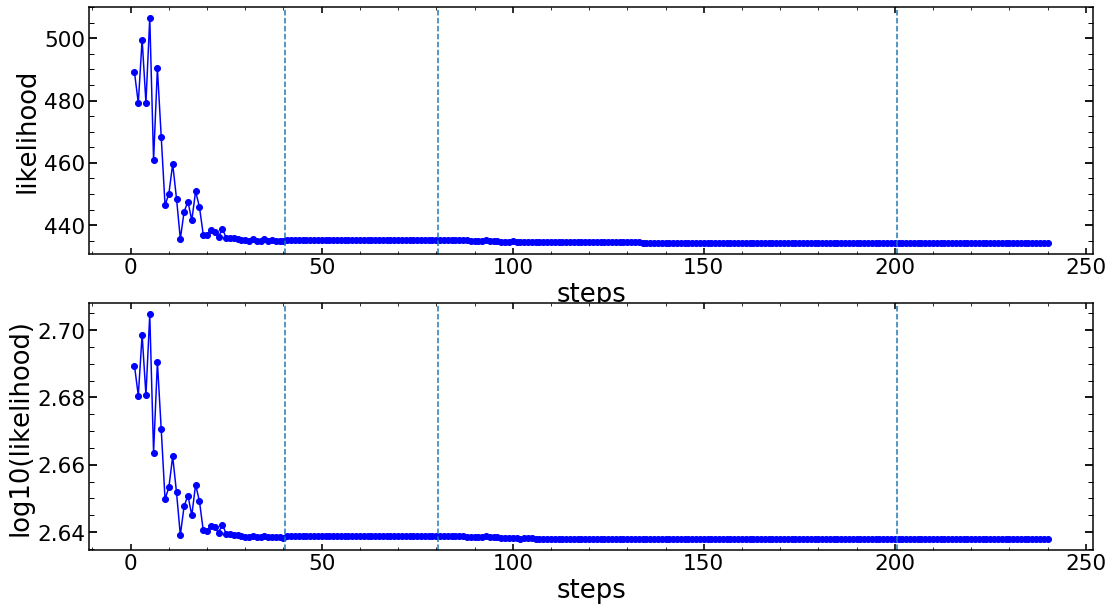

In [468]:
size=chain0_Emcee3.shape[1]
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(5*size+0.5,ls='--')

In [469]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22)   
       
model(minchain)

extraZernike: None
zmax: 22
None


-434.4314172558831

In [470]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')
res_init=np.load(TESTING_FINAL_IMAGES_FOLDER+'res_init.npy')
res=np.load(TESTING_FINAL_IMAGES_FOLDER+'res.npy')


optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

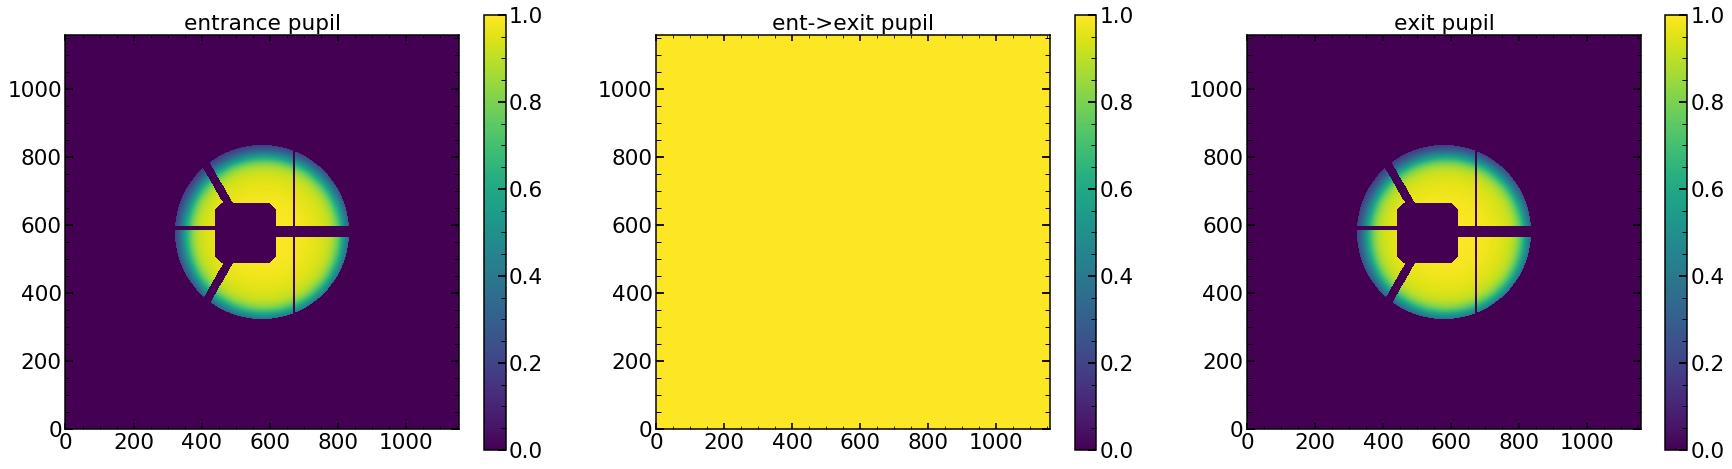

In [471]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

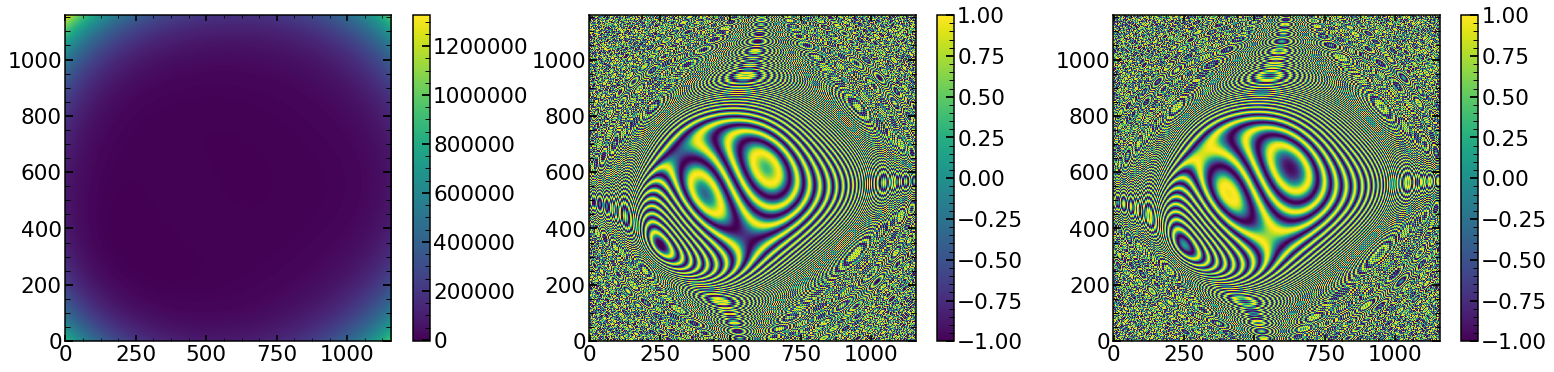

In [472]:
plt.figure(figsize=(36,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

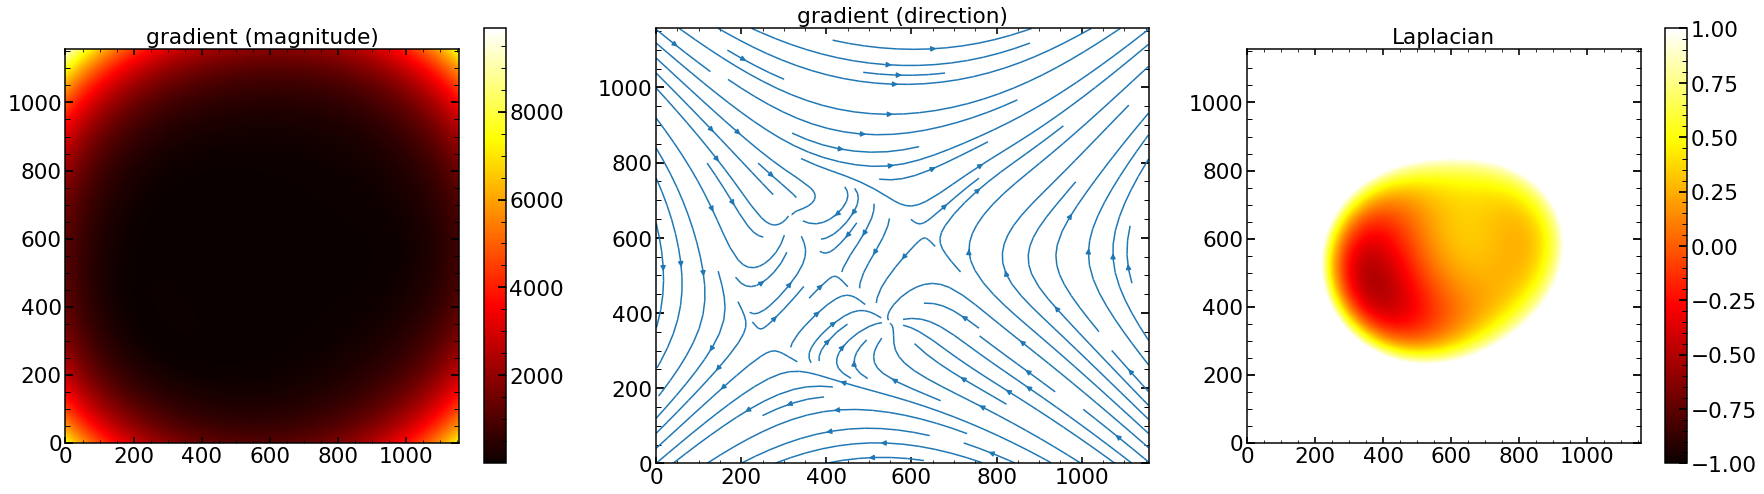

In [473]:
plt.figure(figsize=(30,8))
plt.subplot(131)
vgrad = np.gradient(wf_full)
fulgrad = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
plt.title('gradient (magnitude)')
plt.imshow(fulgrad,cmap=plt.get_cmap('hot'), vmin = np.amin(fulgrad),vmax = np.amax(fulgrad))  
plt.colorbar()
plt.subplot(132)
x, y = range(0, len(wf_full)), range(0,len(wf_full))
xi, yi = np.meshgrid(x, y)
plt.title('gradient (direction)')
plt.streamplot(xi, yi, vgrad[0], vgrad[1])
plt.subplot(133)
laplace_of_wf = scipy.ndimage.filters.laplace(wf_full)
plt.title('Laplacian')
plt.imshow(laplace_of_wf,cmap=plt.get_cmap('hot'), vmin = -1,vmax = 1) 
plt.colorbar()

Text(0.5,1,'Residual')

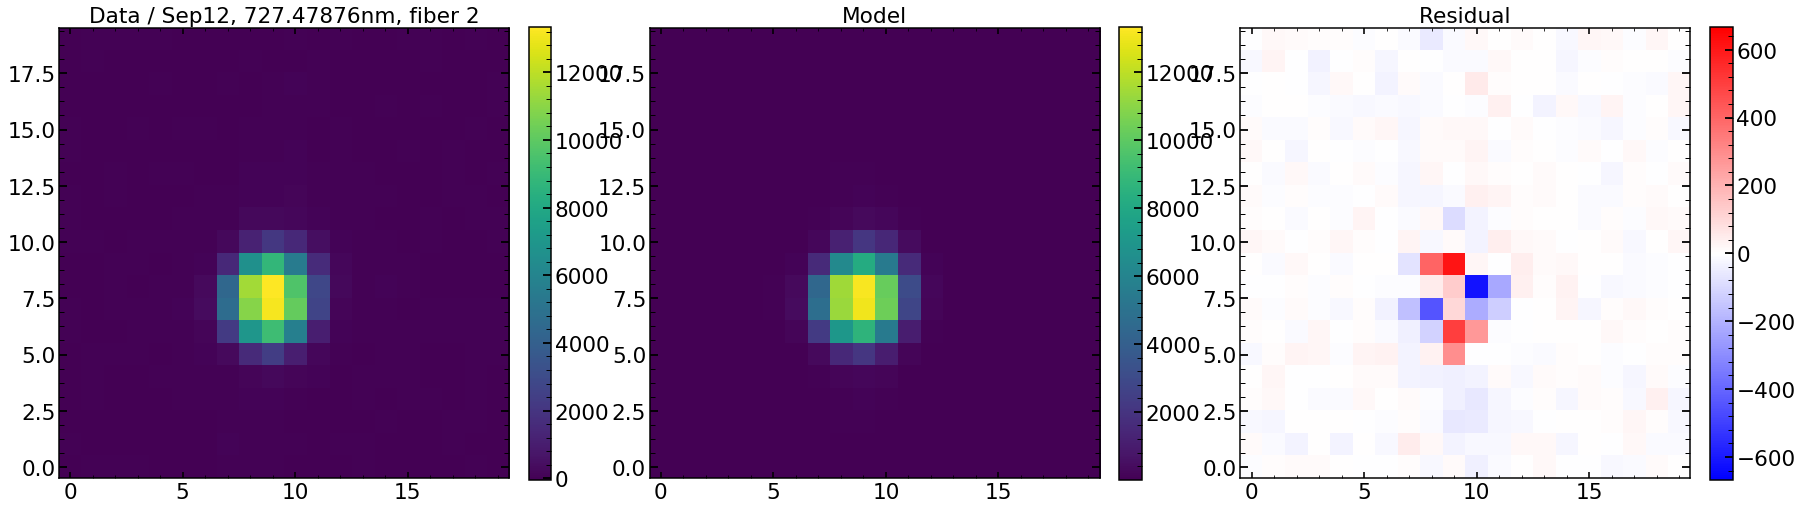

In [474]:
plt.figure(figsize=(30,12))
plt.subplot(1,3,1)
plt.imshow(sci_image,vmax=np.max(sci_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Data / '+str(date)+', '+str(finalArc.loc[int(single_number)]['wavelength'])+'nm, fiber '+str(finalArc.loc[int(single_number)]['fiber']))
plt.subplot(1,3,2)
plt.imshow(res_iapetus,vmax=np.max(sci_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Model')
plt.subplot(1,3,3)
plt.imshow(sci_image-res_iapetus,vmin=-np.max(sci_image)/20,vmax=np.max(sci_image)/20,cmap='bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Residual')

chi**2 reduced is: 2.137186036200369
Abs of residual divided by total flux is: 0.06228802051922978
Abs of residual divided by largest value of a flux in the image is: 0.0468395965238845


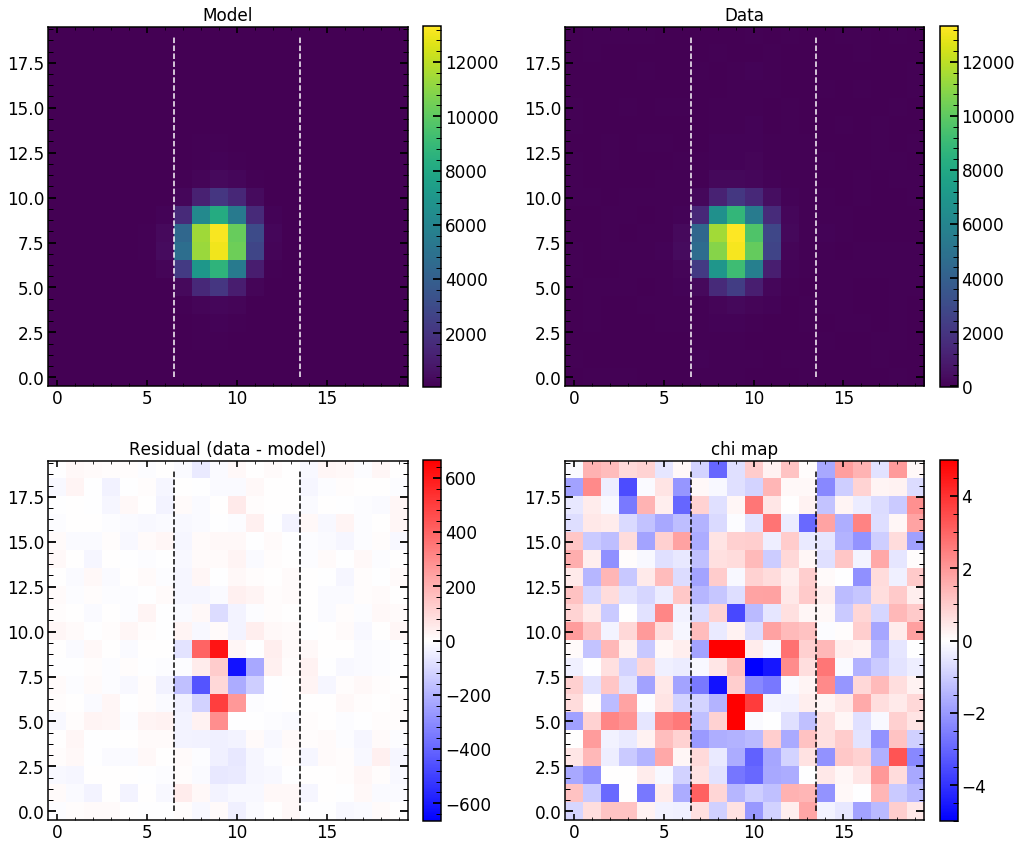

In [475]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

2.137186036200369
chi**2 reduced is: 2.137186036200369
Abs of residual divided by total flux is: 0.06228802051922978
Abs of residual divided by largest value of a flux in the image is: 0.0468395965238845


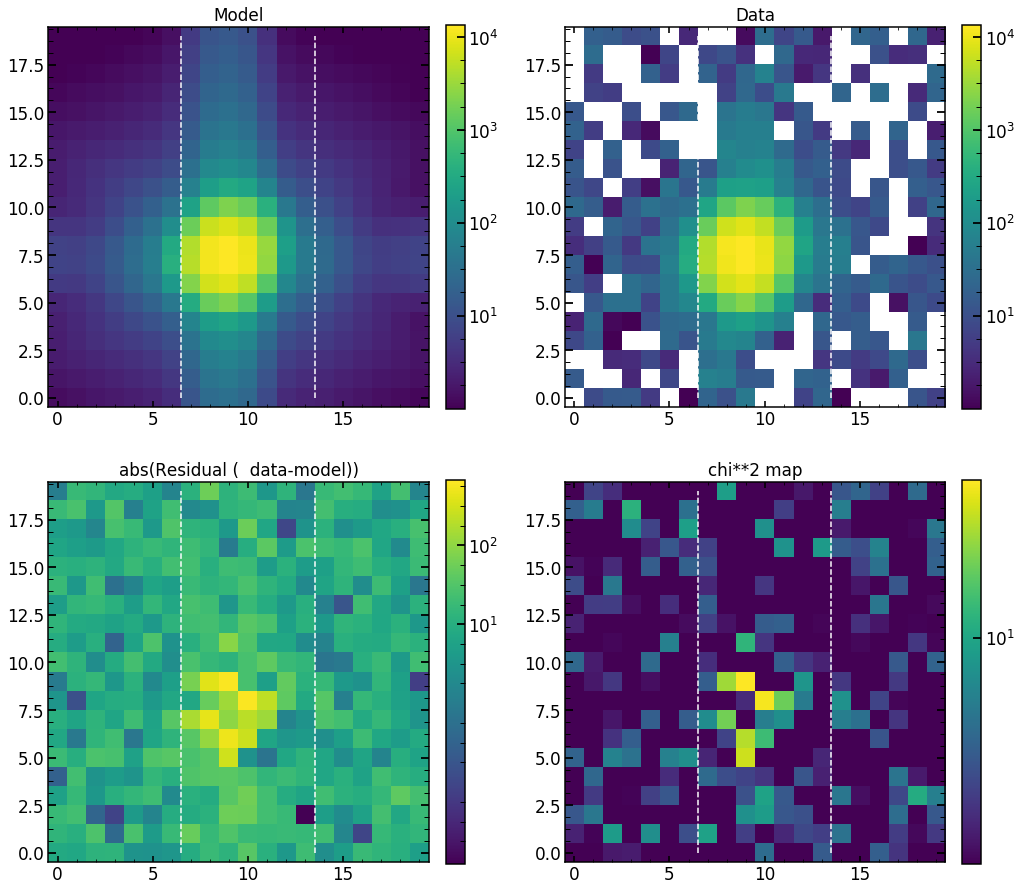

In [476]:
single_analysis.create_basic_comparison_plot_log()

2.137186036200369
chi**2 reduced is: 2.137186036200369
Abs of residual divided by total flux is: 0.06228802051922978
Abs of residual divided by largest value of a flux in the image is: 0.0468395965238845


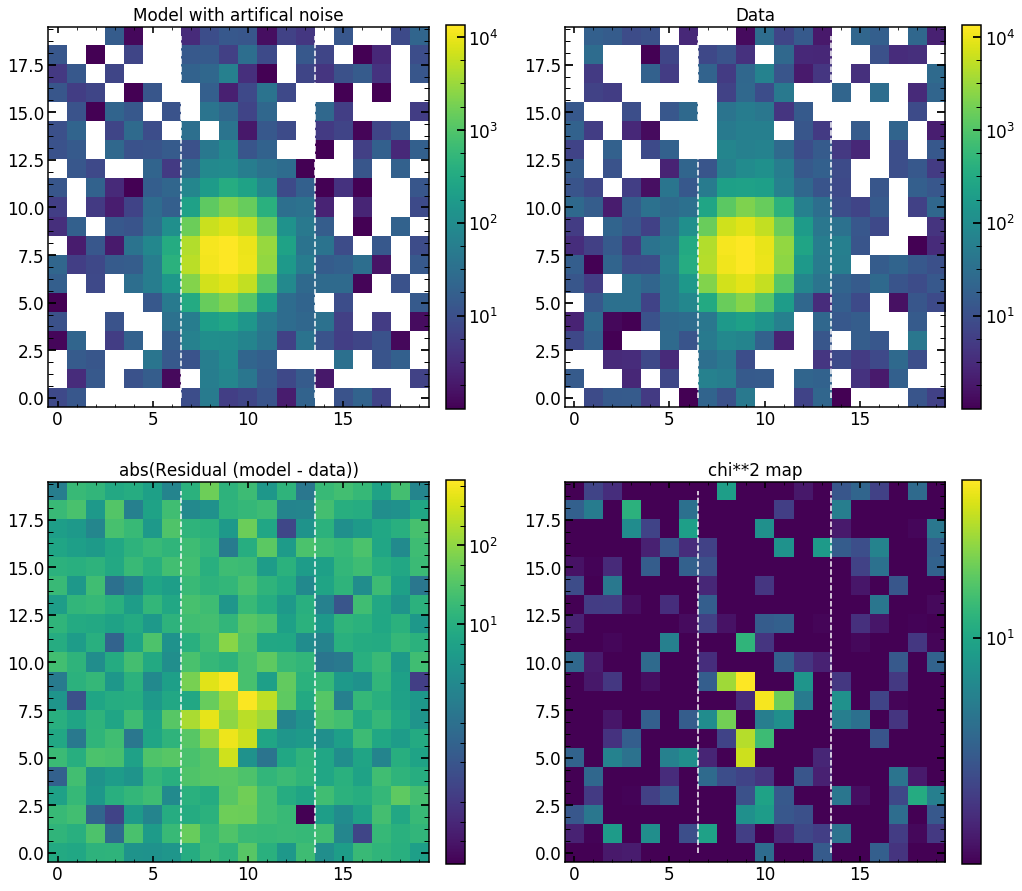

In [477]:
single_analysis.create_basic_comparison_plot_log_artifical()

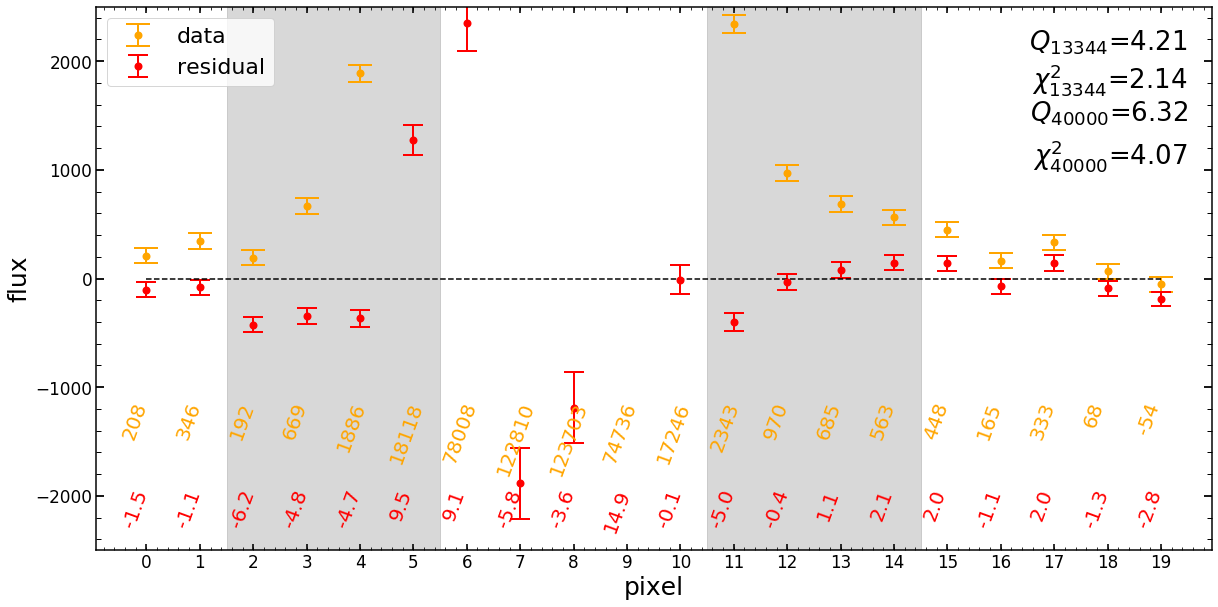

In [478]:
plot_1D_residual(sci_image,var_image,res_iapetus)

## results everywhere 

In [479]:
assert date=='Sep12'

results_of_fit_many_single_focus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                   index=finalHgAr_May2019.index,columns=columns22_analysis)
err_results_of_fit_many_single_focus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                       index=finalHgAr_May2019.index,columns=columns22_analysis)

results_of_fit_many_single_focus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_focus_HgAr)
err_results_of_fit_many_single_focus_HgAr_pd=pd.DataFrame(err_results_of_fit_many_single_focus_HgAr)

#####

results_of_fit_many_single_focus_Ne=pd.DataFrame(np.zeros((len(finalNe_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                 index=finalNe_May2019.index,columns=columns22_analysis)
err_results_of_fit_many_single_focus_Ne=pd.DataFrame(np.zeros((len(finalNe_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                     index=finalNe_May2019.index,columns=columns22_analysis)

results_of_fit_many_single_focus_Ne_pd=pd.DataFrame(results_of_fit_many_single_focus_Ne)
err_results_of_fit_many_single_focus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_focus_Ne)

#####

results_of_fit_many_single_focus_Kr=pd.DataFrame(np.zeros((len(finalKr_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                 index=finalKr_May2019.index,columns=columns22_analysis)
err_results_of_fit_many_single_focus_Kr=pd.DataFrame(np.zeros((len(finalKr_May2019),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                     index=finalKr_May2019.index,columns=columns22_analysis)

results_of_fit_many_single_focus_Kr_pd=pd.DataFrame(results_of_fit_many_single_focus_Kr)
err_results_of_fit_many_single_focus_Kr_pd=pd.DataFrame(err_results_of_fit_many_single_focus_Kr)



In [480]:
columns_analysis=columns22_analysis

for single_number in range(len(finalHgAr_May2019)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    create_results_of_fit_single_focus('Sep12',single_number,'HgAr',22,4)
    results_of_fit_many_single_focus_HgAr_pd.loc[single_number]=results_of_fit_single.values  

results_of_fit_many_single_focus_HgAr_pd=results_of_fit_many_single_focus_HgAr_pd[np.abs(results_of_fit_many_single_focus_HgAr_pd['z4'])>0]



for single_number in range(len(finalNe_May2019)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    create_results_of_fit_single_focus('Sep12',single_number,'Ne',22,4)
    results_of_fit_many_single_focus_Ne_pd.loc[single_number]=results_of_fit_single.values  

results_of_fit_many_single_focus_Ne_pd=results_of_fit_many_single_focus_Ne_pd[np.abs(results_of_fit_many_single_focus_Ne_pd['z4'])>0]



for single_number in range(len(finalKr_May2019)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    create_results_of_fit_single_focus('Sep12',single_number,'Kr',22,4)
    results_of_fit_many_single_focus_Kr_pd.loc[single_number]=results_of_fit_single.values  

results_of_fit_many_single_focus_Kr_pd=results_of_fit_many_single_focus_Kr_pd[np.abs(results_of_fit_many_single_focus_Kr_pd['z4'])>0]


22
0 21400 HgAr is NOT found or failed!
22
1 obs (Emcee3): 21400 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z12: failed!
z13: failed!
z14: failed!
z15: failed!
z17: failed!
z19: failed!
z20: failed!
z22: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac_dy: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z12: failed!
z13: failed!
z14: failed!
z15: failed!
z17: failed!
z19: failed!
z20: failed!
z22: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac_dy: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
2

z10: failed!
z12: failed!
z13: failed!
z14: failed!
z17: failed!
z18: failed!
z22: failed!
hscFrac: failed!
slitFrac: failed!
radiometricExponent: failed!
x_ilum: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
28 21400 HgAr is NOT found or failed!
22
29 21400 HgAr is NOT found or failed!
22
30 obs (Emcee3): 21400 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z13: failed!
z14: failed!
z15: failed!
z17: failed!
z20: failed!
z22: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
radiometricExponent: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z13: failed!
z14: failed!
z15: failed!
z17: failed!
z20: failed!
z22: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
radiometricExpone

effective_radius_illumination: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
55 21400 HgAr is NOT found or failed!
22
56 21400 HgAr is NOT found or failed!
22
57 obs (Emcee3): 21400 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z12: failed!
z13: failed!
z16: failed!
z17: failed!
z18: failed!
z19: failed!
z20: failed!
z21: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z12: failed!
z13: failed!
z16: failed!
z17: failed!
z18: failed!
z19: failed!
z20: failed!
z21: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_d

90 obs (Emcee3): 21400 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z10: failed!
z11: failed!
z14: failed!
z15: failed!
z16: failed!
z17: failed!
z18: failed!
z21: failed!
z22: failed!
hscFrac: failed!
dxFocal: failed!
dyFocal: failed!
radiometricExponent: failed!
x_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z10: failed!
z11: failed!
z14: failed!
z15: failed!
z16: failed!
z17: failed!
z18: failed!
z21: failed!
z22: failed!
hscFrac: failed!
dxFocal: failed!
dyFocal: failed!
radiometricExponent: failed!
x_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
91 21400 HgAr is NOT found or failed!
22
92 21400 HgAr is NOT found or failed!
22
93 obs (Emcee3): 21400 is fo

z6: failed!
z9: failed!
z12: failed!
z13: failed!
z16: failed!
z20: failed!
z22: failed!
hscFrac: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
115 21400 HgAr is NOT found or failed!
22
116 21400 HgAr is NOT found or failed!
22
117 obs (Emcee3): 21400 is found!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z12: failed!
z13: failed!
z15: failed!
z16: failed!
z17: failed!
z18: failed!
z19: failed!
z21: failed!
hscFrac: failed!
dxFocal: failed!
dyFocal: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z12: failed!
z13: failed!
z15: failed!

z11: failed!
z12: failed!
z13: failed!
z14: failed!
z15: failed!
z16: failed!
z17: failed!
z18: failed!
z20: failed!
z21: failed!
z22: failed!
hscFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
21 21604 Ne is NOT found or failed!
22
22 21604 Ne is NOT found or failed!
22
23 obs (Emcee3): 21604 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z12: failed!
z13: failed!
z14: failed!
z15: failed!
z16: failed!
z17: failed!
z20: failed!
z21: failed!
z22: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorent

z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z12: failed!
z13: failed!
z14: failed!
z15: failed!
z16: failed!
z17: failed!
z18: failed!
z20: failed!
z21: failed!
z22: failed!
hscFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z12: failed!
z13: failed!
z14: failed!
z15: failed!
z16: failed!
z17: failed!
z18: failed!
z20: failed!
z21: failed!
z22: failed!
hscFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
48 21604 Ne is 

z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
z12: failed!
z13: failed!
z16: failed!
z18: failed!
z19: failed!
z20: failed!
z22: failed!
hscFrac: failed!
strutFrac: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
70 21604 Ne is NOT found or failed!
22
71 21604 Ne is NOT found or failed!
22
72 21604 Ne is NOT found or failed!
22
73 21604 Ne is NOT found or failed!
22
74 obs (Emcee3): 21604 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z12: failed!
z13: failed!
z14: failed!
z15: failed!
z16: failed!
z18: failed!
z19: failed!
z20: failed!
z21: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: 

radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
22
4 21808 Kr is NOT found or failed!
22
5 21808 Kr is NOT found or failed!
22
6 21808 Kr is NOT found or failed!
22
7 obs (Emcee3): 21808 is found!
z5: failed!
z6: failed!
z8: failed!
z9: failed!
z10: failed!
z12: failed!
z13: failed!
z14: failed!
z15: failed!
z16: failed!
z18: failed!
z19: failed!
z20: failed!
z21: failed!
z22: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
effective_radius_illumination: failed!
frd_lorentz_factor: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z8: failed!
z9: failed!
z10: failed!
z12: failed!
z13: failed!
z14: failed!
z15: failed!
z16: failed!
z18: failed!
z19: failed!
z20: failed!
z21: failed!
z22: failed!
dxFocal: failed!
dyFocal

slitHolder_frac_dx: failed!


In [481]:
pd.set_option("display.max_rows",10)
results_of_fit_many_single_focus_HgAr_pd

z4        z5        z6        z7        z8        z9       z10  \
1    1.120998  0.456755 -0.097107  0.487926  0.591929  0.008047 -0.237128   
3    0.876482  0.245801  0.007635  0.388224  0.547178 -0.012802 -0.265273   
6    0.771891 -0.201926  0.096457  0.171706  0.466419 -0.061183 -0.319258   
9    0.651221 -0.945761 -0.226661 -0.202636  0.383327 -0.155280 -0.388220   
11   0.386773 -1.274181 -0.589989 -0.373275  0.370242 -0.202845 -0.408779   
..        ...       ...       ...       ...       ...       ...       ...   
109  0.923745 -0.738504 -0.147834  0.473147 -1.106692  0.007064 -0.277210   
111  0.629252 -0.581046 -0.035248  0.377252 -1.093489 -0.023111 -0.288853   
114 -0.491973 -0.218709  0.071207  0.168445 -1.049056 -0.092204 -0.306606   
117  0.862519  0.476767 -0.220963 -0.189866 -0.916608 -0.222624 -0.310906   
119  0.740870  0.832137 -0.570347 -0.354089 -0.830567 -0.287848 -0.300786   

          z11       z12       z13     ...       det_vert  slitHolder_frac_dx  \
1   -0.004166 -0.111441 -0.156080     ...       0.995790            0.460752   
3   -0.061185 -0.140575 -0.108887     ...       0.989778            0.460338   
6   -0.088134 -0.166605 -0.006327     ...       0.988078            0.459933   
9    0.199859 -0.083571  0.172603     ...       1.024186            0.461425   
11   0.482110  0.012322  0.255647     ...       1.058347            0.462907   
..        ...       ...       ...     ...            ...                 ...   
109  0.013963 -0.104680  0.143957     ...       0.998830           -0.367255   
111 -0.042123 -0.136886  0.100363     ...       0.991844           -0.366856   
114 -0.066477 -0.169807  0.003288     ...       0.987980           -0.366672   
117  0.224074 -0.098899 -0.172408     ...       1.020217           -0.367923   
119  0.509304 -0.008617 -0.257842     ...       1.052620           -0.369569   

     grating_lines  scattering_slope  scattering_amplitude  pixel_effect  \
1     45854.923026          1.860265              0.000491      0.350000   
3     27099.976724          2.187860              0.000700      0.350000   
6     43556.639408          1.968755              0.000571      0.350000   
9     55751.356133          2.618536              0.004194      0.401463   
11    24639.276888          2.545171              0.007823      0.478812   
..             ...               ...                   ...           ...   
109   42379.257407          1.801627              0.000418      0.350000   
111   36246.074785          2.250110              0.000979      0.350000   
114   55532.637507          2.235167              0.001299      0.350000   
117   53372.540974          2.022353              0.000950      0.350000   
119   19861.099707          1.721242              0.000563      0.402685   

      fiber_r      flux       chi2      chi2max  
1    1.780214  0.999334   4.766538  1497.676758  
3    1.795669  0.997868   2.172157   421.042938  
6    1.780018  0.997225   6.346445  1367.110840  
9    1.802758  0.996189  31.212921  7256.720215  
11   1.817042  0.995263   2.603715   380.818909  
..        ...       ...        ...          ...  
109  1.794588  0.998484   3.711875   950.557983  
111  1.817167  0.996094   1.692272   259.595886  
114  1.833594  0.996725   4.235006   802.067261  
117  1.806038  0.993752  27.548506  3958.158203  
119  1.882884  0.991572   2.021049   189.604843  

[46 rows x 44 columns]

In [482]:
pd.set_option("display.max_rows",10)
results_of_fit_many_single_focus_Ne_pd

z4        z5        z6        z7        z8        z9       z10  \
2   1.369312  0.713682 -0.275933  0.608327  0.650643  0.032011 -0.200648   
5   1.111926  0.480324 -0.113674  0.500021  0.595815  0.010437 -0.233778   
6   0.973316  0.312250 -0.023660  0.420760  0.559349 -0.005998 -0.256504   
11  1.085341  0.569840 -0.434327  0.651158  0.495285  0.035290 -0.206604   
14  0.860179  0.376321 -0.270089  0.543604  0.446832  0.012866 -0.237894   
..       ...       ...       ...       ...       ...       ...       ...   
78  0.132560 -0.537866 -0.208958  0.453249 -0.927286 -0.009832 -0.283061   
83  1.233632 -0.921996 -0.332114  0.587607 -1.118492  0.041976 -0.260545   
86  0.900048 -0.756979 -0.161982  0.483705 -1.109195  0.010417 -0.275775   
87  0.684304 -0.632653 -0.065418  0.407349 -1.099763 -0.013428 -0.285395   
88  0.543768 -0.595693 -0.042340  0.385269 -1.096124 -0.020462 -0.287933   

         z11       z12       z13      ...       det_vert  slitHolder_frac_dx  \
2   0.099021 -0.062175 -0.212622      ...       1.007347            0.460756   
5   0.002523 -0.106837 -0.161245      ...       0.996846            0.459925   
6  -0.047713 -0.131809 -0.123766      ...       0.991514            0.459511   
11 -0.040529 -0.016485 -0.173888      ...       1.020086            0.379714   
14 -0.136710 -0.061790 -0.132335      ...       1.009375            0.379089   
..       ...       ...       ...      ...            ...                 ...   
78 -0.165471 -0.085284  0.093326      ...       1.005303           -0.289322   
83  0.118328 -0.052884  0.195864      ...       1.011244           -0.368682   
86  0.023186 -0.100690  0.149085      ...       0.999735           -0.367874   
87 -0.025842 -0.128198  0.114504      ...       0.993603           -0.367679   
88 -0.037153 -0.134844  0.104344      ...       0.992229           -0.367475   

    grating_lines  scattering_slope  scattering_amplitude  pixel_effect  \
2    35588.259361          2.106128              0.001085      0.350918   
5    41730.757732          2.088506              0.000995      0.350000   
6    36909.756409          1.796784              0.000525      0.350000   
11   52986.034598          2.090494              0.001172      0.350000   
14   56723.389025          2.180936              0.001409      0.350000   
..            ...               ...                   ...           ...   
78   43376.216686          1.786508              0.000588      0.383650   
83   36700.001341          1.851096              0.000661      0.350000   
86   41757.096450          1.993256              0.000884      0.350000   
87   41066.459670          1.803254              0.000615      0.350000   
88  101660.536528          2.190828              0.001479      0.350000   

     fiber_r      flux       chi2       chi2max  
2   1.792083  0.994709  31.969451   5628.119141  
5   1.800850  0.997410  27.979601   9602.761719  
6   1.795660  0.997732   5.765599   2000.132202  
11  1.787944  0.998343  11.975894   5287.791016  
14  1.803617  0.998989  13.004206   9150.757812  
..       ...       ...        ...           ...  
78  1.814300  0.998463   2.975907   1382.410034  
83  1.780014  0.995191  19.681424   3651.568115  
86  1.794418  0.996925  20.910632   6080.844238  
87  1.814293  0.997652   3.830012   1245.952393  
88  1.849191  0.997441  38.035728  13603.197266  

[31 rows x 44 columns]

In [483]:
pd.set_option("display.max_rows",10)
results_of_fit_many_single_focus_Kr_pd

z4        z5        z6        z7        z8        z9       z10  \
3   0.663633 -0.823741 -0.129694 -0.140138  0.391466 -0.138695 -0.378952   
7   0.515519 -0.689159 -0.269641 -0.092048  0.277522 -0.141530 -0.372687   
15 -0.122921 -0.449566 -0.455328 -0.028428  0.044891 -0.148862 -0.360840   
19 -0.353653 -0.334997 -0.506393 -0.010895 -0.079748 -0.153602 -0.354803   
23 -0.366617 -0.226017 -0.527272 -0.003410 -0.205565 -0.158905 -0.348804   
27 -0.153023 -0.082586 -0.508520 -0.007964 -0.380708 -0.166927 -0.340464   
31 -0.091676  0.023858 -0.459721 -0.023111 -0.516030 -0.173852 -0.333995   
35  0.752689  0.245461 -0.265913 -0.085957 -0.803103 -0.190711 -0.319867   
39  0.784974  0.355191 -0.129562 -0.130894 -0.943477 -0.200070 -0.312616   

         z11       z12       z13     ...       det_vert  slitHolder_frac_dx  \
3   0.120326 -0.108979  0.142441     ...       1.014637            0.460588   
7  -0.027457 -0.068949  0.112397     ...       1.025553            0.379535   
15 -0.220569 -0.016628  0.057813     ...       1.039861            0.222392   
19 -0.271869 -0.002833  0.031047     ...       1.043658            0.141960   
23 -0.291115  0.002076  0.005094     ...       1.045035            0.062975   
27 -0.268857 -0.005120 -0.029876     ...       1.043103           -0.043716   
31 -0.214859 -0.020785 -0.056466     ...       1.038864           -0.123941   
35 -0.002996 -0.080640 -0.113538     ...       1.022636           -0.288940   
39  0.145723 -0.122186 -0.142566     ...       1.011367           -0.367511   

    grating_lines  scattering_slope  scattering_amplitude  pixel_effect  \
3    72936.722806          2.350426              0.001897      0.372625   
7    82480.947238          2.386444              0.002116      0.382256   
15   66964.961887          2.393477              0.002077      0.425497   
19   60338.824194          2.482431              0.002534      0.402206   
23   54636.826972          2.272617              0.001543      0.422953   
27   54403.084170          2.096879              0.000990      0.431186   
31   43113.751759          1.815624              0.000415      0.399196   
35  105475.539378          1.928756              0.000865      0.350000   
39   63889.261210          1.580544              0.000295      0.350000   

     fiber_r      flux       chi2      chi2max  
3   1.811462  0.996161  11.167461  2451.220947  
7   1.825316  0.996208  11.277754  2560.378662  
15  1.829918  0.994790  16.847491  3034.321777  
19  1.838482  0.995109  14.341030  2684.949463  
23  1.797362  0.995264  11.183248  2169.526367  
27  1.814205  0.995235  12.013191  2273.532715  
31  1.827459  0.995040  11.717449  2207.657471  
35  1.805129  0.995827   8.759882  1767.964111  
39  1.784593  0.991967  12.227339  1364.189697  

[9 rows x 44 columns]

In [484]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep12_Focus/' + 'results_of_fit_many_direct_HgAr_from_Sep12.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_single_focus_HgAr_pd,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep12_Focus/' + 'results_of_fit_many_direct_Ne_from_Sep12.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_single_focus_Ne_pd,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep12_Focus/' + 'results_of_fit_many_direct_Kr_from_Sep12.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_single_focus_Kr_pd,f, protocol=pickle.HIGHEST_PROTOCOL)

# Creating array_of_arrays

## pure results_of_fit_many

In [ ]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
finalNe=finalNe_May2019

### Sep11

In [486]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_HgAr_from_Sep11.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Sep11=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_Ne_from_Sep11.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Sep11=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_Kr_from_Sep11.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Sep11=pickle.load(f)

In [487]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22,simulation_00=True)   
       
model(minchain)

extraZernike: None
zmax: 22
True


-434.4314172558831

In [489]:
list_of_simulation_00_HgAr_single=[]
positions_of_simulation_00_HgAr_single=[]
positions_of_simulation_00_HgAr=finalHgAr.loc[results_of_fit_many_direct_HgAr_from_Sep11.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_HgAr_from_Sep11.index.values))):
    minchain=results_of_fit_many_direct_HgAr_from_Sep11.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')
    list_of_simulation_00_HgAr_single.append(simulation_00_single)
    positions_of_simulation_00_HgAr_single.append(positions_of_simulation_00_HgAr.iloc[i][:4].values)
    
list_of_simulation_00_Ne_single=[]
positions_of_simulation_00_Ne_single=[]
positions_of_simulation_00_Ne=finalNe.loc[results_of_fit_many_direct_Ne_from_Sep11.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_Ne_from_Sep11.index.values))):
    minchain=results_of_fit_many_direct_Ne_from_Sep11.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')
    list_of_simulation_00_Ne_single.append(simulation_00_single)
    positions_of_simulation_00_Ne_single.append(positions_of_simulation_00_Ne.iloc[i][:4].values)

    
    
list_of_simulation_00_Kr_single=[]
positions_of_simulation_00_Kr_single=[]
positions_of_simulation_00_Kr=finalKr.loc[results_of_fit_many_direct_Kr_from_Sep11.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_Kr_from_Sep11.index.values))):
    minchain=results_of_fit_many_direct_Kr_from_Sep11.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')
    list_of_simulation_00_Kr_single.append(simulation_00_single)
    positions_of_simulation_00_Kr_single.append(positions_of_simulation_00_Kr.iloc[i][:4].values)
    

  0%|          | 0/37 [00:00<?, ?it/s]

True


  3%|▎         | 1/37 [00:02<01:15,  2.08s/it]

True


  5%|▌         | 2/37 [00:04<01:11,  2.05s/it]

True


  8%|▊         | 3/37 [00:06<01:08,  2.02s/it]

True


 11%|█         | 4/37 [00:08<01:06,  2.02s/it]

True


 14%|█▎        | 5/37 [00:09<01:03,  1.99s/it]

True


 16%|█▌        | 6/37 [00:12<01:02,  2.02s/it]

True


 19%|█▉        | 7/37 [00:14<01:01,  2.06s/it]

True


 22%|██▏       | 8/37 [00:16<00:59,  2.04s/it]

True


 24%|██▍       | 9/37 [00:18<00:56,  2.03s/it]

True


 27%|██▋       | 10/37 [00:20<00:56,  2.09s/it]

True


 30%|██▉       | 11/37 [00:22<00:54,  2.08s/it]

True


 32%|███▏      | 12/37 [00:24<00:51,  2.04s/it]

True


 35%|███▌      | 13/37 [00:26<00:49,  2.05s/it]

True


 38%|███▊      | 14/37 [00:28<00:46,  2.02s/it]

True


 41%|████      | 15/37 [00:29<00:43,  2.00s/it]

True


 43%|████▎     | 16/37 [00:31<00:41,  1.97s/it]

True


 46%|████▌     | 17/37 [00:33<00:38,  1.95s/it]

True


 49%|████▊     | 18/37 [00:34<00:36,  1.94s/it]

True


 51%|█████▏    | 19/37 [00:36<00:34,  1.92s/it]

True


 54%|█████▍    | 20/37 [00:38<00:32,  1.92s/it]

True


 57%|█████▋    | 21/37 [00:40<00:30,  1.91s/it]

True


 59%|█████▉    | 22/37 [00:41<00:28,  1.90s/it]

True


 62%|██████▏   | 23/37 [00:43<00:26,  1.89s/it]

True


 65%|██████▍   | 24/37 [00:45<00:24,  1.88s/it]

True


 68%|██████▊   | 25/37 [00:46<00:22,  1.87s/it]

True


 70%|███████   | 26/37 [00:48<00:20,  1.88s/it]

True


 73%|███████▎  | 27/37 [00:50<00:18,  1.87s/it]

True


 76%|███████▌  | 28/37 [00:52<00:16,  1.86s/it]

True


 78%|███████▊  | 29/37 [00:53<00:14,  1.86s/it]

True


 81%|████████  | 30/37 [00:55<00:12,  1.85s/it]

True


 84%|████████▍ | 31/37 [00:57<00:11,  1.84s/it]

True


 86%|████████▋ | 32/37 [00:58<00:09,  1.83s/it]

True


 89%|████████▉ | 33/37 [01:00<00:07,  1.82s/it]

True


 92%|█████████▏| 34/37 [01:02<00:05,  1.84s/it]

True


 95%|█████████▍| 35/37 [01:03<00:03,  1.83s/it]

True


 97%|█████████▋| 36/37 [01:05<00:01,  1.82s/it]

True


  0%|          | 0/29 [00:00<?, ?it/s]

True


  3%|▎         | 1/29 [00:01<00:47,  1.70s/it]

True


  7%|▋         | 2/29 [00:03<00:42,  1.59s/it]

True


 10%|█         | 3/29 [00:04<00:40,  1.55s/it]

True


 14%|█▍        | 4/29 [00:06<00:38,  1.55s/it]

True


 17%|█▋        | 5/29 [00:07<00:36,  1.53s/it]

True


 21%|██        | 6/29 [00:09<00:34,  1.52s/it]

True


 24%|██▍       | 7/29 [00:10<00:33,  1.52s/it]

True


 28%|██▊       | 8/29 [00:12<00:32,  1.53s/it]

True


 31%|███       | 9/29 [00:14<00:31,  1.58s/it]

True


 34%|███▍      | 10/29 [00:15<00:29,  1.58s/it]

True


 38%|███▊      | 11/29 [00:17<00:28,  1.57s/it]

True


 41%|████▏     | 12/29 [00:18<00:26,  1.56s/it]

True


 45%|████▍     | 13/29 [00:20<00:25,  1.56s/it]

True


 48%|████▊     | 14/29 [00:21<00:23,  1.56s/it]

True


 52%|█████▏    | 15/29 [00:23<00:21,  1.56s/it]

True


 55%|█████▌    | 16/29 [00:24<00:20,  1.56s/it]

True


 59%|█████▊    | 17/29 [00:26<00:18,  1.56s/it]

True


 62%|██████▏   | 18/29 [00:28<00:17,  1.57s/it]

True


 66%|██████▌   | 19/29 [00:29<00:15,  1.57s/it]

True


 69%|██████▉   | 20/29 [00:31<00:14,  1.60s/it]

True


 72%|███████▏  | 21/29 [00:33<00:12,  1.60s/it]

True


 76%|███████▌  | 22/29 [00:35<00:11,  1.62s/it]

True


 79%|███████▉  | 23/29 [00:37<00:09,  1.64s/it]

True


 83%|████████▎ | 24/29 [00:39<00:08,  1.64s/it]

True


 86%|████████▌ | 25/29 [00:41<00:06,  1.64s/it]

True


 90%|████████▉ | 26/29 [00:42<00:04,  1.65s/it]

True


 93%|█████████▎| 27/29 [00:44<00:03,  1.65s/it]

True


 97%|█████████▋| 28/29 [00:46<00:01,  1.65s/it]

True


  0%|          | 0/9 [00:00<?, ?it/s]

True


 11%|█         | 1/9 [00:01<00:12,  1.53s/it]

True


 22%|██▏       | 2/9 [00:03<00:11,  1.59s/it]

True


 33%|███▎      | 3/9 [00:04<00:09,  1.54s/it]

True


 44%|████▍     | 4/9 [00:06<00:07,  1.55s/it]

True


 56%|█████▌    | 5/9 [00:07<00:06,  1.53s/it]

True


 67%|██████▋   | 6/9 [00:09<00:04,  1.52s/it]

True


 78%|███████▊  | 7/9 [00:10<00:03,  1.57s/it]

True


 89%|████████▉ | 8/9 [00:12<00:01,  1.60s/it]

True


100%|██████████| 9/9 [00:14<00:00,  1.60s/it]


In [ ]:
list_of_simulation_00=list_of_simulation_00_HgAr_single+list_of_simulation_00_Kr_single
array_of_simulation_00=np.array(list_of_simulation_00)

In [ ]:
positions_of_simulation_00=np.array(positions_of_simulation_00_HgAr_single+positions_of_simulation_00_Kr_single)
positions_of_simulation_00[:,0]=positions_of_simulation_00[:,0].astype(int)
positions_of_simulation_00[:,1]=positions_of_simulation_00[:,1].astype(int)
positions_of_simulation_00[:,2]=positions_of_simulation_00[:,2].astype(int)
positions_of_simulation_00[:,3]=positions_of_simulation_00[:,3].astype(float)

In [ ]:
np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Aug05_Focus/array_of_simulation_00_from_Aug05_v1',array_of_simulation_00)
np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Aug05_Focus/positions_of_simulation_00_from_Aug05_v1',positions_of_simulation_00)

# Example for Jira ticket

In [321]:
print(minchain.shape)

if len(minchain)==42:
    columns=columns22
    
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

(42,)
          z4        z5        z6        z7        z8        z9       z10  \
0 -10.362579  0.560209 -0.077254  0.450622  0.826757  0.239657 -0.366527   

        z11  
0  0.101117  
        z12       z13       z14       z15       z16       z17       z18  \
0 -0.083894 -0.079991  0.023816  0.001552  0.059755  0.022614  0.010412   

        z19       z20       z21  
0  0.013712 -0.030825 -0.004914  
        z22   hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.071079  0.662605    0.10701 -0.281816 -0.028659  0.055285     0.064586   

   radiometricEffect  radiometricExponent    x_ilum    ...     frd_sigma  \
0           0.000041             0.000041  0.974929    ...       0.11509   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.494694  1.002234            0.470974   77712.239947   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0          2.501419              0.003212      0.439694  1.8170

In [328]:
minchain1=np.copy(minchain)
minchain1[-10]=0.06

if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22)   
  
model(minchain1)

optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus1=optPsf_cut_fiber_convolved_downsampled

extraZernike: None
zmax: 22
None


In [334]:
minchain2=np.copy(minchain)
minchain2[-10]=0.07

if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22)   
       
model(minchain2)


optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus2=optPsf_cut_fiber_convolved_downsampled

extraZernike: None
zmax: 22
None


In [335]:
minchain3=np.copy(minchain)
minchain3[0]=0
minchain3[-10]=0.06
if obs=='8600':
    model = LN_PFS_single(sci_image/8,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image/8,var_image,dithering=1,save=1,zmax=22)   
       
model(minchain3)


optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus3=optPsf_cut_fiber_convolved_downsampled

extraZernike: None
zmax: 22
None


In [336]:
minchain4=np.copy(minchain)
minchain4[0]=0
minchain3[-10]=0.07
if obs=='8600':
    model = LN_PFS_single(sci_image/8,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image/8,var_image,dithering=1,save=1,zmax=22)   
       
model(minchain4)


optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus4=optPsf_cut_fiber_convolved_downsampled

extraZernike: None
zmax: 22
None


In [337]:
find_centroid_of_flux(res_iapetus1)

(14.982712606964265, 14.85292331914304)

Text(0.5,1,'Residual')

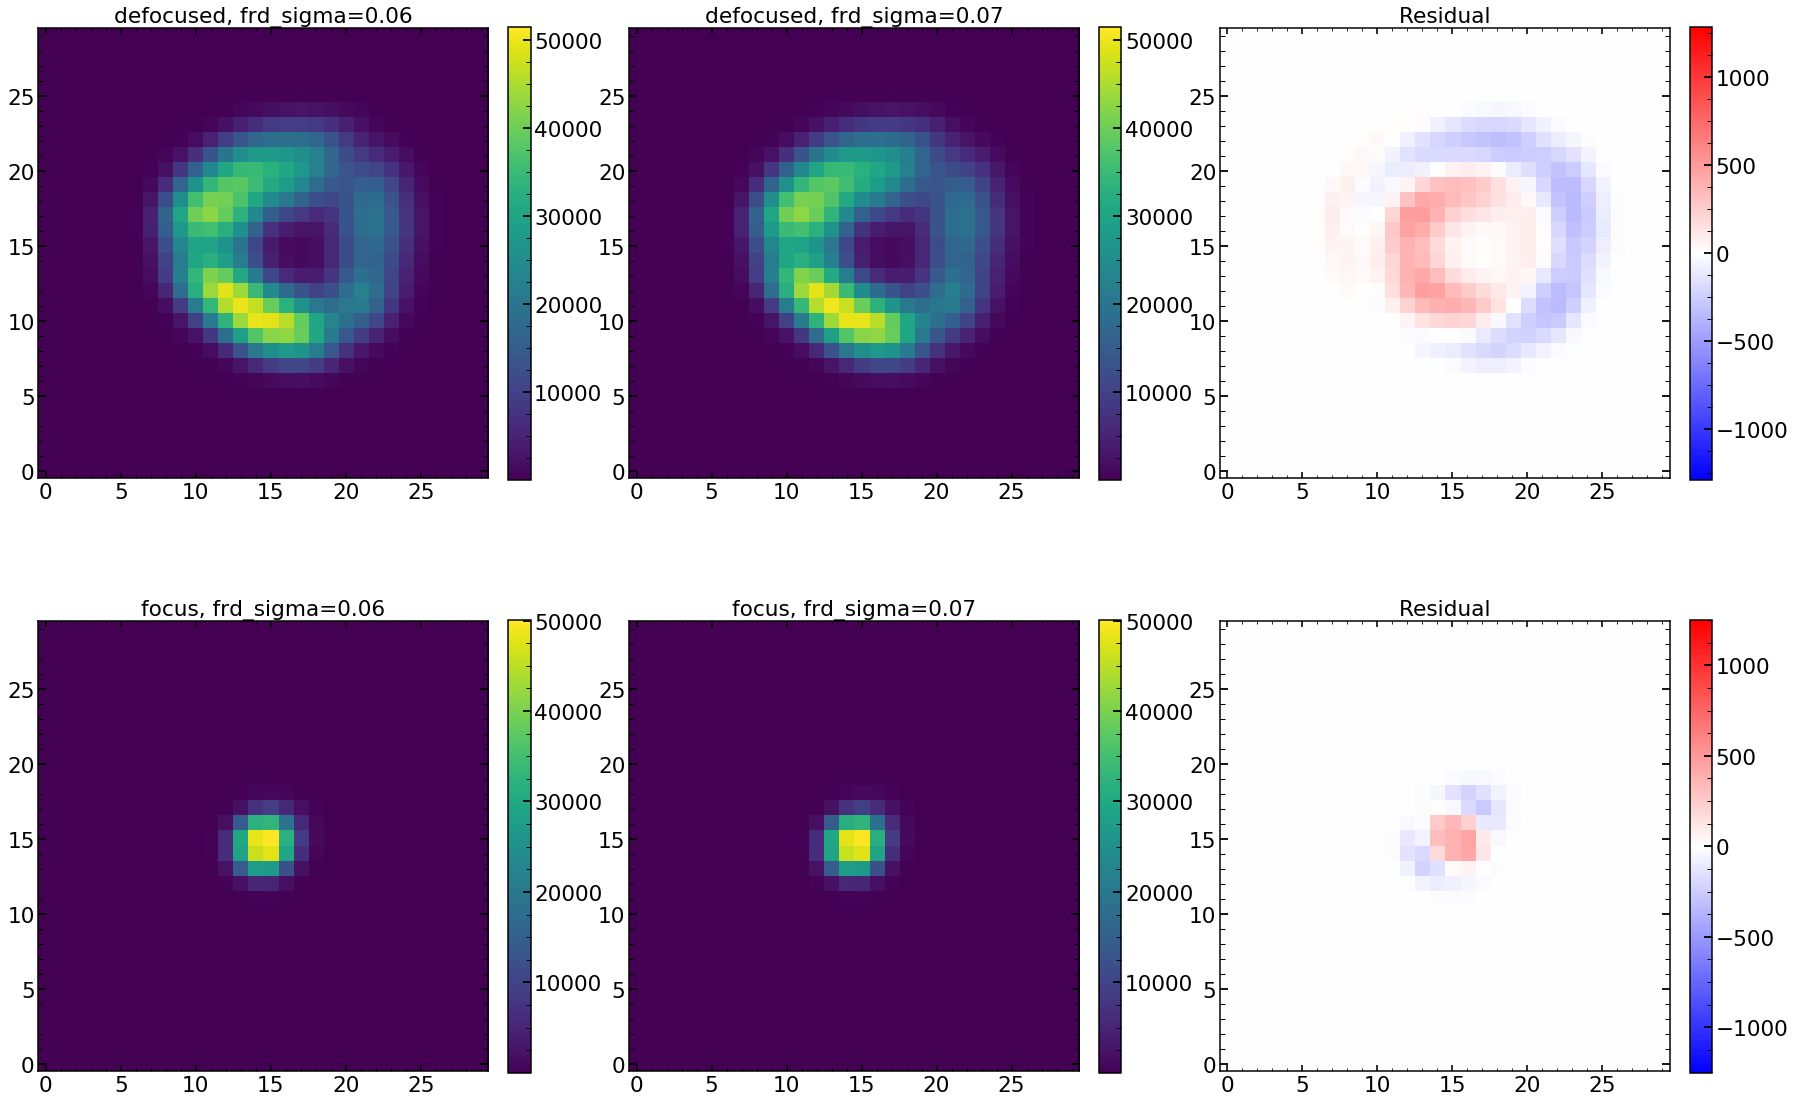

In [339]:
plt.figure(figsize=(30,20))
plt.subplot(2,3,1)
plt.imshow(res_iapetus1,vmax=np.max(sci_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('defocused, frd_sigma=0.06')
plt.subplot(2,3,2)
plt.imshow(res_iapetus2,vmax=np.max(sci_image))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('defocused, frd_sigma=0.07')
plt.subplot(2,3,3)
plt.imshow(res_iapetus2-res_iapetus1,vmin=-np.max(sci_image)/40,vmax=np.max(sci_image)/40,cmap='bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Residual')

plt.subplot(2,3,4)
plt.imshow(res_iapetus3,vmax=np.max(res_iapetus3))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('focus, frd_sigma=0.06')
plt.subplot(2,3,5)
plt.imshow(res_iapetus4,vmax=np.max(res_iapetus3))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('focus, frd_sigma=0.07')
plt.subplot(2,3,6)
plt.imshow(res_iapetus3-res_iapetus4,vmin=-np.max(res_iapetus3)/40,vmax=np.max(res_iapetus3)/40,cmap='bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Residual')

# Creating array_of_arrays

## first attempt, pure results_of_fit_many

In [ ]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
finalNe=finalNe_May2019

### Sep11

In [506]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_HgAr_from_Sep11.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Sep11=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_Ne_from_Sep11.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Sep11=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_Kr_from_Sep11.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Sep11=pickle.load(f)

In [507]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22,simulation_00=True)   
       
model(minchain)

extraZernike: None
zmax: 22
True


-5621.645359011532

In [508]:
list_of_simulation_00_HgAr_single=[]
positions_of_simulation_00_HgAr_single=[]
positions_of_simulation_00_HgAr=finalHgAr.loc[results_of_fit_many_direct_HgAr_from_Sep11.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_HgAr_from_Sep11.index.values))):
    minchain=results_of_fit_many_direct_HgAr_from_Sep11.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')
    list_of_simulation_00_HgAr_single.append(simulation_00_single)
    positions_of_simulation_00_HgAr_single.append(positions_of_simulation_00_HgAr.iloc[i][:4].values)
    
list_of_simulation_00_Ne_single=[]
positions_of_simulation_00_Ne_single=[]
positions_of_simulation_00_Ne=finalNe.loc[results_of_fit_many_direct_Ne_from_Sep11.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_Ne_from_Sep11.index.values))):
    minchain=results_of_fit_many_direct_Ne_from_Sep11.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')
    list_of_simulation_00_Ne_single.append(simulation_00_single)
    positions_of_simulation_00_Ne_single.append(positions_of_simulation_00_Ne.iloc[i][:4].values)

    
    
list_of_simulation_00_Kr_single=[]
positions_of_simulation_00_Kr_single=[]
positions_of_simulation_00_Kr=finalKr.loc[results_of_fit_many_direct_Kr_from_Sep11.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_Kr_from_Sep11.index.values))):
    minchain=results_of_fit_many_direct_Kr_from_Sep11.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')
    list_of_simulation_00_Kr_single.append(simulation_00_single)
    positions_of_simulation_00_Kr_single.append(positions_of_simulation_00_Kr.iloc[i][:4].values)

  0%|          | 0/37 [00:00<?, ?it/s]

True


  3%|▎         | 1/37 [00:01<00:55,  1.55s/it]

True


  5%|▌         | 2/37 [00:03<00:54,  1.57s/it]

True


  8%|▊         | 3/37 [00:04<00:53,  1.57s/it]

True


 11%|█         | 4/37 [00:06<00:51,  1.55s/it]

True


 14%|█▎        | 5/37 [00:07<00:49,  1.56s/it]

True


 16%|█▌        | 6/37 [00:09<00:47,  1.54s/it]

True


 19%|█▉        | 7/37 [00:10<00:46,  1.55s/it]

True


 22%|██▏       | 8/37 [00:12<00:45,  1.57s/it]

True


 24%|██▍       | 9/37 [00:14<00:43,  1.57s/it]

True


 27%|██▋       | 10/37 [00:15<00:42,  1.58s/it]

True


 30%|██▉       | 11/37 [00:17<00:40,  1.57s/it]

True


 32%|███▏      | 12/37 [00:18<00:39,  1.57s/it]

True


 35%|███▌      | 13/37 [00:20<00:37,  1.57s/it]

True


 38%|███▊      | 14/37 [00:22<00:36,  1.57s/it]

True


 41%|████      | 15/37 [00:23<00:34,  1.57s/it]

True


 43%|████▎     | 16/37 [00:25<00:32,  1.57s/it]

True


 46%|████▌     | 17/37 [00:26<00:31,  1.57s/it]

True


 49%|████▊     | 18/37 [00:28<00:29,  1.56s/it]

True


 51%|█████▏    | 19/37 [00:29<00:28,  1.56s/it]

True


 54%|█████▍    | 20/37 [00:31<00:27,  1.60s/it]

True


 57%|█████▋    | 21/37 [00:33<00:25,  1.59s/it]

True


 59%|█████▉    | 22/37 [00:34<00:23,  1.58s/it]

True


 62%|██████▏   | 23/37 [00:36<00:22,  1.58s/it]

True


 65%|██████▍   | 24/37 [00:37<00:20,  1.57s/it]

True


 68%|██████▊   | 25/37 [00:39<00:18,  1.57s/it]

True


 70%|███████   | 26/37 [00:40<00:17,  1.56s/it]

True


 73%|███████▎  | 27/37 [00:41<00:15,  1.55s/it]

True


 76%|███████▌  | 28/37 [00:43<00:13,  1.55s/it]

True


 78%|███████▊  | 29/37 [00:44<00:12,  1.54s/it]

True


 81%|████████  | 30/37 [00:46<00:10,  1.54s/it]

True


 84%|████████▍ | 31/37 [00:47<00:09,  1.54s/it]

True


 86%|████████▋ | 32/37 [00:49<00:07,  1.53s/it]

True


 89%|████████▉ | 33/37 [00:50<00:06,  1.53s/it]

True


 92%|█████████▏| 34/37 [00:51<00:04,  1.52s/it]

True


 95%|█████████▍| 35/37 [00:53<00:03,  1.54s/it]

True


 97%|█████████▋| 36/37 [00:55<00:01,  1.54s/it]

True


  0%|          | 0/29 [00:00<?, ?it/s]

True


  3%|▎         | 1/29 [00:01<00:41,  1.49s/it]

True


  7%|▋         | 2/29 [00:02<00:40,  1.48s/it]

True


 10%|█         | 3/29 [00:04<00:40,  1.56s/it]

True


 14%|█▍        | 4/29 [00:06<00:39,  1.57s/it]

True


 17%|█▋        | 5/29 [00:07<00:37,  1.56s/it]

True


 21%|██        | 6/29 [00:09<00:35,  1.56s/it]

True


 24%|██▍       | 7/29 [00:10<00:33,  1.54s/it]

True


 28%|██▊       | 8/29 [00:12<00:32,  1.53s/it]

True


 31%|███       | 9/29 [00:13<00:30,  1.52s/it]

True


 34%|███▍      | 10/29 [00:15<00:28,  1.51s/it]

True


 38%|███▊      | 11/29 [00:16<00:26,  1.49s/it]

True


 41%|████▏     | 12/29 [00:17<00:25,  1.49s/it]

True


 45%|████▍     | 13/29 [00:19<00:23,  1.48s/it]

True


 48%|████▊     | 14/29 [00:20<00:21,  1.47s/it]

True


 52%|█████▏    | 15/29 [00:21<00:20,  1.46s/it]

True


 55%|█████▌    | 16/29 [00:23<00:18,  1.46s/it]

True


 59%|█████▊    | 17/29 [00:24<00:17,  1.47s/it]

True


 62%|██████▏   | 18/29 [00:26<00:16,  1.46s/it]

True


 66%|██████▌   | 19/29 [00:27<00:14,  1.46s/it]

True


 69%|██████▉   | 20/29 [00:29<00:13,  1.45s/it]

True


 72%|███████▏  | 21/29 [00:30<00:11,  1.45s/it]

True


 76%|███████▌  | 22/29 [00:32<00:10,  1.47s/it]

True


 79%|███████▉  | 23/29 [00:33<00:08,  1.46s/it]

True


 83%|████████▎ | 24/29 [00:35<00:07,  1.47s/it]

True


 86%|████████▌ | 25/29 [00:36<00:05,  1.47s/it]

True


 90%|████████▉ | 26/29 [00:38<00:04,  1.47s/it]

True


 93%|█████████▎| 27/29 [00:39<00:02,  1.47s/it]

True


 97%|█████████▋| 28/29 [00:40<00:01,  1.46s/it]

True


  0%|          | 0/9 [00:00<?, ?it/s]

True


 11%|█         | 1/9 [00:01<00:11,  1.46s/it]

True


 22%|██▏       | 2/9 [00:02<00:09,  1.41s/it]

True


 33%|███▎      | 3/9 [00:04<00:08,  1.39s/it]

True


 44%|████▍     | 4/9 [00:05<00:06,  1.38s/it]

True


 56%|█████▌    | 5/9 [00:06<00:05,  1.38s/it]

True


 67%|██████▋   | 6/9 [00:08<00:04,  1.37s/it]

True


 78%|███████▊  | 7/9 [00:09<00:02,  1.37s/it]

True


 89%|████████▉ | 8/9 [00:11<00:01,  1.38s/it]

True


100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


In [509]:
list_of_simulation_00=list_of_simulation_00_HgAr_single+list_of_simulation_00_Ne_single+list_of_simulation_00_Kr_single
array_of_simulation_00=np.array(list_of_simulation_00)

In [510]:
positions_of_simulation_00=np.array(positions_of_simulation_00_HgAr_single+positions_of_simulation_00_Ne_single+positions_of_simulation_00_Kr_single)
positions_of_simulation_00[:,0]=positions_of_simulation_00[:,0].astype(int)
positions_of_simulation_00[:,1]=positions_of_simulation_00[:,1].astype(int)
positions_of_simulation_00[:,2]=positions_of_simulation_00[:,2].astype(int)
positions_of_simulation_00[:,3]=positions_of_simulation_00[:,3].astype(float)

In [511]:
np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/array_of_simulation_00_from_Sep11_v1',array_of_simulation_00)
np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/positions_of_simulation_00_from_Sep11_v1',positions_of_simulation_00)

### Sep12

In [512]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep12_Focus/' + 'results_of_fit_many_direct_HgAr_from_Sep12.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Sep12=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep12_Focus/' + 'results_of_fit_many_direct_Ne_from_Sep12.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Sep12=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep12_Focus/' + 'results_of_fit_many_direct_Kr_from_Sep12.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Sep12=pickle.load(f)

In [513]:
list_of_simulation_00_HgAr_single=[]
positions_of_simulation_00_HgAr_single=[]
positions_of_simulation_00_HgAr=finalHgAr.loc[results_of_fit_many_direct_HgAr_from_Sep12.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_HgAr_from_Sep12.index.values))):
    minchain=results_of_fit_many_direct_HgAr_from_Sep12.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')
    list_of_simulation_00_HgAr_single.append(simulation_00_single)
    positions_of_simulation_00_HgAr_single.append(positions_of_simulation_00_HgAr.iloc[i][:4].values)
    
list_of_simulation_00_Ne_single=[]
positions_of_simulation_00_Ne_single=[]
positions_of_simulation_00_Ne=finalNe.loc[results_of_fit_many_direct_Ne_from_Sep12.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_Ne_from_Sep12.index.values))):
    minchain=results_of_fit_many_direct_Ne_from_Sep12.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')
    list_of_simulation_00_Ne_single.append(simulation_00_single)
    positions_of_simulation_00_Ne_single.append(positions_of_simulation_00_Ne.iloc[i][:4].values)

    
    
list_of_simulation_00_Kr_single=[]
positions_of_simulation_00_Kr_single=[]
positions_of_simulation_00_Kr=finalKr.loc[results_of_fit_many_direct_Kr_from_Sep12.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_Kr_from_Sep12.index.values))):
    minchain=results_of_fit_many_direct_Kr_from_Sep12.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')
    list_of_simulation_00_Kr_single.append(simulation_00_single)
    positions_of_simulation_00_Kr_single.append(positions_of_simulation_00_Kr.iloc[i][:4].values)

  0%|          | 0/46 [00:00<?, ?it/s]

True


  2%|▏         | 1/46 [00:01<01:11,  1.59s/it]

True


  4%|▍         | 2/46 [00:03<01:08,  1.56s/it]

True


  7%|▋         | 3/46 [00:04<01:05,  1.51s/it]

True


  9%|▊         | 4/46 [00:05<01:02,  1.49s/it]

True


 11%|█         | 5/46 [00:07<01:02,  1.53s/it]

True


 13%|█▎        | 6/46 [00:09<01:00,  1.51s/it]

True


 15%|█▌        | 7/46 [00:10<00:58,  1.50s/it]

True


 17%|█▋        | 8/46 [00:11<00:56,  1.50s/it]

True


 20%|█▉        | 9/46 [00:13<00:55,  1.50s/it]

True


 22%|██▏       | 10/46 [00:14<00:53,  1.49s/it]

True


 24%|██▍       | 11/46 [00:16<00:52,  1.49s/it]

True


 26%|██▌       | 12/46 [00:17<00:50,  1.47s/it]

True


 28%|██▊       | 13/46 [00:19<00:48,  1.47s/it]

True


 30%|███       | 14/46 [00:20<00:46,  1.46s/it]

True


 33%|███▎      | 15/46 [00:21<00:45,  1.46s/it]

True


 35%|███▍      | 16/46 [00:23<00:43,  1.45s/it]

True


 37%|███▋      | 17/46 [00:24<00:41,  1.45s/it]

True


 39%|███▉      | 18/46 [00:26<00:40,  1.45s/it]

True


 41%|████▏     | 19/46 [00:27<00:38,  1.44s/it]

True


 43%|████▎     | 20/46 [00:28<00:37,  1.44s/it]

True


 46%|████▌     | 21/46 [00:30<00:35,  1.44s/it]

True


 48%|████▊     | 22/46 [00:31<00:34,  1.44s/it]

True


 50%|█████     | 23/46 [00:33<00:33,  1.44s/it]

True


 52%|█████▏    | 24/46 [00:34<00:31,  1.43s/it]

True


 54%|█████▍    | 25/46 [00:35<00:30,  1.43s/it]

True


 57%|█████▋    | 26/46 [00:37<00:28,  1.44s/it]

True


 59%|█████▊    | 27/46 [00:38<00:27,  1.44s/it]

True


 61%|██████    | 28/46 [00:40<00:25,  1.43s/it]

True


 63%|██████▎   | 29/46 [00:41<00:24,  1.44s/it]

True


 65%|██████▌   | 30/46 [00:43<00:23,  1.44s/it]

True


 67%|██████▋   | 31/46 [00:44<00:21,  1.44s/it]

True


 70%|██████▉   | 32/46 [00:46<00:20,  1.44s/it]

True


 72%|███████▏  | 33/46 [00:47<00:18,  1.44s/it]

True


 74%|███████▍  | 34/46 [00:48<00:17,  1.44s/it]

True


 76%|███████▌  | 35/46 [00:50<00:15,  1.44s/it]

True


 78%|███████▊  | 36/46 [00:51<00:14,  1.44s/it]

True


 80%|████████  | 37/46 [00:53<00:12,  1.44s/it]

True


 83%|████████▎ | 38/46 [00:54<00:11,  1.44s/it]

True


 85%|████████▍ | 39/46 [00:56<00:10,  1.44s/it]

True


 87%|████████▋ | 40/46 [00:57<00:08,  1.44s/it]

True


 89%|████████▉ | 41/46 [00:58<00:07,  1.44s/it]

True


 91%|█████████▏| 42/46 [01:00<00:05,  1.44s/it]

True


 93%|█████████▎| 43/46 [01:01<00:04,  1.44s/it]

True


 96%|█████████▌| 44/46 [01:03<00:02,  1.44s/it]

True


 98%|█████████▊| 45/46 [01:04<00:01,  1.43s/it]

True


  0%|          | 0/31 [00:00<?, ?it/s]

True


  3%|▎         | 1/31 [00:01<00:42,  1.41s/it]

True


  6%|▋         | 2/31 [00:02<00:41,  1.42s/it]

True


 10%|▉         | 3/31 [00:04<00:40,  1.45s/it]

True


 13%|█▎        | 4/31 [00:05<00:39,  1.45s/it]

True


 16%|█▌        | 5/31 [00:07<00:37,  1.45s/it]

True


 19%|█▉        | 6/31 [00:08<00:36,  1.46s/it]

True


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

True


 26%|██▌       | 8/31 [00:11<00:33,  1.44s/it]

True


 29%|██▉       | 9/31 [00:12<00:31,  1.44s/it]

True


 32%|███▏      | 10/31 [00:14<00:30,  1.45s/it]

True


 35%|███▌      | 11/31 [00:15<00:28,  1.44s/it]

True


 39%|███▊      | 12/31 [00:17<00:27,  1.45s/it]

True


 42%|████▏     | 13/31 [00:18<00:26,  1.44s/it]

True


 45%|████▌     | 14/31 [00:20<00:24,  1.44s/it]

True


 48%|████▊     | 15/31 [00:21<00:23,  1.44s/it]

True


 52%|█████▏    | 16/31 [00:23<00:21,  1.44s/it]

True


 55%|█████▍    | 17/31 [00:24<00:20,  1.46s/it]

True


 58%|█████▊    | 18/31 [00:26<00:18,  1.46s/it]

True


 61%|██████▏   | 19/31 [00:27<00:17,  1.45s/it]

True


 65%|██████▍   | 20/31 [00:29<00:16,  1.46s/it]

True


 68%|██████▊   | 21/31 [00:30<00:14,  1.46s/it]

True


 71%|███████   | 22/31 [00:32<00:13,  1.46s/it]

True


 74%|███████▍  | 23/31 [00:33<00:11,  1.46s/it]

True


 77%|███████▋  | 24/31 [00:35<00:10,  1.46s/it]

True


 81%|████████  | 25/31 [00:36<00:08,  1.46s/it]

True


 84%|████████▍ | 26/31 [00:37<00:07,  1.46s/it]

True


 87%|████████▋ | 27/31 [00:39<00:05,  1.46s/it]

True


 90%|█████████ | 28/31 [00:40<00:04,  1.46s/it]

True


 94%|█████████▎| 29/31 [00:42<00:02,  1.46s/it]

True


 97%|█████████▋| 30/31 [00:43<00:01,  1.46s/it]

True


  0%|          | 0/9 [00:00<?, ?it/s]

True


 11%|█         | 1/9 [00:01<00:11,  1.42s/it]

True


 22%|██▏       | 2/9 [00:02<00:10,  1.49s/it]

True


 33%|███▎      | 3/9 [00:04<00:08,  1.46s/it]

True


 44%|████▍     | 4/9 [00:05<00:07,  1.44s/it]

True


 56%|█████▌    | 5/9 [00:07<00:05,  1.48s/it]

True


 67%|██████▋   | 6/9 [00:08<00:04,  1.48s/it]

True


 78%|███████▊  | 7/9 [00:10<00:02,  1.49s/it]

True


 89%|████████▉ | 8/9 [00:11<00:01,  1.48s/it]

True


100%|██████████| 9/9 [00:13<00:00,  1.47s/it]


In [514]:
list_of_simulation_00=list_of_simulation_00_HgAr_single+list_of_simulation_00_Ne_single+list_of_simulation_00_Kr_single
array_of_simulation_00=np.array(list_of_simulation_00)

In [515]:
positions_of_simulation_00=np.array(positions_of_simulation_00_HgAr_single+positions_of_simulation_00_Ne_single+positions_of_simulation_00_Kr_single)
positions_of_simulation_00[:,0]=positions_of_simulation_00[:,0].astype(int)
positions_of_simulation_00[:,1]=positions_of_simulation_00[:,1].astype(int)
positions_of_simulation_00[:,2]=positions_of_simulation_00[:,2].astype(int)
positions_of_simulation_00[:,3]=positions_of_simulation_00[:,3].astype(float)

In [516]:
np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep12_Focus/array_of_simulation_00_from_Sep12_v1',array_of_simulation_00)
np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep12_Focus/positions_of_simulation_00_from_Sep12_v1',positions_of_simulation_00)

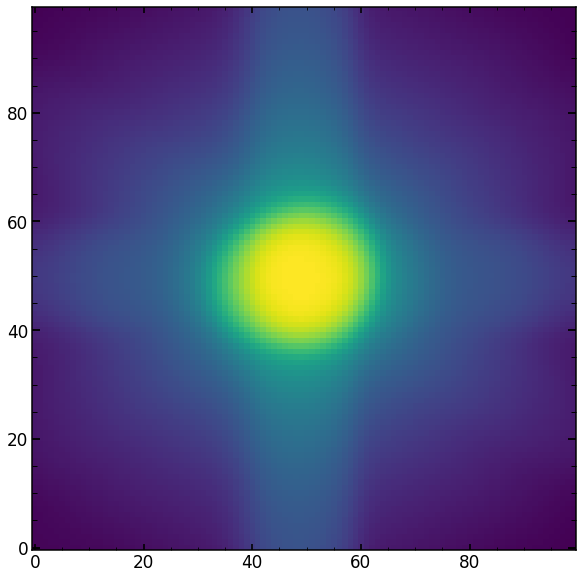

In [520]:
plt.imshow(array_of_simulation_00[80],norm=LogNorm())

# Fine defocus exploration 

57
1


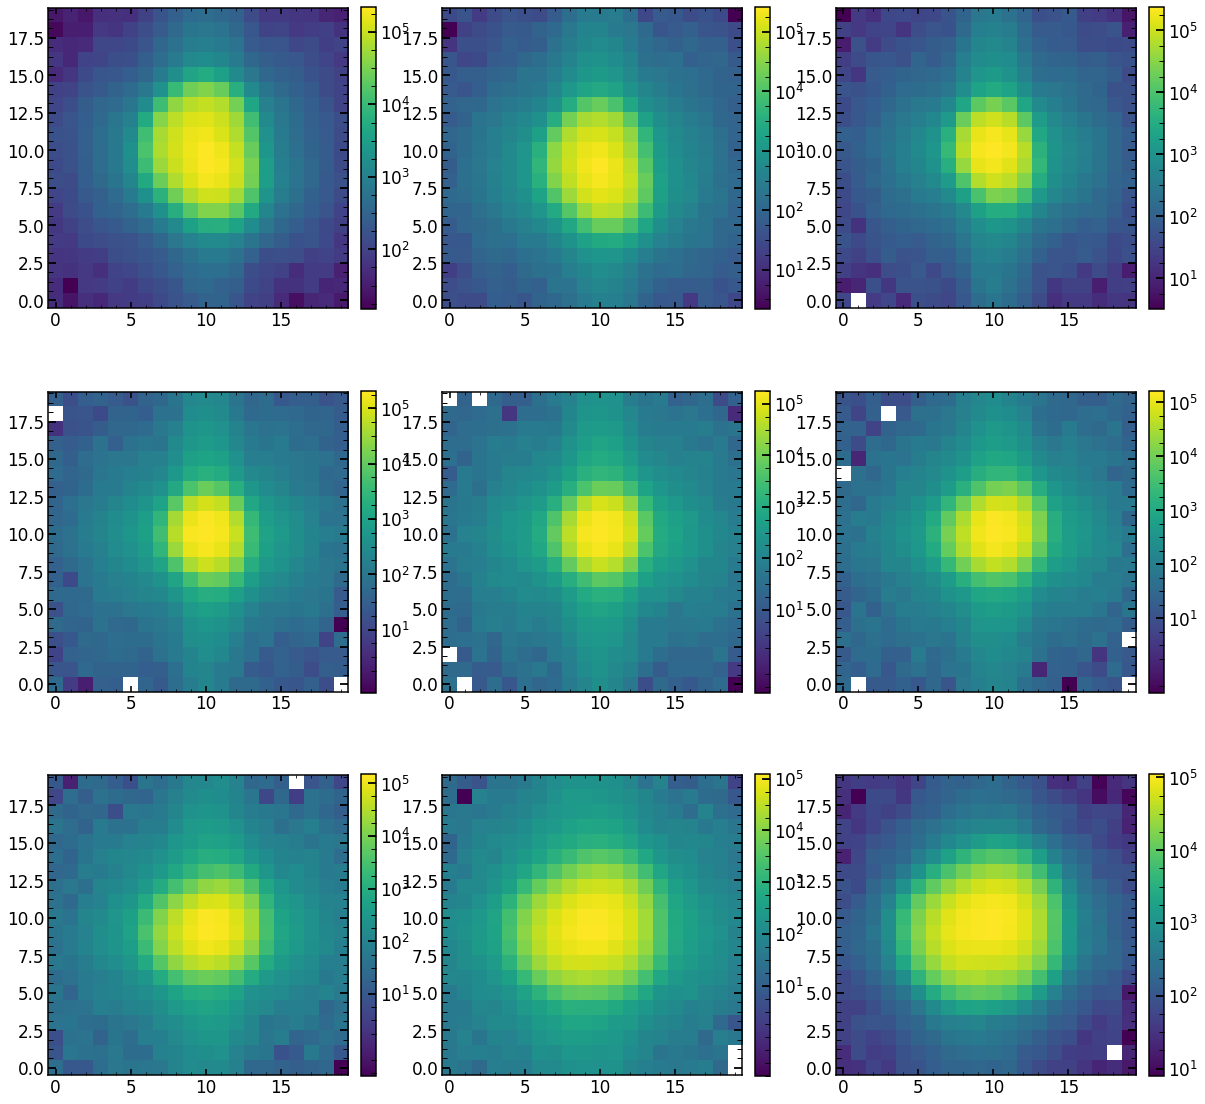

In [528]:
matplotlib.rcParams.update({'font.size': 14})

image_index=57
single_number=image_index
print(image_index)
print(finalHgAr.loc[image_index]['close'])

run_1=21280+30-30
run_2=21280+30-24
run_3=21280+30-12
run_4=21280+30-6
run_5=21280+30
run_6=21280+30+6
run_7=21280+30+12
run_8=21280+30+24
run_9=21280+30+30


sci_1=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_1)+str(image_index)+'HgAr_Stacked.npy')
sci_2=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_2)+str(image_index)+'HgAr_Stacked.npy')
sci_3=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_3)+str(image_index)+'HgAr_Stacked.npy')
sci_4=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_4)+str(image_index)+'HgAr_Stacked.npy')
sci_5=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_5)+str(image_index)+'HgAr_Stacked.npy')
sci_6=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_6)+str(image_index)+'HgAr_Stacked.npy')
sci_7=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_7)+str(image_index)+'HgAr_Stacked.npy')
sci_8=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_8)+str(image_index)+'HgAr_Stacked.npy')
sci_9=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_9)+str(image_index)+'HgAr_Stacked.npy')

plt.figure(figsize=(20,20))
plt.subplot(331)
plt.imshow(sci_1,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(332)
plt.imshow(sci_2,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(333)
plt.imshow(sci_3,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(334)
plt.imshow(sci_4,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(335)
plt.imshow(sci_5,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(336)
plt.imshow(sci_6,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(337)
plt.imshow(sci_7,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(338)
plt.imshow(sci_8,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(339)
plt.imshow(sci_9,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [531]:
date='Aug16'
results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
create_results_of_fit_single(date,single_number,'HgAr',22,4)
solution_at_0,solution_at_05_0_05=solution_at_0_and_plots(date,single_number,'HgAr',results_of_fit_single,err_results_of_fit_single,\
                                      err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,22,return_solution_at_05_0_05=True)
    
results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    create_results_of_fit_single_focus('Sep11',single_number,'HgAr',22,4)
results_of_fit_single.values  

22
57 obs (Emcee3): 21352 is found!
57 obs (Emcee3): 21358 is found!
57 obs (Emcee3): 21364 is found!
x_ilum: failed!
x_ilum: failed!
57 21370 HgAr is NOT found or failed!
57 21376 HgAr is NOT found or failed!
57 obs (Emcee3): 21382 is found!
radiometricExponent: failed!
y_ilum: failed!
radiometricExponent: failed!
y_ilum: failed!
57 21388 HgAr is NOT found or failed!
57 obs (Emcee3): 21394 is found!
radiometricExponent: failed!
x_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
57 obs (Emcee3): 21400 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
57 obs (Emcee3): 21400 is found!
x_ilum: failed!
y_ilum: failed!
x_ilum: failed!
y_ilum: failed!
57 obs (Emcee3): 21406 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
57 21412 HgAr is NOT found or failed!
57 obs (Emcee3): 21418 is found!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
radiometricExponent: fail

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [535]:
results_of_fit_many_single_focus_HgAr_pd.loc[57]

z4                -0.225555
z5                -0.362994
z6                -0.598557
z7                -0.071834
z8                -0.074525
                   ...     
pixel_effect       0.419527
fiber_r            1.859664
flux               0.995478
chi2              40.373144
chi2max         8086.377441
Name: 57, Length: 44, dtype: float64

In [536]:
solution_at_0

array([   -0.15944101,    -0.47778826,    -0.71612916,     0.00171886,
          -0.09997748,    -0.13143853,    -0.33771992,    -0.17822842,
           0.03654131,     0.03724674,     0.01900913,     0.04493979,
          -0.01215408,     0.02669637,     0.00989739,     0.00274851,
          -0.03285422,     0.02554974,     0.02456294,     0.66386338,
           0.0854535 ,    -0.04897921,     0.14779938,     0.06137148,
           0.03908185,     0.0000064 ,     0.00000641,     0.9733939 ,
           0.94834522,     0.00756611,    -0.02214517,     0.92306044,
           0.05796154,     0.85916037,     1.05362071,     0.15064077,
       65339.29942757,     2.61457778,     0.0043023 ,     0.37080275,
           1.85050642,     0.99935402])

In [541]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_HgAr_from_Sep11.pkl', 'rb') as f:
    results_of_fit_many_single_focus_HgAr_pd=pickle.load(f)

with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_HgAr_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_direct_preDecemberrun_HgAr=pickle.load(f)

In [540]:
results_of_fit_many_direct_preDecemberrun_HgAr['0p'].loc[57]

z4             -0.159441
z5             -0.477788
z6             -0.716129
z7              0.001719
z8             -0.099977
                  ...   
pixel_effect    0.370803
fiber_r         1.850506
flux            0.999354
chi2            1.000000
chi2max         1.000000
Name: 57, Length: 44, dtype: float64

In [556]:
results_of_fit_many_single_focus_HgAr_pd.iloc[19]

z4                -0.002466
z5                -0.222968
z6                -0.763223
z7                 0.002643
z8                -0.174354
                   ...     
pixel_effect       0.423481
fiber_r            1.814257
flux               0.995872
chi2              29.152525
chi2max         6552.491699
Name: 69, Length: 44, dtype: float64